In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [19]:
def neuron_layer(X, n_neurons, name,n_inputs, activation=None):
    '''Function to define working of perceptrons of one layer of neural network'''
    with tf.name_scope(name):
        #n_inputs = int(X.get_shape()[-1])
        stddev = 2/np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros(n_neurons), name="bias")
        output = tf.matmul(X,W) + b
        if activation is not None:
            return activation(output)
        else:
            return output

def train_NN(X,Y,n_hidden1,activation = 'sigmoid' ):
    
    n_outputs = 3
    
    stddev = 2/np.sqrt(2)
    init = tf.truncated_normal((2, n_hidden1), stddev=stddev)
    W1= tf.Variable(init)
    b1= tf.Variable(tf.zeros(n_hidden1))
    output1= tf.matmul(X,W1)+ b1

    if activation == 'elu':
        hidden1 = tf.nn.elu(output1)
    elif activation == 'sigmoid':
        hidden1 = tf.nn.sigmoid(output1)
        
    stddev = 2/np.sqrt(n_hidden)
    init = tf.truncated_normal((n_hidden, n_outputs), stddev=stddev)
    W2= tf.Variable(init)
    b2= tf.Variable(tf.zeros(n_outputs))
    logits= tf.matmul(hidden1,W2)+ b2
            
    #ogits = neuron_layer(hidden1, n_outputs, name="outputs",n_inputs = n_hidden1)
    
    a2 = tf.nn.softmax(logits)
    
    return (a2,logits)
    
    

In [20]:
def take_next_batch(current_batch_no,train_image,train_label,batch_size):
    '''
    Function to return images and their labels of certain batch size 
    '''
    
    out_img=train_image[current_batch_no:(current_batch_no + batch_size), :]
    out_label=train_label[current_batch_no:(current_batch_no + batch_size),:]
    current_batch_no += batch_size
    #print(len(out_img))
    return (out_img,out_label,current_batch_no)


In [21]:
def hot_encode(y_true,cl_no):
    
    hotcode = np.zeros((np.shape(y_true)[0],cl_no))
    
    for i in range(np.shape(y_true)[0]):
        hotcode[i,y_true[i]-1] = 1
    
    return hotcode


In [59]:
train_data = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/train3_data.csv', header = None)
train_label = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/train3_label.csv', header = None)



x_in = np.transpose(train_data.to_numpy())
#x_in = norm(x_in)
y_true=np.transpose(train_label.to_numpy())

y_true_hot = hot_encode(y_true,3)

In [61]:
batch_size = 10
X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None, 3), name="y")

n_hidden = 5

a2,logits = train_NN(X,y,n_hidden,'elu')
'''Starting with finding loss'''
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
    '''cost function'''
    loss=tf.reduce_mean(cross_entropy, name="loss")
    '''Minimizing cost function using gradient descent algorithm'''

learning_rate=0.01

with tf.name_scope("grad"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5)
    training_output=optimizer.minimize(loss)
'''Accuracy:- .in_top_k() function checks if highest logit corresponds to target class'''
with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(a2, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.global_variables_initializer()

with tf.Session() as sess:
        init.run()
        N = 100
        k = 10
        fold = 1
        
        validate_data = x_in[fold*(N//k):(fold+1)*(N//k),:]
        train_data = np.concatenate((x_in[:fold*(N//k),:], x_in[(fold+1)*(N//k):,:]), axis = 0)
        
        validate_label = y_true_hot[fold*(N//k):(fold+1)*(N//k),:]
        train_label = np.concatenate((y_true_hot[:fold*(N//k),:], y_true_hot[(fold+1)*(N//k):,:]), axis = 0)
        
        
        n_epochs = 500
        b = [0]*n_epochs
        c = [0]*n_epochs
        ls = [0]*n_epochs
    
        for epoch in range(n_epochs):
            current_batch_no=0
            epoch_loss = 0
            print('--------------------------------------------------------------------------------------')
            for iteration in range((N-k)//batch_size):
                epoch_x,epoch_y,current_batch_no = take_next_batch(current_batch_no,train_data,train_label,batch_size)
                _,L,a2_gat = sess.run([training_output,loss,a2], feed_dict={X: epoch_x, y: epoch_y})
                epoch_loss += L
                
            
                acc_train = accuracy.eval(feed_dict={X: epoch_x, y: epoch_y})

                print('Loss',L,'Train Accuracy:',acc_train)
            
            acc_train = accuracy.eval(feed_dict={X: train_data, y: train_label})
            loss_train = loss.eval(feed_dict={X: train_data, y: train_label})
            acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
            loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})
            b[epoch] = acc_train
            c[epoch] = acc_test
            ls[epoch]= epoch_loss
 
            print("Epoch", epoch+1, "Train accuracy:", acc_train, "Test accuracy:", acc_test,"Train loss",loss_train,"test loss",loss_test)
    


--------------------------------------------------------------------------------------
Loss 27.403625 Train Accuracy: 0.2
Loss 24.664358 Train Accuracy: 0.4
Loss 10.550793 Train Accuracy: 0.3
Loss 14.02317 Train Accuracy: 0.6
Loss 13.87724 Train Accuracy: 0.2
Loss 6.6217623 Train Accuracy: 0.5
Loss 7.012356 Train Accuracy: 0.3
Loss 2.8578243 Train Accuracy: 0.5
Loss 8.306445 Train Accuracy: 0.6
Epoch 1 Train accuracy: 0.41111112 Test accuracy: 0.5 Train loss 3.5562737 test loss 4.895273
--------------------------------------------------------------------------------------
Loss 1.9397147 Train Accuracy: 0.5
Loss 4.1989374 Train Accuracy: 0.6
Loss 3.6979084 Train Accuracy: 0.6
Loss 6.821692 Train Accuracy: 0.6
Loss 6.116998 Train Accuracy: 0.4
Loss 2.2365427 Train Accuracy: 0.4
Loss 1.7492428 Train Accuracy: 0.5
Loss 1.7830493 Train Accuracy: 0.7
Loss 1.6479843 Train Accuracy: 0.6
Epoch 2 Train accuracy: 0.4888889 Test accuracy: 0.6 Train loss 1.987874 test loss 0.78760386
--------------

Loss 0.46377993 Train Accuracy: 0.7
Loss 0.51795626 Train Accuracy: 0.8
Loss 0.7413413 Train Accuracy: 0.7
Loss 0.55624664 Train Accuracy: 0.9
Loss 0.6378654 Train Accuracy: 0.9
Loss 0.37679148 Train Accuracy: 0.9
Loss 0.6192634 Train Accuracy: 0.9
Epoch 21 Train accuracy: 0.74444443 Test accuracy: 0.7 Train loss 0.6074086 test loss 0.8330656
--------------------------------------------------------------------------------------
Loss 0.43473935 Train Accuracy: 0.9
Loss 1.0092049 Train Accuracy: 0.9
Loss 0.45186663 Train Accuracy: 0.7
Loss 0.5121255 Train Accuracy: 0.8
Loss 0.72890127 Train Accuracy: 0.7
Loss 0.5289294 Train Accuracy: 0.9
Loss 0.63425624 Train Accuracy: 0.9
Loss 0.36977908 Train Accuracy: 0.9
Loss 0.61002076 Train Accuracy: 0.9
Epoch 22 Train accuracy: 0.74444443 Test accuracy: 0.7 Train loss 0.5802463 test loss 0.7988754
--------------------------------------------------------------------------------------
Loss 0.43113643 Train Accuracy: 0.9
Loss 0.97272205 Train Accura

Loss 0.42786327 Train Accuracy: 1.0
Loss 0.32644612 Train Accuracy: 0.9
Loss 0.3757035 Train Accuracy: 0.8
Loss 0.5381162 Train Accuracy: 0.8
Loss 0.29714295 Train Accuracy: 1.0
Loss 0.5468061 Train Accuracy: 0.8
Loss 0.30460253 Train Accuracy: 0.9
Loss 0.42294613 Train Accuracy: 1.0
Epoch 39 Train accuracy: 0.9111111 Test accuracy: 0.9 Train loss 0.36643258 test loss 0.3260696
--------------------------------------------------------------------------------------
Loss 0.44187564 Train Accuracy: 0.9
Loss 0.41114706 Train Accuracy: 1.0
Loss 0.3230489 Train Accuracy: 0.9
Loss 0.37783346 Train Accuracy: 0.8
Loss 0.53389394 Train Accuracy: 0.8
Loss 0.29187852 Train Accuracy: 1.0
Loss 0.5421773 Train Accuracy: 0.8
Loss 0.3058439 Train Accuracy: 0.9
Loss 0.4126857 Train Accuracy: 1.0
Epoch 40 Train accuracy: 0.9111111 Test accuracy: 1.0 Train loss 0.36294428 test loss 0.31925625
--------------------------------------------------------------------------------------
Loss 0.44719887 Train Accura

Loss 0.3135577 Train Accuracy: 1.0
Epoch 56 Train accuracy: 0.9 Test accuracy: 1.0 Train loss 0.3273371 test loss 0.28121302
--------------------------------------------------------------------------------------
Loss 0.49412346 Train Accuracy: 0.9
Loss 0.27434725 Train Accuracy: 1.0
Loss 0.23977408 Train Accuracy: 0.9
Loss 0.33072975 Train Accuracy: 0.9
Loss 0.4685656 Train Accuracy: 0.9
Loss 0.22562358 Train Accuracy: 1.0
Loss 0.41021267 Train Accuracy: 0.9
Loss 0.38281485 Train Accuracy: 1.0
Loss 0.30688137 Train Accuracy: 1.0
Epoch 57 Train accuracy: 0.9111111 Test accuracy: 1.0 Train loss 0.322735 test loss 0.2768274
--------------------------------------------------------------------------------------
Loss 0.48955113 Train Accuracy: 0.9
Loss 0.27024883 Train Accuracy: 1.0
Loss 0.23480494 Train Accuracy: 0.9
Loss 0.32503906 Train Accuracy: 0.9
Loss 0.46686158 Train Accuracy: 0.9
Loss 0.22140057 Train Accuracy: 1.0
Loss 0.40400904 Train Accuracy: 0.9
Loss 0.38246712 Train Accuracy: 

Epoch 75 Train accuracy: 0.9222222 Test accuracy: 1.0 Train loss 0.24586001 test loss 0.23327334
--------------------------------------------------------------------------------------
Loss 0.4272396 Train Accuracy: 0.9
Loss 0.2015403 Train Accuracy: 1.0
Loss 0.17123845 Train Accuracy: 1.0
Loss 0.23671944 Train Accuracy: 0.9
Loss 0.4481376 Train Accuracy: 0.9
Loss 0.17228669 Train Accuracy: 1.0
Loss 0.34684235 Train Accuracy: 0.9
Loss 0.2764165 Train Accuracy: 1.0
Loss 0.19952057 Train Accuracy: 1.0
Epoch 76 Train accuracy: 0.9222222 Test accuracy: 1.0 Train loss 0.24352258 test loss 0.23215099
--------------------------------------------------------------------------------------
Loss 0.4256652 Train Accuracy: 0.9
Loss 0.19867185 Train Accuracy: 1.0
Loss 0.16938198 Train Accuracy: 1.0
Loss 0.23426595 Train Accuracy: 0.9
Loss 0.44702744 Train Accuracy: 0.9
Loss 0.17039207 Train Accuracy: 1.0
Loss 0.3448711 Train Accuracy: 0.9
Loss 0.27252638 Train Accuracy: 1.0
Loss 0.19678581 Train Accu

Loss 0.14570655 Train Accuracy: 1.0
Loss 0.19692075 Train Accuracy: 1.0
Loss 0.4300483 Train Accuracy: 0.9
Loss 0.14185132 Train Accuracy: 1.0
Loss 0.3117785 Train Accuracy: 0.9
Loss 0.22771136 Train Accuracy: 1.0
Loss 0.16737512 Train Accuracy: 1.0
Epoch 93 Train accuracy: 0.9444444 Test accuracy: 1.0 Train loss 0.21413322 test loss 0.2081645
--------------------------------------------------------------------------------------
Loss 0.39949 Train Accuracy: 0.9
Loss 0.1648814 Train Accuracy: 1.0
Loss 0.14448793 Train Accuracy: 1.0
Loss 0.1950601 Train Accuracy: 1.0
Loss 0.4290034 Train Accuracy: 0.9
Loss 0.14030547 Train Accuracy: 1.0
Loss 0.3099134 Train Accuracy: 0.9
Loss 0.22569299 Train Accuracy: 1.0
Loss 0.16606298 Train Accuracy: 1.0
Epoch 94 Train accuracy: 0.9444444 Test accuracy: 1.0 Train loss 0.21280575 test loss 0.20683447
--------------------------------------------------------------------------------------
Loss 0.39824423 Train Accuracy: 0.9
Loss 0.16345021 Train Accuracy

Loss 0.14857557 Train Accuracy: 1.0
Epoch 110 Train accuracy: 0.9444444 Test accuracy: 1.0 Train loss 0.1947005 test loss 0.18729874
--------------------------------------------------------------------------------------
Loss 0.38165787 Train Accuracy: 0.9
Loss 0.1445307 Train Accuracy: 1.0
Loss 0.12662795 Train Accuracy: 1.0
Loss 0.16974743 Train Accuracy: 1.0
Loss 0.41192207 Train Accuracy: 0.8
Loss 0.11783664 Train Accuracy: 1.0
Loss 0.28035206 Train Accuracy: 0.9
Loss 0.19938737 Train Accuracy: 1.0
Loss 0.14764512 Train Accuracy: 1.0
Epoch 111 Train accuracy: 0.9444444 Test accuracy: 1.0 Train loss 0.1937209 test loss 0.1861813
--------------------------------------------------------------------------------------
Loss 0.38078478 Train Accuracy: 0.9
Loss 0.1435352 Train Accuracy: 1.0
Loss 0.12571648 Train Accuracy: 1.0
Loss 0.16853535 Train Accuracy: 1.0
Loss 0.4109706 Train Accuracy: 0.8
Loss 0.11670456 Train Accuracy: 1.0
Loss 0.27870828 Train Accuracy: 0.9
Loss 0.19818184 Train Ac

Loss 0.09887113 Train Accuracy: 1.0
Loss 0.25078693 Train Accuracy: 0.9
Loss 0.1811336 Train Accuracy: 1.0
Loss 0.1320252 Train Accuracy: 1.0
Epoch 130 Train accuracy: 0.9444444 Test accuracy: 1.0 Train loss 0.17746651 test loss 0.16660985
--------------------------------------------------------------------------------------
Loss 0.36616665 Train Accuracy: 0.9
Loss 0.12726906 Train Accuracy: 1.0
Loss 0.11045271 Train Accuracy: 1.0
Loss 0.14957772 Train Accuracy: 1.0
Loss 0.39432496 Train Accuracy: 0.8
Loss 0.09799938 Train Accuracy: 1.0
Loss 0.24933977 Train Accuracy: 0.9
Loss 0.18039398 Train Accuracy: 1.0
Loss 0.13129425 Train Accuracy: 1.0
Epoch 131 Train accuracy: 0.9444444 Test accuracy: 1.0 Train loss 0.17671569 test loss 0.1656623
--------------------------------------------------------------------------------------
Loss 0.3654789 Train Accuracy: 0.9
Loss 0.1265253 Train Accuracy: 1.0
Loss 0.10973915 Train Accuracy: 1.0
Loss 0.14875695 Train Accuracy: 1.0
Loss 0.39353314 Train A

Loss 0.38250154 Train Accuracy: 0.9
Loss 0.08543422 Train Accuracy: 1.0
Loss 0.22776346 Train Accuracy: 1.0
Loss 0.1701731 Train Accuracy: 1.0
Loss 0.12073958 Train Accuracy: 1.0
Epoch 147 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.16577546 test loss 0.15150002
--------------------------------------------------------------------------------------
Loss 0.35516256 Train Accuracy: 0.9
Loss 0.115798116 Train Accuracy: 1.0
Loss 0.09935614 Train Accuracy: 1.0
Loss 0.13723035 Train Accuracy: 1.0
Loss 0.38182086 Train Accuracy: 0.9
Loss 0.08472733 Train Accuracy: 1.0
Loss 0.22651418 Train Accuracy: 1.0
Loss 0.16961563 Train Accuracy: 1.0
Loss 0.12014669 Train Accuracy: 1.0
Epoch 148 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.16515242 test loss 0.15067689
--------------------------------------------------------------------------------------
Loss 0.3545565 Train Accuracy: 0.9
Loss 0.11519201 Train Accuracy: 1.0
Loss 0.09876706 Train Accuracy: 1.0
Loss 0.13659446 T

Epoch 163 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.15652895 test loss 0.13913357
--------------------------------------------------------------------------------------
Loss 0.3459085 Train Accuracy: 0.9
Loss 0.106852554 Train Accuracy: 1.0
Loss 0.09066981 Train Accuracy: 1.0
Loss 0.12792799 Train Accuracy: 1.0
Loss 0.37172192 Train Accuracy: 0.9
Loss 0.074466586 Train Accuracy: 1.0
Loss 0.20802808 Train Accuracy: 1.0
Loss 0.16161041 Train Accuracy: 1.0
Loss 0.111656286 Train Accuracy: 1.0
Epoch 164 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.15599734 test loss 0.13841307
--------------------------------------------------------------------------------------
Loss 0.34535605 Train Accuracy: 0.9
Loss 0.10634272 Train Accuracy: 1.0
Loss 0.09017619 Train Accuracy: 1.0
Loss 0.1274011 Train Accuracy: 1.0
Loss 0.3711329 Train Accuracy: 0.9
Loss 0.073886395 Train Accuracy: 1.0
Loss 0.206956 Train Accuracy: 1.0
Loss 0.16115387 Train Accuracy: 1.0
Loss 0.111182734 

Loss 0.11998703 Train Accuracy: 1.0
Loss 0.36283833 Train Accuracy: 0.9
Loss 0.065872595 Train Accuracy: 1.0
Loss 0.19167225 Train Accuracy: 1.0
Loss 0.15486923 Train Accuracy: 1.0
Loss 0.10488955 Train Accuracy: 1.0
Epoch 180 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.14812277 test loss 0.12757492
--------------------------------------------------------------------------------------
Loss 0.3367969 Train Accuracy: 0.9
Loss 0.09887612 Train Accuracy: 1.0
Loss 0.08290824 Train Accuracy: 1.0
Loss 0.119532034 Train Accuracy: 1.0
Loss 0.36231858 Train Accuracy: 0.9
Loss 0.06538351 Train Accuracy: 1.0
Loss 0.19071458 Train Accuracy: 1.0
Loss 0.1544847 Train Accuracy: 1.0
Loss 0.104510106 Train Accuracy: 1.0
Epoch 181 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.14766762 test loss 0.12694897
--------------------------------------------------------------------------------------
Loss 0.33629197 Train Accuracy: 0.9
Loss 0.09844963 Train Accuracy: 1.0
Loss 0.08249 Tr

Epoch 198 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.14048815 test loss 0.1170179
--------------------------------------------------------------------------------------
Loss 0.32803407 Train Accuracy: 0.9
Loss 0.091797814 Train Accuracy: 1.0
Loss 0.075932555 Train Accuracy: 1.0
Loss 0.11201189 Train Accuracy: 1.0
Loss 0.35366398 Train Accuracy: 0.9
Loss 0.057440896 Train Accuracy: 1.0
Loss 0.17481542 Train Accuracy: 1.0
Loss 0.14810339 Train Accuracy: 1.0
Loss 0.09843246 Train Accuracy: 1.0
Epoch 199 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.14009559 test loss 0.116470955
--------------------------------------------------------------------------------------
Loss 0.32756156 Train Accuracy: 0.9
Loss 0.09143917 Train Accuracy: 1.0
Loss 0.07557656 Train Accuracy: 1.0
Loss 0.11162679 Train Accuracy: 1.0
Loss 0.35321823 Train Accuracy: 0.9
Loss 0.057042558 Train Accuracy: 1.0
Loss 0.17400122 Train Accuracy: 1.0
Loss 0.14777543 Train Accuracy: 1.0
Loss 0.09813

Epoch 218 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.13317579 test loss 0.106783226
--------------------------------------------------------------------------------------
Loss 0.31885967 Train Accuracy: 0.9
Loss 0.085215144 Train Accuracy: 1.0
Loss 0.06934588 Train Accuracy: 1.0
Loss 0.104843654 Train Accuracy: 1.0
Loss 0.3453916 Train Accuracy: 0.9
Loss 0.05019031 Train Accuracy: 1.0
Loss 0.15969598 Train Accuracy: 1.0
Loss 0.14195463 Train Accuracy: 1.0
Loss 0.093142465 Train Accuracy: 1.0
Epoch 219 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.13283749 test loss 0.10630842
--------------------------------------------------------------------------------------
Loss 0.3184157 Train Accuracy: 0.9
Loss 0.084916316 Train Accuracy: 1.0
Loss 0.06904347 Train Accuracy: 1.0
Loss 0.10451033 Train Accuracy: 1.0
Loss 0.3450101 Train Accuracy: 0.9
Loss 0.049863838 Train Accuracy: 1.0
Loss 0.15900007 Train Accuracy: 1.0
Loss 0.14166526 Train Accuracy: 1.0
Loss 0.092914

Loss 0.3389442 Train Accuracy: 0.9
Loss 0.04475544 Train Accuracy: 1.0
Loss 0.14796136 Train Accuracy: 1.0
Loss 0.1368964 Train Accuracy: 1.0
Loss 0.08953365 Train Accuracy: 1.0
Epoch 237 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.12711532 test loss 0.09827576
--------------------------------------------------------------------------------------
Loss 0.31052965 Train Accuracy: 0.9
Loss 0.07997702 Train Accuracy: 1.0
Loss 0.06396268 Train Accuracy: 1.0
Loss 0.09881034 Train Accuracy: 1.0
Loss 0.338613 Train Accuracy: 0.9
Loss 0.04447857 Train Accuracy: 1.0
Loss 0.14735493 Train Accuracy: 1.0
Loss 0.1366247 Train Accuracy: 1.0
Loss 0.08936309 Train Accuracy: 1.0
Epoch 238 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.126816 test loss 0.097855136
--------------------------------------------------------------------------------------
Loss 0.31009284 Train Accuracy: 0.9
Loss 0.07972554 Train Accuracy: 1.0
Loss 0.06369823 Train Accuracy: 1.0
Loss 0.09850566 Train 

Epoch 256 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.12168822 test loss 0.090654075
--------------------------------------------------------------------------------------
Loss 0.30203778 Train Accuracy: 0.9
Loss 0.07557813 Train Accuracy: 1.0
Loss 0.05922674 Train Accuracy: 1.0
Loss 0.093009524 Train Accuracy: 1.0
Loss 0.3327813 Train Accuracy: 0.9
Loss 0.03965592 Train Accuracy: 1.0
Loss 0.13657248 Train Accuracy: 1.0
Loss 0.13146874 Train Accuracy: 1.0
Loss 0.08674466 Train Accuracy: 1.0
Epoch 257 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.12141536 test loss 0.090271175
--------------------------------------------------------------------------------------
Loss 0.30156776 Train Accuracy: 0.9
Loss 0.075368546 Train Accuracy: 1.0
Loss 0.05899303 Train Accuracy: 1.0
Loss 0.09269657 Train Accuracy: 1.0
Loss 0.33249968 Train Accuracy: 0.9
Loss 0.03942316 Train Accuracy: 1.0
Loss 0.13603994 Train Accuracy: 1.0
Loss 0.13119146 Train Accuracy: 1.0
Loss 0.086641

Loss 0.07212407 Train Accuracy: 1.0
Loss 0.05518849 Train Accuracy: 1.0
Loss 0.08705706 Train Accuracy: 1.0
Loss 0.3280848 Train Accuracy: 0.9
Loss 0.035728984 Train Accuracy: 1.0
Loss 0.12736861 Train Accuracy: 1.0
Loss 0.126355 Train Accuracy: 1.0
Loss 0.085499115 Train Accuracy: 1.0
Epoch 275 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.11665586 test loss 0.08336314
--------------------------------------------------------------------------------------
Loss 0.29221982 Train Accuracy: 0.9
Loss 0.071953 Train Accuracy: 1.0
Loss 0.05497201 Train Accuracy: 1.0
Loss 0.08669764 Train Accuracy: 1.0
Loss 0.32784975 Train Accuracy: 0.9
Loss 0.0355243 Train Accuracy: 1.0
Loss 0.12686987 Train Accuracy: 1.0
Loss 0.12606043 Train Accuracy: 1.0
Loss 0.085464984 Train Accuracy: 1.0
Epoch 276 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.116398685 test loss 0.08297197
--------------------------------------------------------------------------------------
Loss 0.29163903 Tr

Loss 0.081089735 Train Accuracy: 1.0
Loss 0.32462782 Train Accuracy: 0.9
Loss 0.032668196 Train Accuracy: 1.0
Loss 0.11967158 Train Accuracy: 1.0
Loss 0.12160516 Train Accuracy: 1.0
Loss 0.085288 Train Accuracy: 1.0
Epoch 291 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.112683244 test loss 0.077206254
--------------------------------------------------------------------------------------
Loss 0.2825872 Train Accuracy: 0.9
Loss 0.06945461 Train Accuracy: 1.0
Loss 0.05160104 Train Accuracy: 1.0
Loss 0.08070344 Train Accuracy: 1.0
Loss 0.32443497 Train Accuracy: 0.9
Loss 0.032492284 Train Accuracy: 1.0
Loss 0.11921164 Train Accuracy: 1.0
Loss 0.12130759 Train Accuracy: 1.0
Loss 0.08529456 Train Accuracy: 1.0
Epoch 292 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.112445585 test loss 0.07682892
--------------------------------------------------------------------------------------
Loss 0.28196818 Train Accuracy: 0.9
Loss 0.06931055 Train Accuracy: 1.0
Loss 0.051396

Loss 0.0742145 Train Accuracy: 1.0
Loss 0.32153964 Train Accuracy: 0.9
Loss 0.029718038 Train Accuracy: 1.0
Loss 0.11200212 Train Accuracy: 1.0
Loss 0.11635579 Train Accuracy: 1.0
Loss 0.08558614 Train Accuracy: 1.0
Epoch 309 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.10859622 test loss 0.07075169
--------------------------------------------------------------------------------------
Loss 0.27144375 Train Accuracy: 0.9
Loss 0.06707498 Train Accuracy: 1.0
Loss 0.047949675 Train Accuracy: 1.0
Loss 0.07384635 Train Accuracy: 1.0
Loss 0.32140443 Train Accuracy: 0.9
Loss 0.029564444 Train Accuracy: 1.0
Loss 0.11162589 Train Accuracy: 1.0
Loss 0.116065405 Train Accuracy: 1.0
Loss 0.08560793 Train Accuracy: 1.0
Epoch 310 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.1083809 test loss 0.0704227
--------------------------------------------------------------------------------------
Loss 0.27082565 Train Accuracy: 0.9
Loss 0.06695305 Train Accuracy: 1.0
Loss 0.04775316

Loss 0.06501528 Train Accuracy: 1.0
Loss 0.044587053 Train Accuracy: 1.0
Loss 0.06736632 Train Accuracy: 1.0
Loss 0.31936547 Train Accuracy: 0.8
Loss 0.027062261 Train Accuracy: 1.0
Loss 0.10575582 Train Accuracy: 1.0
Loss 0.11097878 Train Accuracy: 1.0
Loss 0.08580426 Train Accuracy: 1.0
Epoch 328 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.10477369 test loss 0.065176606
--------------------------------------------------------------------------------------
Loss 0.260884 Train Accuracy: 0.9
Loss 0.06489655 Train Accuracy: 1.0
Loss 0.044404753 Train Accuracy: 1.0
Loss 0.06704964 Train Accuracy: 1.0
Loss 0.3192603 Train Accuracy: 0.8
Loss 0.026937444 Train Accuracy: 1.0
Loss 0.10548289 Train Accuracy: 1.0
Loss 0.1107368 Train Accuracy: 1.0
Loss 0.08578603 Train Accuracy: 1.0
Epoch 329 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.10458922 test loss 0.06493454
--------------------------------------------------------------------------------------
Loss 0.26043963

Loss 0.10195579 Train Accuracy: 1.0
Loss 0.106688894 Train Accuracy: 1.0
Loss 0.08482146 Train Accuracy: 1.0
Epoch 347 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.10128475 test loss 0.063265614
--------------------------------------------------------------------------------------
Loss 0.25283414 Train Accuracy: 0.9
Loss 0.06079321 Train Accuracy: 1.0
Loss 0.04104709 Train Accuracy: 1.0
Loss 0.061875254 Train Accuracy: 1.0
Loss 0.31994963 Train Accuracy: 0.8
Loss 0.02426603 Train Accuracy: 1.0
Loss 0.10168892 Train Accuracy: 1.0
Loss 0.10657053 Train Accuracy: 1.0
Loss 0.084714755 Train Accuracy: 1.0
Epoch 348 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.10111503 test loss 0.06322595
--------------------------------------------------------------------------------------
Loss 0.25256395 Train Accuracy: 0.9
Loss 0.06052348 Train Accuracy: 1.0
Loss 0.040875264 Train Accuracy: 1.0
Loss 0.061620988 Train Accuracy: 1.0
Loss 0.31997886 Train Accuracy: 0.8
Loss 0.024

Loss 0.24895461 Train Accuracy: 0.9
Loss 0.05633094 Train Accuracy: 1.0
Loss 0.03783884 Train Accuracy: 1.0
Loss 0.05685855 Train Accuracy: 1.0
Loss 0.3203274 Train Accuracy: 0.8
Loss 0.02265752 Train Accuracy: 1.0
Loss 0.09530337 Train Accuracy: 1.0
Loss 0.106662296 Train Accuracy: 1.0
Loss 0.08179979 Train Accuracy: 1.0
Epoch 366 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.09814412 test loss 0.061267663
--------------------------------------------------------------------------------------
Loss 0.24875958 Train Accuracy: 0.9
Loss 0.05610211 Train Accuracy: 1.0
Loss 0.037683506 Train Accuracy: 1.0
Loss 0.05658052 Train Accuracy: 1.0
Loss 0.3204151 Train Accuracy: 0.8
Loss 0.02258381 Train Accuracy: 1.0
Loss 0.09497708 Train Accuracy: 1.0
Loss 0.10664394 Train Accuracy: 1.0
Loss 0.08164559 Train Accuracy: 1.0
Epoch 367 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.097989306 test loss 0.06115477
-----------------------------------------------------------------

Loss 0.102322616 Train Accuracy: 1.0
Loss 0.08154908 Train Accuracy: 1.0
Epoch 382 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.09565439 test loss 0.060099613
--------------------------------------------------------------------------------------
Loss 0.24796672 Train Accuracy: 0.9
Loss 0.052273966 Train Accuracy: 1.0
Loss 0.036014684 Train Accuracy: 1.0
Loss 0.052339204 Train Accuracy: 1.0
Loss 0.31878552 Train Accuracy: 0.8
Loss 0.022020757 Train Accuracy: 1.0
Loss 0.09101928 Train Accuracy: 1.0
Loss 0.10169611 Train Accuracy: 1.0
Loss 0.08167621 Train Accuracy: 1.0
Epoch 383 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.09547856 test loss 0.06012226
--------------------------------------------------------------------------------------
Loss 0.24803534 Train Accuracy: 0.9
Loss 0.051995635 Train Accuracy: 1.0
Loss 0.035992846 Train Accuracy: 1.0
Loss 0.052063428 Train Accuracy: 1.0
Loss 0.31836903 Train Accuracy: 0.8
Loss 0.022021217 Train Accuracy: 1.0
Loss 0

Loss 0.08947312 Train Accuracy: 1.0
Loss 0.08260457 Train Accuracy: 1.0
Epoch 401 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.09181451 test loss 0.0701422
--------------------------------------------------------------------------------------
Loss 0.24669111 Train Accuracy: 0.9
Loss 0.0463605 Train Accuracy: 1.0
Loss 0.03483967 Train Accuracy: 1.0
Loss 0.046877176 Train Accuracy: 1.0
Loss 0.31092378 Train Accuracy: 0.8
Loss 0.021610266 Train Accuracy: 1.0
Loss 0.087775074 Train Accuracy: 1.0
Loss 0.089170486 Train Accuracy: 1.0
Loss 0.082521304 Train Accuracy: 1.0
Epoch 402 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.09164428 test loss 0.070773944
--------------------------------------------------------------------------------------
Loss 0.24653485 Train Accuracy: 0.9
Loss 0.046114642 Train Accuracy: 1.0
Loss 0.034743838 Train Accuracy: 1.0
Loss 0.04662348 Train Accuracy: 1.0
Loss 0.31060117 Train Accuracy: 0.8
Loss 0.021580182 Train Accuracy: 1.0
Loss 0.08

Epoch 419 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.08918138 test loss 0.07679482
--------------------------------------------------------------------------------------
Loss 0.24410334 Train Accuracy: 0.9
Loss 0.04280621 Train Accuracy: 1.0
Loss 0.034021992 Train Accuracy: 1.0
Loss 0.043653943 Train Accuracy: 1.0
Loss 0.30341694 Train Accuracy: 0.8
Loss 0.021056179 Train Accuracy: 1.0
Loss 0.084200665 Train Accuracy: 1.0
Loss 0.08554436 Train Accuracy: 1.0
Loss 0.08123014 Train Accuracy: 1.0
Epoch 420 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.08905487 test loss 0.077015325
--------------------------------------------------------------------------------------
Loss 0.24394698 Train Accuracy: 0.9
Loss 0.042666696 Train Accuracy: 1.0
Loss 0.0340024 Train Accuracy: 1.0
Loss 0.043529786 Train Accuracy: 1.0
Loss 0.30301684 Train Accuracy: 0.8
Loss 0.021013793 Train Accuracy: 1.0
Loss 0.08403753 Train Accuracy: 1.0
Loss 0.08540085 Train Accuracy: 1.0
Loss 0.08

Loss 0.033459198 Train Accuracy: 1.0
Loss 0.041780718 Train Accuracy: 1.0
Loss 0.2960503 Train Accuracy: 0.8
Loss 0.020116074 Train Accuracy: 1.0
Loss 0.08120456 Train Accuracy: 1.0
Loss 0.08316539 Train Accuracy: 1.0
Loss 0.07915552 Train Accuracy: 1.0
Epoch 439 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.08687631 test loss 0.07978283
--------------------------------------------------------------------------------------
Loss 0.24131703 Train Accuracy: 0.9
Loss 0.040824074 Train Accuracy: 1.0
Loss 0.033417374 Train Accuracy: 1.0
Loss 0.041699402 Train Accuracy: 1.0
Loss 0.2956613 Train Accuracy: 0.8
Loss 0.020060312 Train Accuracy: 1.0
Loss 0.08105393 Train Accuracy: 1.0
Loss 0.08304815 Train Accuracy: 1.0
Loss 0.07902625 Train Accuracy: 1.0
Epoch 440 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.08676888 test loss 0.07992909
--------------------------------------------------------------------------------------
Loss 0.2412082 Train Accuracy: 0.9
Loss 0.04074

Loss 0.076486416 Train Accuracy: 1.0
Epoch 457 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.084997244 test loss 0.08199666
--------------------------------------------------------------------------------------
Loss 0.23964357 Train Accuracy: 0.9
Loss 0.03962184 Train Accuracy: 1.0
Loss 0.032682892 Train Accuracy: 1.0
Loss 0.04039351 Train Accuracy: 1.0
Loss 0.2884102 Train Accuracy: 0.8
Loss 0.019001719 Train Accuracy: 1.0
Loss 0.0785206 Train Accuracy: 1.0
Loss 0.081013024 Train Accuracy: 1.0
Loss 0.07631803 Train Accuracy: 1.0
Epoch 458 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.08489542 test loss 0.082086846
--------------------------------------------------------------------------------------
Loss 0.23955937 Train Accuracy: 0.9
Loss 0.03956659 Train Accuracy: 1.0
Loss 0.03264364 Train Accuracy: 1.0
Loss 0.040328242 Train Accuracy: 1.0
Loss 0.28799984 Train Accuracy: 0.8
Loss 0.018939268 Train Accuracy: 1.0
Loss 0.07838933 Train Accuracy: 1.0
Loss 0.080

Loss 0.039312467 Train Accuracy: 1.0
Loss 0.28121537 Train Accuracy: 0.8
Loss 0.017852735 Train Accuracy: 1.0
Loss 0.0762908 Train Accuracy: 1.0
Loss 0.07919008 Train Accuracy: 1.0
Loss 0.07302958 Train Accuracy: 1.0
Epoch 476 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.083106756 test loss 0.08302917
--------------------------------------------------------------------------------------
Loss 0.23792127 Train Accuracy: 0.9
Loss 0.03873037 Train Accuracy: 1.0
Loss 0.031948388 Train Accuracy: 1.0
Loss 0.03925796 Train Accuracy: 1.0
Loss 0.2808265 Train Accuracy: 0.8
Loss 0.017788757 Train Accuracy: 1.0
Loss 0.0761735 Train Accuracy: 1.0
Loss 0.07909591 Train Accuracy: 1.0
Loss 0.07283618 Train Accuracy: 1.0
Epoch 477 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.0830098 test loss 0.08303827
--------------------------------------------------------------------------------------
Loss 0.23782682 Train Accuracy: 0.9
Loss 0.038691472 Train Accuracy: 1.0
Loss 0.0319100

Loss 0.0775105 Train Accuracy: 1.0
Loss 0.06922729 Train Accuracy: 1.0
Epoch 495 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.08130822 test loss 0.08241596
--------------------------------------------------------------------------------------
Loss 0.23610099 Train Accuracy: 0.9
Loss 0.038097873 Train Accuracy: 1.0
Loss 0.031221876 Train Accuracy: 1.0
Loss 0.0383253 Train Accuracy: 1.0
Loss 0.27362674 Train Accuracy: 0.8
Loss 0.016584877 Train Accuracy: 1.0
Loss 0.074035324 Train Accuracy: 1.0
Loss 0.07742801 Train Accuracy: 1.0
Loss 0.069021985 Train Accuracy: 1.0
Epoch 496 Train accuracy: 0.96666664 Test accuracy: 1.0 Train loss 0.08121614 test loss 0.08234091
--------------------------------------------------------------------------------------
Loss 0.2360034 Train Accuracy: 0.9
Loss 0.038070064 Train Accuracy: 1.0
Loss 0.031183595 Train Accuracy: 1.0
Loss 0.03828124 Train Accuracy: 1.0
Loss 0.27325988 Train Accuracy: 0.8
Loss 0.016522195 Train Accuracy: 1.0
Loss 0.0739

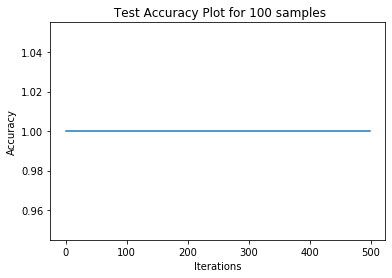

In [75]:
plt.plot(c)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
N = 3
plt.title(' Test Accuracy Plot for 100 samples')
#plt.legend(('Class1', 'Class2', 'Class3', 'Class4'))
plt.show()

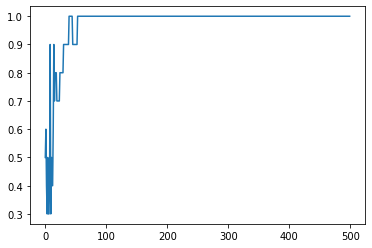

In [63]:
plt.plot(c)
plt.show()

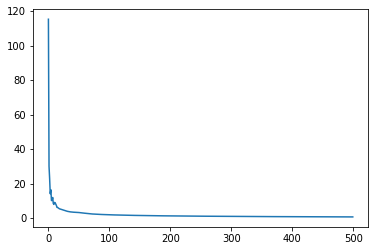

In [64]:
plt.plot(ls)
plt.show()

# K-FOLD cross validation 100

In [24]:
N = 100
k = 10

cl_no = 3


for act in ['elu','sigmoid']:
    
    loss_per_hid_size = []
    accu_per_hid_size = []
    trial = 0
    
    m,n = 0,0
    print('----------------------------------------------------------------------------------------------------')
    print('ACTIVATION FUNCTION : ',act)
    
    print('----------------------------------------------------------------------------------------------------')
    
    for n_hidden in [1,2,3,4,5,6,7,8,9,10]:

        avg_loss_per_fold = []
        avg_accu_per_fold = []
        
        for fold in range(k):


            batch_size = 10
            X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
            y = tf.placeholder(tf.int32, shape=(None, 3), name="y")


            a2,logits = train_NN(X,y,n_hidden,act)
            '''Starting with finding loss'''
            with tf.name_scope("loss"):
                cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
                '''cost function'''
                loss=tf.reduce_mean(cross_entropy, name="loss")
                '''Minimizing cost function using gradient descent algorithm'''
            
            if act == 'elu':
                learning_rate=0.01
            else:
                learning_rate=0.04

            with tf.name_scope("grad"):
                optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5)
                training_output=optimizer.minimize(loss)
            '''Accuracy:- .in_top_k() function checks if highest logit corresponds to target class'''
            with tf.name_scope("eval"):
                correct_prediction = tf.equal(tf.argmax(a2, 1), tf.argmax(y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            init = tf.global_variables_initializer()

            with tf.Session() as sess:
                init.run()


                validate_data = x_in[fold*(N//k):(fold+1)*(N//k),:]
                train_data = np.concatenate((x_in[:fold*(N//k),:], x_in[(fold+1)*(N//k):,:]), axis = 0)

                validate_label = y_true_hot[fold*(N//k):(fold+1)*(N//k),:]
                train_label = np.concatenate((y_true_hot[:fold*(N//k),:], y_true_hot[(fold+1)*(N//k):,:]), axis = 0)


                n_epochs = 250
                
                for epoch in range(n_epochs):
                    current_batch_no=0
                    epoch_loss = 0
                    #print('--------------------------------------------------------------------------------------')
                    for iteration in range((N-k)//batch_size):
                        epoch_x,epoch_y,current_batch_no = take_next_batch(current_batch_no,train_data,train_label,batch_size)
                        _,L,a2_gat = sess.run([training_output,loss,a2], feed_dict={X: epoch_x, y: epoch_y})
                        epoch_loss += L


                        #acc_train = accuracy.eval(feed_dict={X: epoch_x, y: epoch_y})

                        #print('Loss',L,'Train Accuracy:',acc_train)

                    #acc_train = accuracy.eval(feed_dict={X: train_data, y: train_label})
                    #loss_train = loss.eval(feed_dict={X: train_data, y: train_label})
                    #acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
                    #loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})
                    
                    #print("Epoch", epoch+1, "Train accuracy:", acc_train, "Test accuracy:", acc_test,"Train loss",loss_train,"test loss",loss_test)
                acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
                loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})   
                avg_loss_per_fold.append(loss_test)
                avg_accu_per_fold.append(acc_test)
        
        loss_per_hid_size.append(np.mean(avg_loss_per_fold))
        accu_per_hid_size.append(np.mean(avg_accu_per_fold))
        
        
        print('When the size of hidden layer is ',n_hidden,', the calculated LOSS is ',loss_per_hid_size[m],' and the calculated accuracy is ',accu_per_hid_size[n])
        print('--------------------------------------------------------------------------------------------------')
        
        
        m += 1
        n += 1
        
        tf.compat.v1.reset_default_graph()
            

        

----------------------------------------------------------------------------------------------------
ACTIVATION FUNCTION :  elu
----------------------------------------------------------------------------------------------------
When the size of hidden layer is  1 , the calculated LOSS is  0.9529198  and the calculated accuracy is  0.47000003
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  2 , the calculated LOSS is  0.6352935  and the calculated accuracy is  0.74999994
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  3 , the calculated LOSS is  0.32636586  and the calculated accuracy is  0.86
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  4 , the calculated LOSS is  0.2710339  and the calculated accuracy is  0.9199999
----------------

# Testing on 10000

In [32]:
test_data = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/test3_data.csv', header = None)
test_label = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/test3_label.csv', header = None)



x_test_in = np.transpose(test_data.to_numpy())
#x_in = norm(x_in)
y_test_true=np.transpose(test_label.to_numpy())

y_test_true_hot = hot_encode(y_test_true,3)

## Trained on 100

In [65]:
batch_size = 10
X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None, 3), name="y")

n_hidden = 5

a2,logits = train_NN(X,y,n_hidden,'elu')
'''Starting with finding loss'''
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
    '''cost function'''
    loss=tf.reduce_mean(cross_entropy, name="loss")
    '''Minimizing cost function using gradient descent algorithm'''

learning_rate=0.01

with tf.name_scope("grad"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5)
    training_output=optimizer.minimize(loss)
'''Accuracy:- .in_top_k() function checks if highest logit corresponds to target class'''
with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(a2, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    N = 100
    k = 10
    fold = 1

    #validate_data = x_in[fold*(N//k):(fold+1)*(N//k),:]
    #train_data = np.concatenate((x_in[:fold*(N//k),:], x_in[(fold+1)*(N//k):,:]), axis = 0)

    #validate_label = y_true_hot[fold*(N//k):(fold+1)*(N//k),:]
    #train_label = np.concatenate((y_true_hot[:fold*(N//k),:], y_true_hot[(fold+1)*(N//k):,:]), axis = 0)


    n_epochs = 500
    b = [0]*n_epochs
    c = [0]*n_epochs
    ls = [0]*n_epochs

    for epoch in range(n_epochs):
        current_batch_no=0
        epoch_loss = 0
        print('--------------------------------------------------------------------------------------')
        for iteration in range((N-k)//batch_size):
            epoch_x,epoch_y,current_batch_no = take_next_batch(current_batch_no,x_in,y_true_hot,batch_size)
            _,L,a2_gat = sess.run([training_output,loss,a2], feed_dict={X: epoch_x, y: epoch_y})
            epoch_loss += L


            acc_train = accuracy.eval(feed_dict={X: epoch_x, y: epoch_y})

            print('Loss',L,'Train Accuracy:',acc_train)

        acc_train = accuracy.eval(feed_dict={X: train_data, y: train_label})
        loss_train = loss.eval(feed_dict={X: train_data, y: train_label})
        #acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
        #loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})
        b[epoch] = acc_train
        c[epoch] = acc_test
        ls[epoch]= epoch_loss

        print("Epoch", epoch+1, "Train accuracy:", acc_train,"Train loss",loss_train)
    
    #acc_test_new = []
    #loss_test_new= []
    #[(ami*100):((ami+1)*100),:]
    #for ami in range(10):
    acc_test_new = (accuracy.eval(feed_dict={X: x_test_in, y: y_test_true_hot}))
    loss_test_new= (loss.eval(feed_dict={X: x_test_in, y: y_test_true_hot}))
    


--------------------------------------------------------------------------------------
Loss 1.5008014 Train Accuracy: 0.5
Loss 4.9297647 Train Accuracy: 0.5
Loss 7.0366335 Train Accuracy: 0.4
Loss 2.0263436 Train Accuracy: 0.6
Loss 2.4808831 Train Accuracy: 0.4
Loss 5.103771 Train Accuracy: 0.5
Loss 1.4130671 Train Accuracy: 0.5
Loss 4.806966 Train Accuracy: 0.7
Loss 2.7379217 Train Accuracy: 0.6
Epoch 1 Train accuracy: 0.44444445 Train loss 2.526781
--------------------------------------------------------------------------------------
Loss 2.099877 Train Accuracy: 0.4
Loss 2.6145616 Train Accuracy: 0.5
Loss 5.6584206 Train Accuracy: 0.6
Loss 3.2834916 Train Accuracy: 0.6
Loss 1.6137524 Train Accuracy: 0.5
Loss 3.3246684 Train Accuracy: 0.4
Loss 0.9819461 Train Accuracy: 0.7
Loss 1.9837357 Train Accuracy: 0.6
Loss 2.8727562 Train Accuracy: 0.6
Epoch 2 Train accuracy: 0.5222222 Train loss 2.9145997
--------------------------------------------------------------------------------------
Lo

Loss 0.9158646 Train Accuracy: 0.7
Loss 0.698328 Train Accuracy: 0.8
Loss 0.50907946 Train Accuracy: 0.7
Loss 0.7941506 Train Accuracy: 0.5
Loss 0.5026561 Train Accuracy: 0.7
Loss 0.59134245 Train Accuracy: 0.8
Loss 1.1323516 Train Accuracy: 0.5
Epoch 21 Train accuracy: 0.6 Train loss 1.0516268
--------------------------------------------------------------------------------------
Loss 1.2964475 Train Accuracy: 0.4
Loss 1.9283237 Train Accuracy: 0.7
Loss 0.80870163 Train Accuracy: 0.7
Loss 0.67435133 Train Accuracy: 0.8
Loss 0.50176847 Train Accuracy: 0.7
Loss 0.87822914 Train Accuracy: 0.5
Loss 0.5026529 Train Accuracy: 0.7
Loss 0.6063999 Train Accuracy: 0.8
Loss 1.1572719 Train Accuracy: 0.6
Epoch 22 Train accuracy: 0.5888889 Train loss 1.0949165
--------------------------------------------------------------------------------------
Loss 1.3170328 Train Accuracy: 0.4
Loss 2.1582878 Train Accuracy: 0.6
Loss 0.60419065 Train Accuracy: 0.6
Loss 0.6244689 Train Accuracy: 0.8
Loss 0.5105394

Loss 0.48150024 Train Accuracy: 0.8
Loss 0.64838 Train Accuracy: 0.9
Loss 0.6191827 Train Accuracy: 0.7
Epoch 40 Train accuracy: 0.6333333 Train loss 0.6577516
--------------------------------------------------------------------------------------
Loss 0.76722705 Train Accuracy: 0.5
Loss 1.005697 Train Accuracy: 0.8
Loss 0.6270459 Train Accuracy: 0.6
Loss 0.4687809 Train Accuracy: 0.8
Loss 0.46943784 Train Accuracy: 0.6
Loss 1.0020279 Train Accuracy: 0.5
Loss 0.4606851 Train Accuracy: 0.8
Loss 0.62634414 Train Accuracy: 0.9
Loss 0.6213565 Train Accuracy: 0.7
Epoch 41 Train accuracy: 0.65555555 Train loss 0.6852274
--------------------------------------------------------------------------------------
Loss 0.8121891 Train Accuracy: 0.4
Loss 1.1446602 Train Accuracy: 0.7
Loss 0.5920802 Train Accuracy: 0.6
Loss 0.46613532 Train Accuracy: 0.8
Loss 0.46863875 Train Accuracy: 0.6
Loss 1.0612948 Train Accuracy: 0.5
Loss 0.48768258 Train Accuracy: 0.8
Loss 0.641425 Train Accuracy: 0.9
Loss 0.614

Loss 0.35730013 Train Accuracy: 0.9
Loss 0.6802767 Train Accuracy: 0.6
Loss 0.3160699 Train Accuracy: 1.0
Loss 0.50335884 Train Accuracy: 1.0
Loss 0.27102107 Train Accuracy: 1.0
Epoch 60 Train accuracy: 0.9 Train loss 0.37859347
--------------------------------------------------------------------------------------
Loss 0.48843178 Train Accuracy: 0.8
Loss 0.397994 Train Accuracy: 1.0
Loss 0.31006712 Train Accuracy: 0.9
Loss 0.29614592 Train Accuracy: 1.0
Loss 0.3414859 Train Accuracy: 0.9
Loss 0.6716341 Train Accuracy: 0.6
Loss 0.31042743 Train Accuracy: 1.0
Loss 0.50484216 Train Accuracy: 1.0
Loss 0.2651469 Train Accuracy: 1.0
Epoch 61 Train accuracy: 0.9111111 Train loss 0.3717276
--------------------------------------------------------------------------------------
Loss 0.48028255 Train Accuracy: 0.8
Loss 0.39160508 Train Accuracy: 1.0
Loss 0.30239266 Train Accuracy: 0.9
Loss 0.29085356 Train Accuracy: 1.0
Loss 0.32787713 Train Accuracy: 0.9
Loss 0.6646451 Train Accuracy: 0.8
Loss 0.

Loss 0.39211792 Train Accuracy: 0.9
Loss 0.27824023 Train Accuracy: 1.0
Loss 0.21955152 Train Accuracy: 1.0
Loss 0.21637268 Train Accuracy: 1.0
Loss 0.22150648 Train Accuracy: 1.0
Loss 0.5759352 Train Accuracy: 0.8
Loss 0.21547575 Train Accuracy: 1.0
Loss 0.4483171 Train Accuracy: 0.9
Loss 0.21964745 Train Accuracy: 1.0
Epoch 81 Train accuracy: 0.9444444 Train loss 0.28738117
--------------------------------------------------------------------------------------
Loss 0.38936168 Train Accuracy: 0.9
Loss 0.27472678 Train Accuracy: 1.0
Loss 0.21693294 Train Accuracy: 1.0
Loss 0.21343231 Train Accuracy: 1.0
Loss 0.2190566 Train Accuracy: 1.0
Loss 0.5727141 Train Accuracy: 0.8
Loss 0.21209972 Train Accuracy: 1.0
Loss 0.44670448 Train Accuracy: 0.9
Loss 0.21781774 Train Accuracy: 1.0
Epoch 82 Train accuracy: 0.9444444 Train loss 0.28458384
--------------------------------------------------------------------------------------
Loss 0.38671356 Train Accuracy: 0.9
Loss 0.2712798 Train Accuracy: 1

Loss 0.4163146 Train Accuracy: 0.9
Loss 0.1879654 Train Accuracy: 1.0
Epoch 101 Train accuracy: 0.9444444 Train loss 0.24250183
--------------------------------------------------------------------------------------
Loss 0.34971684 Train Accuracy: 0.9
Loss 0.21695392 Train Accuracy: 1.0
Loss 0.17244573 Train Accuracy: 1.0
Loss 0.1660249 Train Accuracy: 1.0
Loss 0.18230046 Train Accuracy: 1.0
Loss 0.52128804 Train Accuracy: 0.8
Loss 0.15885837 Train Accuracy: 1.0
Loss 0.41454306 Train Accuracy: 0.9
Loss 0.18663284 Train Accuracy: 1.0
Epoch 102 Train accuracy: 0.9444444 Train loss 0.24076559
--------------------------------------------------------------------------------------
Loss 0.3482288 Train Accuracy: 0.9
Loss 0.21463566 Train Accuracy: 1.0
Loss 0.17060573 Train Accuracy: 1.0
Loss 0.16413221 Train Accuracy: 1.0
Loss 0.18081053 Train Accuracy: 1.0
Loss 0.51926124 Train Accuracy: 0.8
Loss 0.15676269 Train Accuracy: 1.0
Loss 0.41275364 Train Accuracy: 0.9
Loss 0.18532124 Train Accuracy

Loss 0.48759857 Train Accuracy: 0.8
Loss 0.1239958 Train Accuracy: 1.0
Loss 0.37860745 Train Accuracy: 1.0
Loss 0.16372856 Train Accuracy: 1.0
Epoch 122 Train accuracy: 0.95555556 Train loss 0.21259636
--------------------------------------------------------------------------------------
Loss 0.32373524 Train Accuracy: 0.9
Loss 0.17584972 Train Accuracy: 1.0
Loss 0.14022072 Train Accuracy: 1.0
Loss 0.13305828 Train Accuracy: 1.0
Loss 0.15523385 Train Accuracy: 1.0
Loss 0.48622924 Train Accuracy: 0.8
Loss 0.12258253 Train Accuracy: 1.0
Loss 0.37685078 Train Accuracy: 1.0
Loss 0.16274737 Train Accuracy: 1.0
Epoch 123 Train accuracy: 0.95555556 Train loss 0.21145071
--------------------------------------------------------------------------------------
Loss 0.32272822 Train Accuracy: 0.9
Loss 0.17423928 Train Accuracy: 1.0
Loss 0.13897787 Train Accuracy: 1.0
Loss 0.13178676 Train Accuracy: 1.0
Loss 0.15413365 Train Accuracy: 1.0
Loss 0.4848845 Train Accuracy: 0.8
Loss 0.12119512 Train Accu

Loss 0.15155265 Train Accuracy: 1.0
Loss 0.12180376 Train Accuracy: 1.0
Loss 0.11415825 Train Accuracy: 1.0
Loss 0.13834994 Train Accuracy: 1.0
Loss 0.46623382 Train Accuracy: 0.8
Loss 0.10205332 Train Accuracy: 1.0
Loss 0.3484113 Train Accuracy: 1.0
Loss 0.14796662 Train Accuracy: 1.0
Epoch 140 Train accuracy: 0.95555556 Train loss 0.19466923
--------------------------------------------------------------------------------------
Loss 0.30782405 Train Accuracy: 0.9
Loss 0.1503012 Train Accuracy: 1.0
Loss 0.12087761 Train Accuracy: 1.0
Loss 0.11320473 Train Accuracy: 1.0
Loss 0.137466 Train Accuracy: 1.0
Loss 0.46522218 Train Accuracy: 0.8
Loss 0.101022854 Train Accuracy: 1.0
Loss 0.34683204 Train Accuracy: 1.0
Loss 0.14719589 Train Accuracy: 1.0
Epoch 141 Train accuracy: 0.95555556 Train loss 0.19381727
--------------------------------------------------------------------------------------
Loss 0.3070596 Train Accuracy: 0.9
Loss 0.14906709 Train Accuracy: 1.0
Loss 0.119966626 Train Accur

Loss 0.4494822 Train Accuracy: 0.8
Loss 0.08503181 Train Accuracy: 1.0
Loss 0.32121927 Train Accuracy: 1.0
Loss 0.13464488 Train Accuracy: 1.0
Epoch 159 Train accuracy: 0.95555556 Train loss 0.18042932
--------------------------------------------------------------------------------------
Loss 0.2949925 Train Accuracy: 0.9
Loss 0.12911943 Train Accuracy: 1.0
Loss 0.105645396 Train Accuracy: 1.0
Loss 0.09770258 Train Accuracy: 1.0
Loss 0.12275715 Train Accuracy: 1.0
Loss 0.44871765 Train Accuracy: 0.8
Loss 0.084269166 Train Accuracy: 1.0
Loss 0.31989902 Train Accuracy: 1.0
Loss 0.13401194 Train Accuracy: 1.0
Epoch 160 Train accuracy: 0.95555556 Train loss 0.17977871
--------------------------------------------------------------------------------------
Loss 0.2944189 Train Accuracy: 0.9
Loss 0.12814173 Train Accuracy: 1.0
Loss 0.10495229 Train Accuracy: 1.0
Loss 0.09700482 Train Accuracy: 1.0
Loss 0.122076035 Train Accuracy: 1.0
Loss 0.44796205 Train Accuracy: 0.8
Loss 0.08351785 Train Ac

Loss 0.12294171 Train Accuracy: 1.0
Epoch 178 Train accuracy: 0.95555556 Train loss 0.1687195
--------------------------------------------------------------------------------------
Loss 0.28716582 Train Accuracy: 0.9
Loss 0.11171772 Train Accuracy: 1.0
Loss 0.09337374 Train Accuracy: 1.0
Loss 0.086358905 Train Accuracy: 1.0
Loss 0.113345005 Train Accuracy: 1.0
Loss 0.4356143 Train Accuracy: 0.8
Loss 0.07066939 Train Accuracy: 1.0
Loss 0.28703722 Train Accuracy: 1.0
Loss 0.12231149 Train Accuracy: 1.0
Epoch 179 Train accuracy: 0.95555556 Train loss 0.16806807
--------------------------------------------------------------------------------------
Loss 0.2870749 Train Accuracy: 0.9
Loss 0.11076321 Train Accuracy: 1.0
Loss 0.09273609 Train Accuracy: 1.0
Loss 0.08595608 Train Accuracy: 1.0
Loss 0.11292521 Train Accuracy: 1.0
Loss 0.43490058 Train Accuracy: 0.8
Loss 0.06993128 Train Accuracy: 1.0
Loss 0.28336728 Train Accuracy: 1.0
Loss 0.12169204 Train Accuracy: 1.0
Epoch 180 Train accuracy:

Loss 0.2835902 Train Accuracy: 0.9
Loss 0.096063145 Train Accuracy: 1.0
Loss 0.084070794 Train Accuracy: 1.0
Loss 0.08035313 Train Accuracy: 1.0
Loss 0.10219513 Train Accuracy: 1.0
Loss 0.42399105 Train Accuracy: 0.8
Loss 0.06024117 Train Accuracy: 1.0
Loss 0.23606324 Train Accuracy: 1.0
Loss 0.111927554 Train Accuracy: 1.0
Epoch 197 Train accuracy: 0.95555556 Train loss 0.15852152
--------------------------------------------------------------------------------------
Loss 0.2832731 Train Accuracy: 0.9
Loss 0.09535819 Train Accuracy: 1.0
Loss 0.08363671 Train Accuracy: 1.0
Loss 0.07999905 Train Accuracy: 1.0
Loss 0.10163103 Train Accuracy: 1.0
Loss 0.4234871 Train Accuracy: 0.8
Loss 0.059780635 Train Accuracy: 1.0
Loss 0.23454852 Train Accuracy: 1.0
Loss 0.11142914 Train Accuracy: 1.0
Epoch 198 Train accuracy: 0.95555556 Train loss 0.15809359
--------------------------------------------------------------------------------------
Loss 0.28295034 Train Accuracy: 0.9
Loss 0.09466938 Train A

Loss 0.07332013 Train Accuracy: 1.0
Loss 0.092012666 Train Accuracy: 1.0
Loss 0.41556302 Train Accuracy: 0.8
Loss 0.052136667 Train Accuracy: 1.0
Loss 0.21336356 Train Accuracy: 1.0
Loss 0.10334668 Train Accuracy: 1.0
Epoch 217 Train accuracy: 0.95555556 Train loss 0.15093875
--------------------------------------------------------------------------------------
Loss 0.27663228 Train Accuracy: 0.9
Loss 0.083364055 Train Accuracy: 1.0
Loss 0.07558719 Train Accuracy: 1.0
Loss 0.07298452 Train Accuracy: 1.0
Loss 0.09155307 Train Accuracy: 1.0
Loss 0.4152028 Train Accuracy: 0.8
Loss 0.05178324 Train Accuracy: 1.0
Loss 0.2124614 Train Accuracy: 1.0
Loss 0.10297499 Train Accuracy: 1.0
Epoch 218 Train accuracy: 0.95555556 Train loss 0.15060304
--------------------------------------------------------------------------------------
Loss 0.27630997 Train Accuracy: 0.9
Loss 0.0828491 Train Accuracy: 1.0
Loss 0.07522617 Train Accuracy: 1.0
Loss 0.07265119 Train Accuracy: 1.0
Loss 0.09109758 Train Ac

Loss 0.27097285 Train Accuracy: 0.9
Loss 0.0749929 Train Accuracy: 1.0
Loss 0.06973165 Train Accuracy: 1.0
Loss 0.067330435 Train Accuracy: 1.0
Loss 0.08392844 Train Accuracy: 1.0
Loss 0.40929142 Train Accuracy: 0.8
Loss 0.046066787 Train Accuracy: 1.0
Loss 0.19825149 Train Accuracy: 1.0
Loss 0.09694 Train Accuracy: 1.0
Epoch 236 Train accuracy: 0.95555556 Train loss 0.145103
--------------------------------------------------------------------------------------
Loss 0.2706638 Train Accuracy: 0.9
Loss 0.07457862 Train Accuracy: 1.0
Loss 0.06944474 Train Accuracy: 1.0
Loss 0.067036316 Train Accuracy: 1.0
Loss 0.08353748 Train Accuracy: 1.0
Loss 0.40899238 Train Accuracy: 0.8
Loss 0.045781575 Train Accuracy: 1.0
Loss 0.19755991 Train Accuracy: 1.0
Loss 0.09663752 Train Accuracy: 1.0
Epoch 237 Train accuracy: 0.95555556 Train loss 0.1448246
--------------------------------------------------------------------------------------
Loss 0.27035552 Train Accuracy: 0.9
Loss 0.07416943 Train Accura

Loss 0.09191848 Train Accuracy: 1.0
Epoch 254 Train accuracy: 0.95555556 Train loss 0.14045164
--------------------------------------------------------------------------------------
Loss 0.26527214 Train Accuracy: 0.9
Loss 0.06788259 Train Accuracy: 1.0
Loss 0.06486785 Train Accuracy: 1.0
Loss 0.06205652 Train Accuracy: 1.0
Loss 0.077007115 Train Accuracy: 1.0
Loss 0.4039971 Train Accuracy: 0.8
Loss 0.04113653 Train Accuracy: 1.0
Loss 0.18628314 Train Accuracy: 1.0
Loss 0.09166249 Train Accuracy: 1.0
Epoch 255 Train accuracy: 0.95555556 Train loss 0.14021371
--------------------------------------------------------------------------------------
Loss 0.26498336 Train Accuracy: 0.9
Loss 0.06754915 Train Accuracy: 1.0
Loss 0.06464346 Train Accuracy: 1.0
Loss 0.061796248 Train Accuracy: 1.0
Loss 0.076670066 Train Accuracy: 1.0
Loss 0.40373874 Train Accuracy: 0.8
Loss 0.040903382 Train Accuracy: 1.0
Loss 0.18571064 Train Accuracy: 1.0
Loss 0.091408506 Train Accuracy: 1.0
Epoch 256 Train accu

Loss 0.3993818 Train Accuracy: 0.8
Loss 0.03708932 Train Accuracy: 1.0
Loss 0.17617515 Train Accuracy: 1.0
Loss 0.08713688 Train Accuracy: 1.0
Epoch 274 Train accuracy: 0.95555556 Train loss 0.1360462
--------------------------------------------------------------------------------------
Loss 0.25975066 Train Accuracy: 0.9
Loss 0.061843373 Train Accuracy: 1.0
Loss 0.06085428 Train Accuracy: 1.0
Loss 0.05716169 Train Accuracy: 1.0
Loss 0.070686065 Train Accuracy: 1.0
Loss 0.39915863 Train Accuracy: 0.8
Loss 0.03689567 Train Accuracy: 1.0
Loss 0.17568478 Train Accuracy: 1.0
Loss 0.08691241 Train Accuracy: 1.0
Epoch 275 Train accuracy: 0.95555556 Train loss 0.13584498
--------------------------------------------------------------------------------------
Loss 0.2594908 Train Accuracy: 0.9
Loss 0.061565816 Train Accuracy: 1.0
Loss 0.060669273 Train Accuracy: 1.0
Loss 0.056935836 Train Accuracy: 1.0
Loss 0.070390694 Train Accuracy: 1.0
Loss 0.39893723 Train Accuracy: 0.8
Loss 0.036703795 Trai

Loss 0.16672477 Train Accuracy: 1.0
Loss 0.08286955 Train Accuracy: 1.0
Epoch 294 Train accuracy: 0.95555556 Train loss 0.13230816
--------------------------------------------------------------------------------------
Loss 0.25498897 Train Accuracy: 0.9
Loss 0.05658683 Train Accuracy: 1.0
Loss 0.05725842 Train Accuracy: 1.0
Loss 0.05301071 Train Accuracy: 1.0
Loss 0.06515513 Train Accuracy: 1.0
Loss 0.3950165 Train Accuracy: 0.8
Loss 0.0333396 Train Accuracy: 1.0
Loss 0.16626677 Train Accuracy: 1.0
Loss 0.08266841 Train Accuracy: 1.0
Epoch 295 Train accuracy: 0.95555556 Train loss 0.13213564
--------------------------------------------------------------------------------------
Loss 0.25477582 Train Accuracy: 0.9
Loss 0.056337617 Train Accuracy: 1.0
Loss 0.057082187 Train Accuracy: 1.0
Loss 0.052822925 Train Accuracy: 1.0
Loss 0.06489934 Train Accuracy: 1.0
Loss 0.39482382 Train Accuracy: 0.8
Loss 0.033175774 Train Accuracy: 1.0
Loss 0.16581014 Train Accuracy: 1.0
Loss 0.082468174 Train

Loss 0.060380287 Train Accuracy: 1.0
Loss 0.3913358 Train Accuracy: 0.8
Loss 0.03029867 Train Accuracy: 1.0
Loss 0.15742575 Train Accuracy: 1.0
Loss 0.078834414 Train Accuracy: 1.0
Epoch 315 Train accuracy: 0.95555556 Train loss 0.12893093
--------------------------------------------------------------------------------------
Loss 0.25091383 Train Accuracy: 0.9
Loss 0.05168896 Train Accuracy: 1.0
Loss 0.05374526 Train Accuracy: 1.0
Loss 0.049387246 Train Accuracy: 1.0
Loss 0.060158767 Train Accuracy: 1.0
Loss 0.3911619 Train Accuracy: 0.8
Loss 0.030158851 Train Accuracy: 1.0
Loss 0.15700348 Train Accuracy: 1.0
Loss 0.07865138 Train Accuracy: 1.0
Epoch 316 Train accuracy: 0.95555556 Train loss 0.12878215
--------------------------------------------------------------------------------------
Loss 0.2507368 Train Accuracy: 0.9
Loss 0.051473223 Train Accuracy: 1.0
Loss 0.053588875 Train Accuracy: 1.0
Loss 0.04922983 Train Accuracy: 1.0
Loss 0.05993874 Train Accuracy: 1.0
Loss 0.39098868 Trai

Loss 0.24757731 Train Accuracy: 0.9
Loss 0.047673393 Train Accuracy: 1.0
Loss 0.0508067 Train Accuracy: 1.0
Loss 0.046458643 Train Accuracy: 1.0
Loss 0.056022204 Train Accuracy: 1.0
Loss 0.38788867 Train Accuracy: 0.8
Loss 0.027573982 Train Accuracy: 1.0
Loss 0.14900906 Train Accuracy: 1.0
Loss 0.07515788 Train Accuracy: 1.0
Epoch 336 Train accuracy: 0.95555556 Train loss 0.12600406
--------------------------------------------------------------------------------------
Loss 0.24741717 Train Accuracy: 0.9
Loss 0.047487743 Train Accuracy: 1.0
Loss 0.05067097 Train Accuracy: 1.0
Loss 0.046323124 Train Accuracy: 1.0
Loss 0.05582867 Train Accuracy: 1.0
Loss 0.38773364 Train Accuracy: 0.8
Loss 0.0274544 Train Accuracy: 1.0
Loss 0.14863175 Train Accuracy: 1.0
Loss 0.07499784 Train Accuracy: 1.0
Epoch 337 Train accuracy: 0.95555556 Train loss 0.1258732
--------------------------------------------------------------------------------------
Loss 0.24725807 Train Accuracy: 0.9
Loss 0.047303826 Trai

Loss 0.24441981 Train Accuracy: 0.9
Loss 0.04400475 Train Accuracy: 1.0
Loss 0.048162565 Train Accuracy: 1.0
Loss 0.043795116 Train Accuracy: 1.0
Loss 0.05220604 Train Accuracy: 1.0
Loss 0.384671 Train Accuracy: 0.8
Loss 0.025238475 Train Accuracy: 1.0
Loss 0.14145908 Train Accuracy: 1.0
Loss 0.07206644 Train Accuracy: 1.0
Epoch 357 Train accuracy: 0.95555556 Train loss 0.12341743
--------------------------------------------------------------------------------------
Loss 0.24427947 Train Accuracy: 0.9
Loss 0.043841038 Train Accuracy: 1.0
Loss 0.048046634 Train Accuracy: 1.0
Loss 0.04367751 Train Accuracy: 1.0
Loss 0.05203653 Train Accuracy: 1.0
Loss 0.38451985 Train Accuracy: 0.8
Loss 0.025135782 Train Accuracy: 1.0
Loss 0.14111733 Train Accuracy: 1.0
Loss 0.07193081 Train Accuracy: 1.0
Epoch 358 Train accuracy: 0.95555556 Train loss 0.12330245
--------------------------------------------------------------------------------------
Loss 0.24414012 Train Accuracy: 0.9
Loss 0.04367793 Trai

Loss 0.04158772 Train Accuracy: 1.0
Loss 0.04900506 Train Accuracy: 1.0
Loss 0.38167086 Train Accuracy: 0.8
Loss 0.023311501 Train Accuracy: 1.0
Loss 0.13488403 Train Accuracy: 1.0
Loss 0.06951322 Train Accuracy: 1.0
Epoch 377 Train accuracy: 0.95555556 Train loss 0.12124508
--------------------------------------------------------------------------------------
Loss 0.24163637 Train Accuracy: 0.9
Loss 0.040743105 Train Accuracy: 1.0
Loss 0.045892157 Train Accuracy: 1.0
Loss 0.04148492 Train Accuracy: 1.0
Loss 0.048854936 Train Accuracy: 1.0
Loss 0.38152248 Train Accuracy: 0.8
Loss 0.023221727 Train Accuracy: 1.0
Loss 0.1345691 Train Accuracy: 1.0
Loss 0.06939362 Train Accuracy: 1.0
Epoch 378 Train accuracy: 0.95555556 Train loss 0.121143095
--------------------------------------------------------------------------------------
Loss 0.24151158 Train Accuracy: 0.9
Loss 0.04059673 Train Accuracy: 1.0
Loss 0.045792084 Train Accuracy: 1.0
Loss 0.041382816 Train Accuracy: 1.0
Loss 0.04870565 T

Loss 0.23925233 Train Accuracy: 0.9
Loss 0.037958205 Train Accuracy: 1.0
Loss 0.044016708 Train Accuracy: 1.0
Loss 0.039564222 Train Accuracy: 1.0
Loss 0.046030864 Train Accuracy: 1.0
Loss 0.37857574 Train Accuracy: 0.8
Loss 0.021540822 Train Accuracy: 1.0
Loss 0.12851734 Train Accuracy: 1.0
Loss 0.067147896 Train Accuracy: 1.0
Epoch 398 Train accuracy: 0.95555556 Train loss 0.11922048
--------------------------------------------------------------------------------------
Loss 0.23913877 Train Accuracy: 0.9
Loss 0.037826557 Train Accuracy: 1.0
Loss 0.0439295 Train Accuracy: 1.0
Loss 0.039474547 Train Accuracy: 1.0
Loss 0.04589819 Train Accuracy: 1.0
Loss 0.3784297 Train Accuracy: 0.8
Loss 0.021462116 Train Accuracy: 1.0
Loss 0.12822686 Train Accuracy: 1.0
Loss 0.067042306 Train Accuracy: 1.0
Epoch 399 Train accuracy: 0.95555556 Train loss 0.119129814
--------------------------------------------------------------------------------------
Loss 0.23902574 Train Accuracy: 0.9
Loss 0.03769549

Loss 0.065147236 Train Accuracy: 1.0
Epoch 418 Train accuracy: 0.95555556 Train loss 0.11749503
--------------------------------------------------------------------------------------
Loss 0.23696509 Train Accuracy: 0.9
Loss 0.03533403 Train Accuracy: 1.0
Loss 0.042303123 Train Accuracy: 1.0
Loss 0.037794866 Train Accuracy: 1.0
Loss 0.043399427 Train Accuracy: 1.0
Loss 0.37552828 Train Accuracy: 0.8
Loss 0.019983318 Train Accuracy: 1.0
Loss 0.1226478 Train Accuracy: 1.0
Loss 0.065052934 Train Accuracy: 1.0
Epoch 419 Train accuracy: 0.95555556 Train loss 0.11741333
--------------------------------------------------------------------------------------
Loss 0.2368609 Train Accuracy: 0.9
Loss 0.035216026 Train Accuracy: 1.0
Loss 0.042227365 Train Accuracy: 1.0
Loss 0.03771622 Train Accuracy: 1.0
Loss 0.043281965 Train Accuracy: 1.0
Loss 0.3753838 Train Accuracy: 0.8
Loss 0.019913828 Train Accuracy: 1.0
Loss 0.12237988 Train Accuracy: 1.0
Loss 0.06495926 Train Accuracy: 1.0
Epoch 420 Train a

Loss 0.06335732 Train Accuracy: 1.0
Epoch 438 Train accuracy: 0.95555556 Train loss 0.11593402
--------------------------------------------------------------------------------------
Loss 0.23495221 Train Accuracy: 0.9
Loss 0.033088047 Train Accuracy: 1.0
Loss 0.040880423 Train Accuracy: 1.0
Loss 0.03631037 Train Accuracy: 1.0
Loss 0.041172512 Train Accuracy: 1.0
Loss 0.37265217 Train Accuracy: 0.8
Loss 0.018665139 Train Accuracy: 1.0
Loss 0.11748314 Train Accuracy: 1.0
Loss 0.06327275 Train Accuracy: 1.0
Epoch 439 Train accuracy: 0.95555556 Train loss 0.11585983
--------------------------------------------------------------------------------------
Loss 0.23485546 Train Accuracy: 0.9
Loss 0.03298155 Train Accuracy: 1.0
Loss 0.0408141 Train Accuracy: 1.0
Loss 0.036240794 Train Accuracy: 1.0
Loss 0.04106767 Train Accuracy: 1.0
Loss 0.37250835 Train Accuracy: 0.8
Loss 0.018602973 Train Accuracy: 1.0
Loss 0.11723511 Train Accuracy: 1.0
Loss 0.06318875 Train Accuracy: 1.0
Epoch 440 Train acc

Loss 0.039279886 Train Accuracy: 1.0
Loss 0.36992484 Train Accuracy: 0.8
Loss 0.017538296 Train Accuracy: 1.0
Loss 0.11293316 Train Accuracy: 1.0
Loss 0.061742645 Train Accuracy: 1.0
Epoch 458 Train accuracy: 0.95555556 Train loss 0.114511006
--------------------------------------------------------------------------------------
Loss 0.2330729 Train Accuracy: 0.9
Loss 0.03105917 Train Accuracy: 1.0
Loss 0.039634936 Train Accuracy: 1.0
Loss 0.034997277 Train Accuracy: 1.0
Loss 0.03918594 Train Accuracy: 1.0
Loss 0.36978084 Train Accuracy: 0.8
Loss 0.01748203 Train Accuracy: 1.0
Loss 0.11270265 Train Accuracy: 1.0
Loss 0.061666004 Train Accuracy: 1.0
Epoch 459 Train accuracy: 0.95555556 Train loss 0.11444306
--------------------------------------------------------------------------------------
Loss 0.23298231 Train Accuracy: 0.9
Loss 0.03096306 Train Accuracy: 1.0
Loss 0.039576802 Train Accuracy: 1.0
Loss 0.034935713 Train Accuracy: 1.0
Loss 0.039092485 Train Accuracy: 1.0
Loss 0.36963734

Loss 0.23148966 Train Accuracy: 0.9
Loss 0.029399013 Train Accuracy: 1.0
Loss 0.03864376 Train Accuracy: 1.0
Loss 0.03394373 Train Accuracy: 1.0
Loss 0.037582513 Train Accuracy: 1.0
Loss 0.36718518 Train Accuracy: 0.8
Loss 0.016516639 Train Accuracy: 1.0
Loss 0.10870211 Train Accuracy: 1.0
Loss 0.06035211 Train Accuracy: 1.0
Epoch 477 Train accuracy: 0.95555556 Train loss 0.113267064
--------------------------------------------------------------------------------------
Loss 0.23140447 Train Accuracy: 0.9
Loss 0.029311031 Train Accuracy: 1.0
Loss 0.03859194 Train Accuracy: 1.0
Loss 0.03388844 Train Accuracy: 1.0
Loss 0.037498184 Train Accuracy: 1.0
Loss 0.36704028 Train Accuracy: 0.8
Loss 0.016465519 Train Accuracy: 1.0
Loss 0.10848787 Train Accuracy: 1.0
Loss 0.06028255 Train Accuracy: 1.0
Epoch 478 Train accuracy: 0.95555556 Train loss 0.11320421
--------------------------------------------------------------------------------------
Loss 0.23131962 Train Accuracy: 0.9
Loss 0.029223517 

Loss 0.027797783 Train Accuracy: 1.0
Loss 0.037710793 Train Accuracy: 1.0
Loss 0.032945115 Train Accuracy: 1.0
Loss 0.036055665 Train Accuracy: 1.0
Loss 0.36442858 Train Accuracy: 0.8
Loss 0.015586724 Train Accuracy: 1.0
Loss 0.10476315 Train Accuracy: 1.0
Loss 0.059086345 Train Accuracy: 1.0
Epoch 496 Train accuracy: 0.95555556 Train loss 0.1121135
--------------------------------------------------------------------------------------
Loss 0.22983193 Train Accuracy: 0.9
Loss 0.027717572 Train Accuracy: 1.0
Loss 0.037664134 Train Accuracy: 1.0
Loss 0.032895308 Train Accuracy: 1.0
Loss 0.035979122 Train Accuracy: 1.0
Loss 0.3642847 Train Accuracy: 0.8
Loss 0.015540147 Train Accuracy: 1.0
Loss 0.10456351 Train Accuracy: 1.0
Loss 0.059022807 Train Accuracy: 1.0
Epoch 497 Train accuracy: 0.95555556 Train loss 0.112055175
--------------------------------------------------------------------------------------
Loss 0.22975107 Train Accuracy: 0.9
Loss 0.027637582 Train Accuracy: 1.0
Loss 0.03761

In [31]:
print(np.shape(x_test_in),np.shape(y_test_true_hot))

(10000, 2) (100, 3)


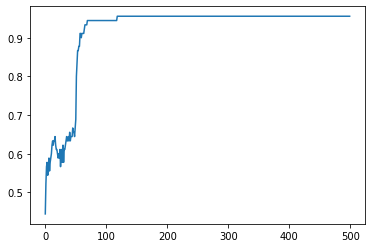

In [66]:
plt.plot(b)

plt.show()

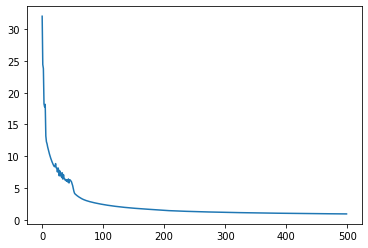

In [68]:
plt.plot(ls)
plt.show()

In [34]:
print("Test accuracy:", acc_test_new,"Test loss",loss_test_new)

Test accuracy: 0.9565 Test loss 0.13721217


# K FOLD CROSS 500

In [36]:
train_data = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/test3_500data.csv', header = None)
train_label = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/test3_500label.csv', header = None)



x_in = np.transpose(train_data.to_numpy())
#x_in = norm(x_in)
y_true=np.transpose(train_label.to_numpy())

y_true_hot = hot_encode(y_true,3)

In [42]:
N = 500
k = 10

cl_no = 3


for act in ['elu','sigmoid']:
    
    loss_per_hid_size = []
    accu_per_hid_size = []
    trial = 0
    
    m,n = 0,0
    print('----------------------------------------------------------------------------------------------------')
    print('ACTIVATION FUNCTION : ',act)
    
    print('----------------------------------------------------------------------------------------------------')
    
    for n_hidden in [1,2,3,4,5,6,7,8,9,10]:

        avg_loss_per_fold = []
        avg_accu_per_fold = []
        
        for fold in range(k):


            batch_size = 10
            X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
            y = tf.placeholder(tf.int32, shape=(None, 3), name="y")


            a2,logits = train_NN(X,y,n_hidden,act)
            '''Starting with finding loss'''
            with tf.name_scope("loss"):
                cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
                '''cost function'''
                loss=tf.reduce_mean(cross_entropy, name="loss")
                '''Minimizing cost function using gradient descent algorithm'''
            
            if act == 'elu':
                learning_rate=0.01
            else:
                learning_rate=0.04

            with tf.name_scope("grad"):
                optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5)
                training_output=optimizer.minimize(loss)
            '''Accuracy:- .in_top_k() function checks if highest logit corresponds to target class'''
            with tf.name_scope("eval"):
                correct_prediction = tf.equal(tf.argmax(a2, 1), tf.argmax(y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            init = tf.global_variables_initializer()

            with tf.Session() as sess:
                init.run()


                validate_data = x_in[fold*(N//k):(fold+1)*(N//k),:]
                train_data = np.concatenate((x_in[:fold*(N//k),:], x_in[(fold+1)*(N//k):,:]), axis = 0)

                validate_label = y_true_hot[fold*(N//k):(fold+1)*(N//k),:]
                train_label = np.concatenate((y_true_hot[:fold*(N//k),:], y_true_hot[(fold+1)*(N//k):,:]), axis = 0)


                n_epochs = 250
                
                for epoch in range(n_epochs):
                    current_batch_no=0
                    epoch_loss = 0
                    #print('--------------------------------------------------------------------------------------')
                    for iteration in range((N-k)//batch_size):
                        epoch_x,epoch_y,current_batch_no = take_next_batch(current_batch_no,train_data,train_label,batch_size)
                        _,L,a2_gat = sess.run([training_output,loss,a2], feed_dict={X: epoch_x, y: epoch_y})
                        epoch_loss += L


                        #acc_train = accuracy.eval(feed_dict={X: epoch_x, y: epoch_y})

                        #print('Loss',L,'Train Accuracy:',acc_train)

                    #acc_train = accuracy.eval(feed_dict={X: train_data, y: train_label})
                    #loss_train = loss.eval(feed_dict={X: train_data, y: train_label})
                    #acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
                    #loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})
                    
                    #print("Epoch", epoch+1, "Train accuracy:", acc_train, "Test accuracy:", acc_test,"Train loss",loss_train,"test loss",loss_test)
                acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
                loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})   
                avg_loss_per_fold.append(loss_test)
                avg_accu_per_fold.append(acc_test)
        
        loss_per_hid_size.append(np.mean(avg_loss_per_fold))
        accu_per_hid_size.append(np.mean(avg_accu_per_fold))
        
        
        print('When the size of hidden layer is ',n_hidden,', the calculated LOSS is ',loss_per_hid_size[m],' and the calculated accuracy is ',accu_per_hid_size[n])
        print('--------------------------------------------------------------------------------------------------')
        
        
        m += 1
        n += 1
        
        tf.compat.v1.reset_default_graph()
            

        

----------------------------------------------------------------------------------------------------
ACTIVATION FUNCTION :  elu
----------------------------------------------------------------------------------------------------
When the size of hidden layer is  1 , the calculated LOSS is  0.97955704  and the calculated accuracy is  0.506
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  2 , the calculated LOSS is  0.5896161  and the calculated accuracy is  0.766
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  3 , the calculated LOSS is  0.43956178  and the calculated accuracy is  0.866
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  4 , the calculated LOSS is  0.14370278  and the calculated accuracy is  0.95199996
----------------------

In [46]:
batch_size = 10
X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None, 3), name="y")

n_hidden = 4

a2,logits = train_NN(X,y,n_hidden,'elu')
'''Starting with finding loss'''
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
    '''cost function'''
    loss=tf.reduce_mean(cross_entropy, name="loss")
    '''Minimizing cost function using gradient descent algorithm'''

learning_rate=0.01

with tf.name_scope("grad"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5)
    training_output=optimizer.minimize(loss)
'''Accuracy:- .in_top_k() function checks if highest logit corresponds to target class'''
with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(a2, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    N = 500
    k = 10
    fold = 1

    #validate_data = x_in[fold*(N//k):(fold+1)*(N//k),:]
    #train_data = np.concatenate((x_in[:fold*(N//k),:], x_in[(fold+1)*(N//k):,:]), axis = 0)

    #validate_label = y_true_hot[fold*(N//k):(fold+1)*(N//k),:]
    #train_label = np.concatenate((y_true_hot[:fold*(N//k),:], y_true_hot[(fold+1)*(N//k):,:]), axis = 0)


    n_epochs = 500
    b_500 = [0]*n_epochs
    c_500 = [0]*n_epochs
    ls_500 = [0]*n_epochs

    for epoch in range(n_epochs):
        current_batch_no=0
        epoch_loss = 0
        print('--------------------------------------------------------------------------------------')
        for iteration in range((N-k)//batch_size):
            epoch_x,epoch_y,current_batch_no = take_next_batch(current_batch_no,x_in,y_true_hot,batch_size)
            _,L,a2_gat = sess.run([training_output,loss,a2], feed_dict={X: epoch_x, y: epoch_y})
            epoch_loss += L


            acc_train = accuracy.eval(feed_dict={X: epoch_x, y: epoch_y})

            print('Loss',L,'Train Accuracy:',acc_train)

        acc_train = accuracy.eval(feed_dict={X: train_data, y: train_label})
        loss_train = loss.eval(feed_dict={X: train_data, y: train_label})
        #acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
        #loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})
        b_500[epoch] = acc_train
        c_500[epoch] = acc_test
        ls_500[epoch]= epoch_loss

        print("Epoch", epoch+1, "Train accuracy:", acc_train,"Train loss",loss_train)
    
    #acc_test_new = []
    #loss_test_new= []
    #[(ami*100):((ami+1)*100),:]
    #for ami in range(10):
    acc_test_new = (accuracy.eval(feed_dict={X: x_test_in, y: y_test_true_hot}))
    loss_test_new= (loss.eval(feed_dict={X: x_test_in, y: y_test_true_hot}))
    


--------------------------------------------------------------------------------------
Loss 3.35461 Train Accuracy: 0.1
Loss 2.0350547 Train Accuracy: 0.3
Loss 15.943784 Train Accuracy: 0.3
Loss 4.394075 Train Accuracy: 0.7
Loss 8.774372 Train Accuracy: 0.7
Loss 6.5721602 Train Accuracy: 0.3
Loss 7.1435814 Train Accuracy: 0.3
Loss 7.7050505 Train Accuracy: 0.4
Loss 1.3683023 Train Accuracy: 0.4
Loss 1.1516238 Train Accuracy: 0.3
Loss 4.210949 Train Accuracy: 0.4
Loss 1.7763264 Train Accuracy: 0.4
Loss 2.6372142 Train Accuracy: 0.4
Loss 1.9030163 Train Accuracy: 0.4
Loss 3.5892487 Train Accuracy: 0.4
Loss 1.2492601 Train Accuracy: 0.6
Loss 2.1577065 Train Accuracy: 0.5
Loss 0.93925905 Train Accuracy: 0.6
Loss 1.618233 Train Accuracy: 0.4
Loss 1.6040757 Train Accuracy: 0.2
Loss 0.87515724 Train Accuracy: 0.6
Loss 0.8897831 Train Accuracy: 0.6
Loss 0.8856255 Train Accuracy: 0.7
Loss 0.7053374 Train Accuracy: 0.6
Loss 1.1355345 Train Accuracy: 0.4
Loss 1.940028 Train Accuracy: 0.5
Loss 0.8

Loss 0.9902054 Train Accuracy: 0.6
Loss 0.80859184 Train Accuracy: 0.6
Loss 0.42590636 Train Accuracy: 0.9
Loss 0.20664725 Train Accuracy: 1.0
Loss 0.34530503 Train Accuracy: 0.9
Loss 0.5690595 Train Accuracy: 0.8
Loss 0.59011894 Train Accuracy: 0.7
Loss 0.42179346 Train Accuracy: 0.9
Loss 0.3184533 Train Accuracy: 1.0
Loss 0.5369038 Train Accuracy: 0.9
Loss 0.36630422 Train Accuracy: 0.9
Loss 0.76317585 Train Accuracy: 0.6
Loss 0.48702472 Train Accuracy: 0.8
Loss 0.40763754 Train Accuracy: 0.9
Loss 0.47901464 Train Accuracy: 0.7
Loss 0.49080858 Train Accuracy: 0.8
Loss 0.48321953 Train Accuracy: 0.8
Loss 0.491565 Train Accuracy: 0.9
Epoch 5 Train accuracy: 0.76222223 Train loss 0.53277665
--------------------------------------------------------------------------------------
Loss 0.5630151 Train Accuracy: 0.7
Loss 0.7369845 Train Accuracy: 0.7
Loss 0.62024957 Train Accuracy: 0.7
Loss 0.50837576 Train Accuracy: 0.6
Loss 0.7066361 Train Accuracy: 0.6
Loss 0.5602229 Train Accuracy: 0.7
Lo

Loss 0.42398366 Train Accuracy: 0.8
Loss 0.56836367 Train Accuracy: 0.8
Loss 0.5417345 Train Accuracy: 0.9
Loss 0.41860667 Train Accuracy: 0.7
Loss 0.643365 Train Accuracy: 0.7
Loss 0.4161481 Train Accuracy: 0.9
Loss 0.2486287 Train Accuracy: 1.0
Loss 0.5186448 Train Accuracy: 0.9
Loss 0.44474182 Train Accuracy: 0.8
Loss 0.5099505 Train Accuracy: 0.8
Loss 0.5552043 Train Accuracy: 0.8
Loss 0.251609 Train Accuracy: 1.0
Loss 0.672722 Train Accuracy: 0.9
Loss 0.52478373 Train Accuracy: 0.7
Loss 0.7169093 Train Accuracy: 0.7
Loss 0.14157407 Train Accuracy: 1.0
Loss 0.54837906 Train Accuracy: 0.7
Loss 0.15197992 Train Accuracy: 1.0
Loss 0.41860408 Train Accuracy: 0.8
Loss 0.4299075 Train Accuracy: 0.9
Loss 0.28247148 Train Accuracy: 0.9
Loss 0.26057726 Train Accuracy: 0.9
Loss 0.35845503 Train Accuracy: 0.9
Loss 0.3835153 Train Accuracy: 0.8
Loss 0.26448056 Train Accuracy: 1.0
Loss 0.51471794 Train Accuracy: 0.8
Loss 0.31323516 Train Accuracy: 0.9
Loss 0.42569438 Train Accuracy: 1.0
Loss 0.

Loss 0.30680084 Train Accuracy: 0.9
Epoch 14 Train accuracy: 0.85444444 Train loss 0.35523683
--------------------------------------------------------------------------------------
Loss 0.3395432 Train Accuracy: 0.9
Loss 0.53443384 Train Accuracy: 0.8
Loss 0.50007933 Train Accuracy: 0.9
Loss 0.3412777 Train Accuracy: 0.8
Loss 0.6027915 Train Accuracy: 0.7
Loss 0.36522925 Train Accuracy: 0.9
Loss 0.19042918 Train Accuracy: 1.0
Loss 0.46408424 Train Accuracy: 0.9
Loss 0.3601454 Train Accuracy: 0.9
Loss 0.4460463 Train Accuracy: 0.8
Loss 0.52708125 Train Accuracy: 0.9
Loss 0.19175471 Train Accuracy: 1.0
Loss 0.5438218 Train Accuracy: 0.9
Loss 0.49072298 Train Accuracy: 0.7
Loss 0.6168466 Train Accuracy: 0.7
Loss 0.10984937 Train Accuracy: 1.0
Loss 0.48029357 Train Accuracy: 0.8
Loss 0.10991682 Train Accuracy: 1.0
Loss 0.34438866 Train Accuracy: 0.8
Loss 0.35084933 Train Accuracy: 0.9
Loss 0.25476184 Train Accuracy: 0.9
Loss 0.22302404 Train Accuracy: 0.9
Loss 0.30486792 Train Accuracy: 0.

Loss 0.1918793 Train Accuracy: 1.0
Loss 0.33036783 Train Accuracy: 0.8
Loss 0.28412804 Train Accuracy: 0.9
Loss 0.21406126 Train Accuracy: 1.0
Loss 0.26830852 Train Accuracy: 0.9
Epoch 19 Train accuracy: 0.87 Train loss 0.3192892
--------------------------------------------------------------------------------------
Loss 0.29671845 Train Accuracy: 1.0
Loss 0.5088668 Train Accuracy: 0.8
Loss 0.46821547 Train Accuracy: 0.9
Loss 0.28722793 Train Accuracy: 1.0
Loss 0.583218 Train Accuracy: 0.7
Loss 0.33630735 Train Accuracy: 0.9
Loss 0.18926711 Train Accuracy: 1.0
Loss 0.5014452 Train Accuracy: 0.9
Loss 0.30183035 Train Accuracy: 0.9
Loss 0.39242524 Train Accuracy: 0.8
Loss 0.45165378 Train Accuracy: 0.9
Loss 0.13747987 Train Accuracy: 1.0
Loss 0.541557 Train Accuracy: 1.0
Loss 0.49204135 Train Accuracy: 0.7
Loss 0.59842366 Train Accuracy: 0.7
Loss 0.09977768 Train Accuracy: 1.0
Loss 0.44883364 Train Accuracy: 0.8
Loss 0.08521457 Train Accuracy: 1.0
Loss 0.30665317 Train Accuracy: 0.9
Loss 

Loss 0.29753986 Train Accuracy: 0.9
Loss 0.2602279 Train Accuracy: 0.9
Loss 0.17905414 Train Accuracy: 1.0
Loss 0.2328867 Train Accuracy: 0.9
Epoch 24 Train accuracy: 0.87333333 Train loss 0.29775017
--------------------------------------------------------------------------------------
Loss 0.25210515 Train Accuracy: 1.0
Loss 0.5018901 Train Accuracy: 0.8
Loss 0.45128006 Train Accuracy: 0.9
Loss 0.24215373 Train Accuracy: 1.0
Loss 0.5629791 Train Accuracy: 0.7
Loss 0.30691698 Train Accuracy: 0.9
Loss 0.22726262 Train Accuracy: 1.0
Loss 0.56568253 Train Accuracy: 0.9
Loss 0.2592008 Train Accuracy: 0.9
Loss 0.37154415 Train Accuracy: 0.9
Loss 0.40958482 Train Accuracy: 0.8
Loss 0.10946188 Train Accuracy: 1.0
Loss 0.5945456 Train Accuracy: 1.0
Loss 0.5647841 Train Accuracy: 0.7
Loss 0.7179929 Train Accuracy: 0.7
Loss 0.09392402 Train Accuracy: 1.0
Loss 0.4365627 Train Accuracy: 0.8
Loss 0.06856832 Train Accuracy: 1.0
Loss 0.2968668 Train Accuracy: 0.9
Loss 0.30308235 Train Accuracy: 0.9
L

Loss 0.18927363 Train Accuracy: 1.0
Loss 0.37745386 Train Accuracy: 0.9
Loss 0.2629032 Train Accuracy: 0.9
Loss 0.34146056 Train Accuracy: 0.8
Loss 0.13550194 Train Accuracy: 1.0
Loss 0.16527289 Train Accuracy: 1.0
Loss 0.27690786 Train Accuracy: 0.9
Loss 0.24514373 Train Accuracy: 0.9
Loss 0.1551133 Train Accuracy: 1.0
Loss 0.20696874 Train Accuracy: 0.9
Epoch 29 Train accuracy: 0.8788889 Train loss 0.28409535
--------------------------------------------------------------------------------------
Loss 0.21763739 Train Accuracy: 1.0
Loss 0.50284946 Train Accuracy: 0.8
Loss 0.4481154 Train Accuracy: 0.9
Loss 0.21196249 Train Accuracy: 1.0
Loss 0.5465861 Train Accuracy: 0.8
Loss 0.28431195 Train Accuracy: 0.9
Loss 0.2453783 Train Accuracy: 1.0
Loss 0.59896594 Train Accuracy: 0.9
Loss 0.23804982 Train Accuracy: 0.9
Loss 0.36594495 Train Accuracy: 0.9
Loss 0.3943238 Train Accuracy: 0.8
Loss 0.100987956 Train Accuracy: 1.0
Loss 0.592582 Train Accuracy: 1.0
Loss 0.5905872 Train Accuracy: 0.7


Loss 0.15752003 Train Accuracy: 0.9
Loss 0.25177538 Train Accuracy: 0.9
Loss 0.50428236 Train Accuracy: 0.8
Loss 0.25597006 Train Accuracy: 0.8
Loss 0.11814712 Train Accuracy: 1.0
Loss 0.18449159 Train Accuracy: 1.0
Loss 0.3721941 Train Accuracy: 0.9
Loss 0.27315536 Train Accuracy: 0.9
Loss 0.33531743 Train Accuracy: 0.8
Loss 0.12902898 Train Accuracy: 1.0
Loss 0.15834025 Train Accuracy: 1.0
Loss 0.26382855 Train Accuracy: 0.9
Loss 0.23587397 Train Accuracy: 0.9
Loss 0.13864222 Train Accuracy: 1.0
Loss 0.19192092 Train Accuracy: 0.9
Epoch 34 Train accuracy: 0.88222224 Train loss 0.27625525
--------------------------------------------------------------------------------------
Loss 0.19735529 Train Accuracy: 1.0
Loss 0.50051415 Train Accuracy: 0.8
Loss 0.44881636 Train Accuracy: 0.9
Loss 0.1911099 Train Accuracy: 1.0
Loss 0.5236567 Train Accuracy: 0.8
Loss 0.27061495 Train Accuracy: 0.9
Loss 0.2199277 Train Accuracy: 1.0
Loss 0.5872262 Train Accuracy: 0.9
Loss 0.23036198 Train Accuracy: 

Loss 0.23069027 Train Accuracy: 0.9
Loss 0.3672916 Train Accuracy: 0.8
Loss 0.37405124 Train Accuracy: 0.8
Loss 0.08005522 Train Accuracy: 1.0
Loss 0.5817664 Train Accuracy: 0.9
Loss 0.5918321 Train Accuracy: 0.7
Loss 0.79467946 Train Accuracy: 0.7
Loss 0.074455336 Train Accuracy: 1.0
Loss 0.40492 Train Accuracy: 0.8
Loss 0.048344966 Train Accuracy: 1.0
Loss 0.26252273 Train Accuracy: 0.9
Loss 0.2650733 Train Accuracy: 0.9
Loss 0.21264473 Train Accuracy: 0.9
Loss 0.18629286 Train Accuracy: 0.9
Loss 0.22447777 Train Accuracy: 0.9
Loss 0.26318544 Train Accuracy: 0.9
Loss 0.13479532 Train Accuracy: 0.9
Loss 0.41652298 Train Accuracy: 1.0
Loss 0.2257493 Train Accuracy: 0.9
Loss 0.30743918 Train Accuracy: 1.0
Loss 0.49410683 Train Accuracy: 0.9
Loss 0.44212097 Train Accuracy: 0.8
Loss 1.2214205 Train Accuracy: 0.6
Loss 1.1598171 Train Accuracy: 0.6
Loss 0.9334075 Train Accuracy: 0.9
Loss 0.188001 Train Accuracy: 0.9
Loss 0.16447769 Train Accuracy: 0.9
Loss 0.25072092 Train Accuracy: 0.9
Los

Loss 0.16021457 Train Accuracy: 1.0
Loss 0.49205798 Train Accuracy: 0.8
Loss 0.250969 Train Accuracy: 0.9
Loss 0.16262822 Train Accuracy: 1.0
Loss 0.5419779 Train Accuracy: 0.9
Loss 0.23624773 Train Accuracy: 0.9
Loss 0.37410137 Train Accuracy: 0.8
Loss 0.36766082 Train Accuracy: 0.8
Loss 0.07144143 Train Accuracy: 1.0
Loss 0.604004 Train Accuracy: 0.9
Loss 0.5885944 Train Accuracy: 0.7
Loss 0.7847837 Train Accuracy: 0.7
Loss 0.061276544 Train Accuracy: 1.0
Loss 0.3939808 Train Accuracy: 0.8
Loss 0.045351136 Train Accuracy: 1.0
Loss 0.2445366 Train Accuracy: 0.9
Loss 0.25256088 Train Accuracy: 0.9
Loss 0.21445353 Train Accuracy: 0.9
Loss 0.18803507 Train Accuracy: 0.9
Loss 0.21785524 Train Accuracy: 0.9
Loss 0.25665298 Train Accuracy: 0.9
Loss 0.12551133 Train Accuracy: 0.9
Loss 0.4297854 Train Accuracy: 1.0
Loss 0.21830595 Train Accuracy: 0.9
Loss 0.29463154 Train Accuracy: 1.0
Loss 0.4717639 Train Accuracy: 0.9
Loss 0.43021098 Train Accuracy: 0.8
Loss 1.1523577 Train Accuracy: 0.6
Lo

Loss 1.168166 Train Accuracy: 0.6
Loss 1.1118485 Train Accuracy: 0.9
Loss 0.19693787 Train Accuracy: 0.9
Loss 0.19070071 Train Accuracy: 0.9
Loss 0.24813056 Train Accuracy: 0.9
Loss 0.4755004 Train Accuracy: 0.8
Loss 0.28031224 Train Accuracy: 0.8
Loss 0.11360631 Train Accuracy: 1.0
Loss 0.17968765 Train Accuracy: 1.0
Loss 0.37404656 Train Accuracy: 0.9
Loss 0.3102232 Train Accuracy: 0.9
Loss 0.33552292 Train Accuracy: 0.8
Loss 0.12839559 Train Accuracy: 0.9
Loss 0.15735722 Train Accuracy: 1.0
Loss 0.23645654 Train Accuracy: 0.9
Loss 0.21991865 Train Accuracy: 0.9
Loss 0.11800134 Train Accuracy: 1.0
Loss 0.15225539 Train Accuracy: 0.9
Epoch 48 Train accuracy: 0.87777776 Train loss 0.26822126
--------------------------------------------------------------------------------------
Loss 0.1684301 Train Accuracy: 1.0
Loss 0.49803677 Train Accuracy: 0.8
Loss 0.46397835 Train Accuracy: 0.9
Loss 0.14680682 Train Accuracy: 1.0
Loss 0.47932434 Train Accuracy: 0.7
Loss 0.24353643 Train Accuracy: 0

Loss 0.3907157 Train Accuracy: 0.7
Loss 0.36062753 Train Accuracy: 0.9
Loss 0.05979185 Train Accuracy: 1.0
Loss 0.6218456 Train Accuracy: 0.9
Loss 0.54815614 Train Accuracy: 0.7
Loss 0.68334067 Train Accuracy: 0.7
Loss 0.047184255 Train Accuracy: 1.0
Loss 0.36755854 Train Accuracy: 0.8
Loss 0.042643316 Train Accuracy: 1.0
Loss 0.21459457 Train Accuracy: 0.9
Loss 0.23147538 Train Accuracy: 0.9
Loss 0.21617794 Train Accuracy: 0.9
Loss 0.19065788 Train Accuracy: 0.9
Loss 0.20647922 Train Accuracy: 0.9
Loss 0.24391286 Train Accuracy: 0.9
Loss 0.109814 Train Accuracy: 1.0
Loss 0.44539317 Train Accuracy: 1.0
Loss 0.20971723 Train Accuracy: 0.9
Loss 0.28683624 Train Accuracy: 1.0
Loss 0.4265855 Train Accuracy: 0.9
Loss 0.40432507 Train Accuracy: 0.8
Loss 1.0686343 Train Accuracy: 0.6
Loss 1.1599389 Train Accuracy: 0.6
Loss 1.1899202 Train Accuracy: 0.9
Loss 0.20154507 Train Accuracy: 0.9
Loss 0.20900472 Train Accuracy: 0.9
Loss 0.24514398 Train Accuracy: 0.9
Loss 0.46061164 Train Accuracy: 0.

Loss 0.10020622 Train Accuracy: 1.0
Loss 0.46871418 Train Accuracy: 0.9
Loss 0.26235375 Train Accuracy: 0.9
Loss 0.40097076 Train Accuracy: 0.8
Loss 0.35723153 Train Accuracy: 0.8
Loss 0.054728024 Train Accuracy: 1.0
Loss 0.61184347 Train Accuracy: 0.9
Loss 0.53349215 Train Accuracy: 0.7
Loss 0.6421478 Train Accuracy: 0.7
Loss 0.045048323 Train Accuracy: 1.0
Loss 0.35525846 Train Accuracy: 0.8
Loss 0.0414746 Train Accuracy: 1.0
Loss 0.20472586 Train Accuracy: 0.9
Loss 0.22869042 Train Accuracy: 0.9
Loss 0.21434183 Train Accuracy: 0.9
Loss 0.19298288 Train Accuracy: 0.9
Loss 0.20176491 Train Accuracy: 0.9
Loss 0.23813184 Train Accuracy: 0.9
Loss 0.10216274 Train Accuracy: 1.0
Loss 0.44725078 Train Accuracy: 1.0
Loss 0.21798888 Train Accuracy: 0.9
Loss 0.2994658 Train Accuracy: 1.0
Loss 0.37937483 Train Accuracy: 0.9
Loss 0.38790607 Train Accuracy: 0.8
Loss 1.1828867 Train Accuracy: 0.6
Loss 1.0399897 Train Accuracy: 0.6
Loss 1.2342807 Train Accuracy: 0.9
Loss 0.20490034 Train Accuracy: 

Loss 0.08125989 Train Accuracy: 1.0
Loss 0.42974654 Train Accuracy: 0.9
Loss 0.27042183 Train Accuracy: 0.9
Loss 0.42532486 Train Accuracy: 0.8
Loss 0.3528666 Train Accuracy: 0.8
Loss 0.05050426 Train Accuracy: 1.0
Loss 0.58988494 Train Accuracy: 0.9
Loss 0.5199571 Train Accuracy: 0.7
Loss 0.6081734 Train Accuracy: 0.7
Loss 0.043405287 Train Accuracy: 1.0
Loss 0.3432346 Train Accuracy: 0.8
Loss 0.041043937 Train Accuracy: 1.0
Loss 0.19557533 Train Accuracy: 0.9
Loss 0.22297876 Train Accuracy: 0.9
Loss 0.21061139 Train Accuracy: 0.9
Loss 0.19158867 Train Accuracy: 0.9
Loss 0.19657053 Train Accuracy: 0.9
Loss 0.22867295 Train Accuracy: 0.9
Loss 0.096862495 Train Accuracy: 1.0
Loss 0.43891492 Train Accuracy: 1.0
Loss 0.21376634 Train Accuracy: 0.9
Loss 0.27984962 Train Accuracy: 1.0
Loss 0.36761302 Train Accuracy: 0.9
Loss 0.37282115 Train Accuracy: 0.8
Loss 1.0847094 Train Accuracy: 0.6
Loss 1.0818858 Train Accuracy: 0.6
Loss 1.3069675 Train Accuracy: 0.9
Loss 0.20468095 Train Accuracy: 

Loss 0.5019337 Train Accuracy: 0.8
Loss 0.2899795 Train Accuracy: 0.9
Loss 0.14393708 Train Accuracy: 1.0
Loss 0.11604041 Train Accuracy: 1.0
Loss 0.32082352 Train Accuracy: 0.9
Loss 0.26528853 Train Accuracy: 0.9
Loss 0.35802516 Train Accuracy: 0.8
Loss 0.10633024 Train Accuracy: 1.0
Loss 0.14400157 Train Accuracy: 1.0
Loss 0.2054958 Train Accuracy: 0.9
Loss 0.20898989 Train Accuracy: 0.9
Loss 0.11471631 Train Accuracy: 1.0
Loss 0.10463993 Train Accuracy: 1.0
Epoch 67 Train accuracy: 0.8755556 Train loss 0.26429644
--------------------------------------------------------------------------------------
Loss 0.17260942 Train Accuracy: 1.0
Loss 0.5186397 Train Accuracy: 0.7
Loss 0.46107215 Train Accuracy: 0.8
Loss 0.11556693 Train Accuracy: 1.0
Loss 0.4725997 Train Accuracy: 0.8
Loss 0.16759627 Train Accuracy: 0.9
Loss 0.05763309 Train Accuracy: 1.0
Loss 0.34473437 Train Accuracy: 0.9
Loss 0.26475552 Train Accuracy: 0.9
Loss 0.43550938 Train Accuracy: 0.8
Loss 0.33575755 Train Accuracy: 0

Loss 0.51458794 Train Accuracy: 0.7
Loss 0.70709336 Train Accuracy: 0.6
Loss 0.055175684 Train Accuracy: 1.0
Loss 0.34843493 Train Accuracy: 0.8
Loss 0.11156223 Train Accuracy: 1.0
Loss 0.22033298 Train Accuracy: 0.9
Loss 0.16481304 Train Accuracy: 1.0
Loss 0.22732262 Train Accuracy: 0.9
Loss 0.1802716 Train Accuracy: 0.9
Loss 0.18601874 Train Accuracy: 0.9
Loss 0.19430807 Train Accuracy: 0.9
Loss 0.12285511 Train Accuracy: 1.0
Loss 0.39016676 Train Accuracy: 1.0
Loss 0.18450265 Train Accuracy: 0.9
Loss 0.35063607 Train Accuracy: 1.0
Loss 0.62726325 Train Accuracy: 1.0
Loss 0.35903996 Train Accuracy: 0.8
Loss 0.57277554 Train Accuracy: 0.7
Loss 1.625715 Train Accuracy: 0.8
Loss 0.747486 Train Accuracy: 0.9
Loss 0.20054221 Train Accuracy: 0.9
Loss 0.29399806 Train Accuracy: 1.0
Loss 0.1927373 Train Accuracy: 0.9
Loss 0.433542 Train Accuracy: 0.9
Loss 0.2874522 Train Accuracy: 0.8
Loss 0.10778467 Train Accuracy: 1.0
Loss 0.073256075 Train Accuracy: 1.0
Loss 0.29789266 Train Accuracy: 0.9

Loss 0.4618588 Train Accuracy: 0.8
Loss 0.18623446 Train Accuracy: 0.9
Loss 0.053728007 Train Accuracy: 1.0
Loss 0.3734045 Train Accuracy: 0.9
Loss 0.296318 Train Accuracy: 0.9
Loss 0.43834347 Train Accuracy: 0.7
Loss 0.30284905 Train Accuracy: 0.8
Loss 0.03596018 Train Accuracy: 1.0
Loss 0.39825252 Train Accuracy: 0.9
Loss 0.48946524 Train Accuracy: 0.7
Loss 0.58866584 Train Accuracy: 0.8
Loss 0.05148896 Train Accuracy: 1.0
Loss 0.3156286 Train Accuracy: 0.8
Loss 0.094601944 Train Accuracy: 1.0
Loss 0.18984988 Train Accuracy: 0.9
Loss 0.18003953 Train Accuracy: 1.0
Loss 0.22948286 Train Accuracy: 0.9
Loss 0.18195081 Train Accuracy: 0.9
Loss 0.18107292 Train Accuracy: 0.9
Loss 0.1967021 Train Accuracy: 0.9
Loss 0.12052055 Train Accuracy: 1.0
Loss 0.34052482 Train Accuracy: 1.0
Loss 0.1817459 Train Accuracy: 0.9
Loss 0.39142886 Train Accuracy: 1.0
Loss 0.5589526 Train Accuracy: 1.0
Loss 0.34052178 Train Accuracy: 0.8
Loss 0.58116317 Train Accuracy: 0.6
Loss 1.7354925 Train Accuracy: 0.7

Loss 0.0974765 Train Accuracy: 1.0
Loss 0.47427946 Train Accuracy: 0.8
Loss 0.2045215 Train Accuracy: 0.9
Loss 0.05595938 Train Accuracy: 1.0
Loss 0.45134336 Train Accuracy: 0.9
Loss 0.33654302 Train Accuracy: 0.9
Loss 0.44167107 Train Accuracy: 0.7
Loss 0.30779964 Train Accuracy: 0.8
Loss 0.032883663 Train Accuracy: 1.0
Loss 0.35234636 Train Accuracy: 0.9
Loss 0.46460217 Train Accuracy: 0.8
Loss 0.5119899 Train Accuracy: 0.8
Loss 0.051944405 Train Accuracy: 1.0
Loss 0.31207025 Train Accuracy: 0.8
Loss 0.110867456 Train Accuracy: 1.0
Loss 0.19430473 Train Accuracy: 0.9
Loss 0.1637827 Train Accuracy: 1.0
Loss 0.22411707 Train Accuracy: 0.9
Loss 0.18618554 Train Accuracy: 0.9
Loss 0.17716673 Train Accuracy: 0.9
Loss 0.18727009 Train Accuracy: 0.9
Loss 0.11733379 Train Accuracy: 1.0
Loss 0.37978867 Train Accuracy: 1.0
Loss 0.17373471 Train Accuracy: 0.9
Loss 0.38108233 Train Accuracy: 1.0
Loss 0.6087596 Train Accuracy: 1.0
Loss 0.33045256 Train Accuracy: 0.8
Loss 0.53695214 Train Accuracy

Loss 0.48056588 Train Accuracy: 0.7
Loss 0.46332717 Train Accuracy: 0.8
Loss 0.094724916 Train Accuracy: 1.0
Loss 0.46875507 Train Accuracy: 0.8
Loss 0.20127515 Train Accuracy: 0.9
Loss 0.054858427 Train Accuracy: 1.0
Loss 0.45667648 Train Accuracy: 0.9
Loss 0.33436447 Train Accuracy: 0.9
Loss 0.44520712 Train Accuracy: 0.7
Loss 0.29054216 Train Accuracy: 0.8
Loss 0.03366952 Train Accuracy: 1.0
Loss 0.27510703 Train Accuracy: 0.9
Loss 0.42843443 Train Accuracy: 0.8
Loss 0.3688982 Train Accuracy: 0.8
Loss 0.046195067 Train Accuracy: 1.0
Loss 0.30487016 Train Accuracy: 0.8
Loss 0.11977269 Train Accuracy: 1.0
Loss 0.19002186 Train Accuracy: 0.9
Loss 0.14426275 Train Accuracy: 1.0
Loss 0.22514863 Train Accuracy: 0.9
Loss 0.1847694 Train Accuracy: 0.9
Loss 0.17392841 Train Accuracy: 0.9
Loss 0.179049 Train Accuracy: 0.9
Loss 0.12593982 Train Accuracy: 1.0
Loss 0.43813044 Train Accuracy: 1.0
Loss 0.16995125 Train Accuracy: 0.9
Loss 0.34356666 Train Accuracy: 1.0
Loss 0.61275446 Train Accurac

Loss 0.46433502 Train Accuracy: 0.7
Loss 0.46201164 Train Accuracy: 0.8
Loss 0.093446635 Train Accuracy: 1.0
Loss 0.44497567 Train Accuracy: 0.8
Loss 0.19814679 Train Accuracy: 0.9
Loss 0.05284846 Train Accuracy: 1.0
Loss 0.41469735 Train Accuracy: 0.9
Loss 0.32127467 Train Accuracy: 0.9
Loss 0.4370772 Train Accuracy: 0.7
Loss 0.2717782 Train Accuracy: 0.9
Loss 0.036772873 Train Accuracy: 1.0
Loss 0.2404828 Train Accuracy: 0.9
Loss 0.4092791 Train Accuracy: 0.8
Loss 0.33462602 Train Accuracy: 0.8
Loss 0.038559057 Train Accuracy: 1.0
Loss 0.28821725 Train Accuracy: 0.8
Loss 0.1141322 Train Accuracy: 1.0
Loss 0.1776276 Train Accuracy: 0.9
Loss 0.14621623 Train Accuracy: 1.0
Loss 0.22338922 Train Accuracy: 0.9
Loss 0.18363129 Train Accuracy: 0.9
Loss 0.16953066 Train Accuracy: 0.9
Loss 0.1737514 Train Accuracy: 0.9
Loss 0.12882546 Train Accuracy: 1.0
Loss 0.42910886 Train Accuracy: 1.0
Loss 0.16409837 Train Accuracy: 0.9
Loss 0.3671518 Train Accuracy: 1.0
Loss 0.5961153 Train Accuracy: 1.

Loss 0.2206128 Train Accuracy: 0.9
Loss 0.40101442 Train Accuracy: 0.8
Loss 0.32090223 Train Accuracy: 0.8
Loss 0.03729938 Train Accuracy: 1.0
Loss 0.26538667 Train Accuracy: 0.8
Loss 0.13228561 Train Accuracy: 1.0
Loss 0.16297144 Train Accuracy: 0.9
Loss 0.14751261 Train Accuracy: 1.0
Loss 0.21537133 Train Accuracy: 0.9
Loss 0.18125054 Train Accuracy: 0.9
Loss 0.1630066 Train Accuracy: 0.9
Loss 0.16866454 Train Accuracy: 0.9
Loss 0.12944558 Train Accuracy: 1.0
Loss 0.43749833 Train Accuracy: 1.0
Loss 0.16349915 Train Accuracy: 0.9
Loss 0.3802975 Train Accuracy: 1.0
Loss 0.5346004 Train Accuracy: 1.0
Loss 0.29557282 Train Accuracy: 0.8
Loss 0.50662565 Train Accuracy: 0.7
Loss 1.7907356 Train Accuracy: 0.8
Loss 0.869104 Train Accuracy: 0.9
Loss 0.21214779 Train Accuracy: 0.9
Loss 0.318476 Train Accuracy: 1.0
Loss 0.16638665 Train Accuracy: 0.9
Loss 0.4495593 Train Accuracy: 0.9
Loss 0.26454693 Train Accuracy: 0.8
Loss 0.1048463 Train Accuracy: 1.0
Loss 0.06008921 Train Accuracy: 1.0
Los

Loss 0.1517506 Train Accuracy: 0.9
Loss 0.14662391 Train Accuracy: 1.0
Loss 0.2098877 Train Accuracy: 0.9
Loss 0.18788074 Train Accuracy: 0.9
Loss 0.15724573 Train Accuracy: 0.9
Loss 0.16826811 Train Accuracy: 0.9
Loss 0.12531623 Train Accuracy: 1.0
Loss 0.46435562 Train Accuracy: 1.0
Loss 0.16197607 Train Accuracy: 0.9
Loss 0.3997735 Train Accuracy: 1.0
Loss 0.49531737 Train Accuracy: 1.0
Loss 0.2764445 Train Accuracy: 0.8
Loss 0.53703076 Train Accuracy: 0.6
Loss 1.9112263 Train Accuracy: 0.7
Loss 1.060051 Train Accuracy: 0.9
Loss 0.21702048 Train Accuracy: 0.9
Loss 0.23335715 Train Accuracy: 0.9
Loss 0.16025348 Train Accuracy: 0.9
Loss 0.5562366 Train Accuracy: 0.8
Loss 0.2453074 Train Accuracy: 0.9
Loss 0.0768159 Train Accuracy: 1.0
Loss 0.066255935 Train Accuracy: 1.0
Loss 0.21702814 Train Accuracy: 0.9
Loss 0.28093988 Train Accuracy: 1.0
Loss 0.30645096 Train Accuracy: 0.8
Loss 0.09317774 Train Accuracy: 1.0
Loss 0.09105711 Train Accuracy: 1.0
Loss 0.16424789 Train Accuracy: 0.9
L

Loss 0.158708 Train Accuracy: 0.9
Loss 0.41421777 Train Accuracy: 1.0
Loss 0.48176986 Train Accuracy: 1.0
Loss 0.263095 Train Accuracy: 0.8
Loss 0.5335279 Train Accuracy: 0.6
Loss 1.9729944 Train Accuracy: 0.7
Loss 1.1122715 Train Accuracy: 0.9
Loss 0.21949455 Train Accuracy: 0.9
Loss 0.22480921 Train Accuracy: 0.9
Loss 0.15371652 Train Accuracy: 0.9
Loss 0.56599045 Train Accuracy: 0.8
Loss 0.23780823 Train Accuracy: 0.9
Loss 0.07845898 Train Accuracy: 1.0
Loss 0.066450275 Train Accuracy: 1.0
Loss 0.20558116 Train Accuracy: 0.9
Loss 0.269831 Train Accuracy: 1.0
Loss 0.2966044 Train Accuracy: 0.8
Loss 0.087901644 Train Accuracy: 1.0
Loss 0.08561312 Train Accuracy: 1.0
Loss 0.15547852 Train Accuracy: 0.9
Loss 0.16375741 Train Accuracy: 0.9
Loss 0.07301006 Train Accuracy: 1.0
Loss 0.10823558 Train Accuracy: 1.0
Epoch 107 Train accuracy: 0.88666666 Train loss 0.21605235
--------------------------------------------------------------------------------------
Loss 0.12924135 Train Accuracy: 1.

Loss 0.24943109 Train Accuracy: 0.7
Loss 0.53855926 Train Accuracy: 0.6
Loss 2.0487957 Train Accuracy: 0.6
Loss 1.1592234 Train Accuracy: 0.9
Loss 0.21929204 Train Accuracy: 0.9
Loss 0.20731871 Train Accuracy: 0.9
Loss 0.14672132 Train Accuracy: 0.9
Loss 0.5939168 Train Accuracy: 0.8
Loss 0.2296412 Train Accuracy: 0.9
Loss 0.07938348 Train Accuracy: 1.0
Loss 0.0680999 Train Accuracy: 1.0
Loss 0.19857189 Train Accuracy: 0.9
Loss 0.24034886 Train Accuracy: 1.0
Loss 0.2863909 Train Accuracy: 0.8
Loss 0.07841082 Train Accuracy: 1.0
Loss 0.07946975 Train Accuracy: 1.0
Loss 0.14638135 Train Accuracy: 0.9
Loss 0.15904632 Train Accuracy: 0.9
Loss 0.07294232 Train Accuracy: 1.0
Loss 0.10431007 Train Accuracy: 1.0
Epoch 112 Train accuracy: 0.88666666 Train loss 0.21145245
--------------------------------------------------------------------------------------
Loss 0.12851743 Train Accuracy: 1.0
Loss 0.36563292 Train Accuracy: 0.7
Loss 0.34985933 Train Accuracy: 0.9
Loss 0.11084588 Train Accuracy: 

Loss 0.5568315 Train Accuracy: 0.6
Loss 2.146376 Train Accuracy: 0.6
Loss 1.2115369 Train Accuracy: 0.9
Loss 0.21807711 Train Accuracy: 0.9
Loss 0.1734443 Train Accuracy: 0.9
Loss 0.14043143 Train Accuracy: 0.9
Loss 0.64775497 Train Accuracy: 0.8
Loss 0.22298782 Train Accuracy: 0.9
Loss 0.08122366 Train Accuracy: 1.0
Loss 0.0745229 Train Accuracy: 1.0
Loss 0.19780031 Train Accuracy: 0.9
Loss 0.20250861 Train Accuracy: 0.9
Loss 0.27638617 Train Accuracy: 0.8
Loss 0.06765063 Train Accuracy: 1.0
Loss 0.07297656 Train Accuracy: 1.0
Loss 0.13954476 Train Accuracy: 0.9
Loss 0.15469238 Train Accuracy: 0.9
Loss 0.07187438 Train Accuracy: 1.0
Loss 0.103387795 Train Accuracy: 1.0
Epoch 117 Train accuracy: 0.8877778 Train loss 0.20627229
--------------------------------------------------------------------------------------
Loss 0.1257192 Train Accuracy: 1.0
Loss 0.34898823 Train Accuracy: 0.7
Loss 0.34799471 Train Accuracy: 0.9
Loss 0.10872893 Train Accuracy: 1.0
Loss 0.33271262 Train Accuracy: 0

Loss 0.21859081 Train Accuracy: 0.9
Loss 0.082542464 Train Accuracy: 1.0
Loss 0.07991453 Train Accuracy: 1.0
Loss 0.19542031 Train Accuracy: 0.9
Loss 0.19202383 Train Accuracy: 0.9
Loss 0.26905626 Train Accuracy: 0.8
Loss 0.06371259 Train Accuracy: 1.0
Loss 0.06881665 Train Accuracy: 1.0
Loss 0.137405 Train Accuracy: 0.9
Loss 0.15179513 Train Accuracy: 0.9
Loss 0.07161294 Train Accuracy: 1.0
Loss 0.103804484 Train Accuracy: 1.0
Epoch 122 Train accuracy: 0.88666666 Train loss 0.20259917
--------------------------------------------------------------------------------------
Loss 0.1228479 Train Accuracy: 1.0
Loss 0.3364293 Train Accuracy: 0.7
Loss 0.34916502 Train Accuracy: 0.9
Loss 0.10607276 Train Accuracy: 1.0
Loss 0.3220188 Train Accuracy: 0.8
Loss 0.12748167 Train Accuracy: 1.0
Loss 0.055662513 Train Accuracy: 1.0
Loss 0.44174308 Train Accuracy: 0.9
Loss 0.19719851 Train Accuracy: 0.9
Loss 0.3870996 Train Accuracy: 0.7
Loss 0.17769459 Train Accuracy: 0.9
Loss 0.039371602 Train Accura

Loss 0.19620135 Train Accuracy: 0.9
Loss 0.26386788 Train Accuracy: 0.8
Loss 0.063259445 Train Accuracy: 1.0
Loss 0.06666927 Train Accuracy: 1.0
Loss 0.13484243 Train Accuracy: 0.9
Loss 0.14975956 Train Accuracy: 0.9
Loss 0.07250135 Train Accuracy: 1.0
Loss 0.10145036 Train Accuracy: 1.0
Epoch 127 Train accuracy: 0.89111114 Train loss 0.20093848
--------------------------------------------------------------------------------------
Loss 0.123723745 Train Accuracy: 1.0
Loss 0.32496643 Train Accuracy: 0.7
Loss 0.3492344 Train Accuracy: 0.9
Loss 0.10286437 Train Accuracy: 1.0
Loss 0.31396204 Train Accuracy: 0.8
Loss 0.118857816 Train Accuracy: 1.0
Loss 0.05704671 Train Accuracy: 1.0
Loss 0.42999154 Train Accuracy: 0.9
Loss 0.19335382 Train Accuracy: 0.9
Loss 0.38399172 Train Accuracy: 0.7
Loss 0.17049602 Train Accuracy: 0.9
Loss 0.038399164 Train Accuracy: 1.0
Loss 0.14279284 Train Accuracy: 0.9
Loss 0.31524155 Train Accuracy: 0.8
Loss 0.23944274 Train Accuracy: 0.8
Loss 0.04067848 Train A

Loss 0.06535621 Train Accuracy: 1.0
Loss 0.13558118 Train Accuracy: 0.9
Loss 0.14900433 Train Accuracy: 0.9
Loss 0.0737832 Train Accuracy: 1.0
Loss 0.09975559 Train Accuracy: 1.0
Epoch 132 Train accuracy: 0.89 Train loss 0.19970946
--------------------------------------------------------------------------------------
Loss 0.1241224 Train Accuracy: 1.0
Loss 0.31233191 Train Accuracy: 0.7
Loss 0.3530978 Train Accuracy: 0.8
Loss 0.09755757 Train Accuracy: 1.0
Loss 0.3106596 Train Accuracy: 0.8
Loss 0.105331585 Train Accuracy: 1.0
Loss 0.05878135 Train Accuracy: 1.0
Loss 0.41564694 Train Accuracy: 0.9
Loss 0.19132762 Train Accuracy: 0.9
Loss 0.3837837 Train Accuracy: 0.7
Loss 0.16342056 Train Accuracy: 0.9
Loss 0.037997145 Train Accuracy: 1.0
Loss 0.12939422 Train Accuracy: 0.9
Loss 0.31122524 Train Accuracy: 0.8
Loss 0.23528545 Train Accuracy: 0.8
Loss 0.039763648 Train Accuracy: 1.0
Loss 0.19185498 Train Accuracy: 0.8
Loss 0.10057123 Train Accuracy: 1.0
Loss 0.1329169 Train Accuracy: 0.9

Loss 0.15031429 Train Accuracy: 0.9
Loss 0.07549432 Train Accuracy: 1.0
Loss 0.09817239 Train Accuracy: 1.0
Epoch 137 Train accuracy: 0.88666666 Train loss 0.19938456
--------------------------------------------------------------------------------------
Loss 0.123592734 Train Accuracy: 1.0
Loss 0.29836065 Train Accuracy: 0.7
Loss 0.35106072 Train Accuracy: 0.8
Loss 0.08997619 Train Accuracy: 1.0
Loss 0.32038242 Train Accuracy: 0.8
Loss 0.0920429 Train Accuracy: 1.0
Loss 0.06078552 Train Accuracy: 1.0
Loss 0.40817326 Train Accuracy: 0.9
Loss 0.19343111 Train Accuracy: 0.9
Loss 0.38695645 Train Accuracy: 0.7
Loss 0.15615542 Train Accuracy: 0.9
Loss 0.037559472 Train Accuracy: 1.0
Loss 0.119556114 Train Accuracy: 0.9
Loss 0.31262267 Train Accuracy: 0.8
Loss 0.23195386 Train Accuracy: 0.8
Loss 0.038626507 Train Accuracy: 1.0
Loss 0.18755443 Train Accuracy: 0.8
Loss 0.105463125 Train Accuracy: 1.0
Loss 0.13341394 Train Accuracy: 0.9
Loss 0.13211438 Train Accuracy: 1.0
Loss 0.19229214 Train 

Loss 0.06703992 Train Accuracy: 1.0
Loss 0.14826539 Train Accuracy: 0.9
Loss 0.1503161 Train Accuracy: 0.9
Loss 0.076102495 Train Accuracy: 1.0
Loss 0.09858759 Train Accuracy: 1.0
Epoch 142 Train accuracy: 0.88666666 Train loss 0.1996557
--------------------------------------------------------------------------------------
Loss 0.122691534 Train Accuracy: 1.0
Loss 0.28729424 Train Accuracy: 0.7
Loss 0.34663492 Train Accuracy: 0.8
Loss 0.08592318 Train Accuracy: 1.0
Loss 0.324951 Train Accuracy: 0.8
Loss 0.08559118 Train Accuracy: 1.0
Loss 0.062155508 Train Accuracy: 1.0
Loss 0.40931278 Train Accuracy: 0.9
Loss 0.19471142 Train Accuracy: 0.9
Loss 0.3875348 Train Accuracy: 0.7
Loss 0.14964977 Train Accuracy: 0.9
Loss 0.036900662 Train Accuracy: 1.0
Loss 0.11468456 Train Accuracy: 0.9
Loss 0.304725 Train Accuracy: 0.8
Loss 0.22867818 Train Accuracy: 0.8
Loss 0.04051274 Train Accuracy: 1.0
Loss 0.18272111 Train Accuracy: 0.8
Loss 0.101867065 Train Accuracy: 1.0
Loss 0.13572636 Train Accura

Loss 0.06729163 Train Accuracy: 1.0
Loss 0.15521188 Train Accuracy: 0.9
Loss 0.15048698 Train Accuracy: 0.9
Loss 0.0769665 Train Accuracy: 1.0
Loss 0.09844246 Train Accuracy: 1.0
Epoch 147 Train accuracy: 0.88666666 Train loss 0.20041905
--------------------------------------------------------------------------------------
Loss 0.12424348 Train Accuracy: 1.0
Loss 0.278059 Train Accuracy: 0.7
Loss 0.34410176 Train Accuracy: 0.8
Loss 0.08220379 Train Accuracy: 1.0
Loss 0.32769665 Train Accuracy: 0.8
Loss 0.07914357 Train Accuracy: 1.0
Loss 0.06276604 Train Accuracy: 1.0
Loss 0.41001892 Train Accuracy: 0.9
Loss 0.19286664 Train Accuracy: 0.9
Loss 0.38729748 Train Accuracy: 0.7
Loss 0.14423244 Train Accuracy: 0.9
Loss 0.036338955 Train Accuracy: 1.0
Loss 0.11195786 Train Accuracy: 1.0
Loss 0.2925387 Train Accuracy: 0.8
Loss 0.2284133 Train Accuracy: 0.8
Loss 0.04297228 Train Accuracy: 1.0
Loss 0.17910407 Train Accuracy: 0.8
Loss 0.0982873 Train Accuracy: 1.0
Loss 0.13512047 Train Accuracy:

Loss 0.042837285 Train Accuracy: 1.0
Loss 0.17731553 Train Accuracy: 1.0
Loss 0.09586759 Train Accuracy: 1.0
Loss 0.13359204 Train Accuracy: 0.9
Loss 0.12939465 Train Accuracy: 1.0
Loss 0.18744557 Train Accuracy: 1.0
Loss 0.19269755 Train Accuracy: 0.9
Loss 0.12852421 Train Accuracy: 0.9
Loss 0.1279011 Train Accuracy: 0.9
Loss 0.15197141 Train Accuracy: 0.9
Loss 0.527614 Train Accuracy: 1.0
Loss 0.14170967 Train Accuracy: 0.9
Loss 0.6413251 Train Accuracy: 1.0
Loss 0.44103616 Train Accuracy: 1.0
Loss 0.19324397 Train Accuracy: 1.0
Loss 0.56519234 Train Accuracy: 0.6
Loss 1.735623 Train Accuracy: 0.6
Loss 1.3077097 Train Accuracy: 0.9
Loss 0.21906736 Train Accuracy: 0.9
Loss 0.1130115 Train Accuracy: 0.9
Loss 0.116793826 Train Accuracy: 0.9
Loss 0.98395634 Train Accuracy: 0.8
Loss 0.19168186 Train Accuracy: 0.9
Loss 0.066469885 Train Accuracy: 1.0
Loss 0.06051115 Train Accuracy: 1.0
Loss 0.13391145 Train Accuracy: 0.9
Loss 0.33341447 Train Accuracy: 0.9
Loss 0.2402484 Train Accuracy: 0.

Loss 0.38518927 Train Accuracy: 0.8
Loss 0.13420582 Train Accuracy: 1.0
Loss 0.037230816 Train Accuracy: 1.0
Loss 0.107173644 Train Accuracy: 1.0
Loss 0.26674888 Train Accuracy: 0.9
Loss 0.23833828 Train Accuracy: 0.9
Loss 0.041598503 Train Accuracy: 1.0
Loss 0.17350914 Train Accuracy: 1.0
Loss 0.09293815 Train Accuracy: 1.0
Loss 0.1289556 Train Accuracy: 1.0
Loss 0.12741163 Train Accuracy: 1.0
Loss 0.18270054 Train Accuracy: 1.0
Loss 0.19085759 Train Accuracy: 0.9
Loss 0.1289765 Train Accuracy: 0.9
Loss 0.11964096 Train Accuracy: 0.9
Loss 0.1581427 Train Accuracy: 0.9
Loss 0.5073117 Train Accuracy: 1.0
Loss 0.14439313 Train Accuracy: 0.9
Loss 0.65905 Train Accuracy: 1.0
Loss 0.40688014 Train Accuracy: 1.0
Loss 0.18957311 Train Accuracy: 1.0
Loss 0.59434605 Train Accuracy: 0.6
Loss 1.5737693 Train Accuracy: 0.6
Loss 1.3638163 Train Accuracy: 0.9
Loss 0.21550302 Train Accuracy: 0.9
Loss 0.0929036 Train Accuracy: 0.9
Loss 0.11448892 Train Accuracy: 0.9
Loss 1.0305357 Train Accuracy: 0.8


Loss 0.38000366 Train Accuracy: 0.8
Loss 0.12973519 Train Accuracy: 1.0
Loss 0.037055366 Train Accuracy: 1.0
Loss 0.104600154 Train Accuracy: 1.0
Loss 0.25483018 Train Accuracy: 0.9
Loss 0.23935226 Train Accuracy: 0.9
Loss 0.04223925 Train Accuracy: 1.0
Loss 0.1690857 Train Accuracy: 1.0
Loss 0.08990544 Train Accuracy: 1.0
Loss 0.1246991 Train Accuracy: 1.0
Loss 0.1253032 Train Accuracy: 1.0
Loss 0.17696199 Train Accuracy: 1.0
Loss 0.1874249 Train Accuracy: 0.9
Loss 0.12782505 Train Accuracy: 1.0
Loss 0.113349915 Train Accuracy: 0.9
Loss 0.1597034 Train Accuracy: 0.9
Loss 0.50567824 Train Accuracy: 1.0
Loss 0.14648655 Train Accuracy: 0.9
Loss 0.6743556 Train Accuracy: 1.0
Loss 0.37532297 Train Accuracy: 1.0
Loss 0.18352956 Train Accuracy: 1.0
Loss 0.6421634 Train Accuracy: 0.6
Loss 1.4184235 Train Accuracy: 0.6
Loss 1.4299757 Train Accuracy: 0.9
Loss 0.21433921 Train Accuracy: 0.9
Loss 0.06498601 Train Accuracy: 1.0
Loss 0.11114619 Train Accuracy: 0.9
Loss 1.0191818 Train Accuracy: 0.8

Loss 0.12676176 Train Accuracy: 1.0
Loss 0.036724813 Train Accuracy: 1.0
Loss 0.10149248 Train Accuracy: 1.0
Loss 0.2426292 Train Accuracy: 0.9
Loss 0.23712516 Train Accuracy: 0.9
Loss 0.044023886 Train Accuracy: 1.0
Loss 0.16386013 Train Accuracy: 1.0
Loss 0.086430326 Train Accuracy: 1.0
Loss 0.12098477 Train Accuracy: 1.0
Loss 0.12408741 Train Accuracy: 1.0
Loss 0.16971397 Train Accuracy: 1.0
Loss 0.18395205 Train Accuracy: 0.9
Loss 0.124840796 Train Accuracy: 1.0
Loss 0.108508766 Train Accuracy: 1.0
Loss 0.15841797 Train Accuracy: 0.9
Loss 0.51754034 Train Accuracy: 1.0
Loss 0.14755881 Train Accuracy: 0.9
Loss 0.6965126 Train Accuracy: 1.0
Loss 0.34695596 Train Accuracy: 1.0
Loss 0.17578855 Train Accuracy: 1.0
Loss 0.6830036 Train Accuracy: 0.6
Loss 1.2840626 Train Accuracy: 0.6
Loss 1.4895946 Train Accuracy: 0.9
Loss 0.21481366 Train Accuracy: 0.9
Loss 0.03948216 Train Accuracy: 1.0
Loss 0.10564576 Train Accuracy: 0.9
Loss 0.91787875 Train Accuracy: 0.9
Loss 0.18965887 Train Accura

Loss 0.23408878 Train Accuracy: 0.9
Loss 0.044312842 Train Accuracy: 1.0
Loss 0.15782292 Train Accuracy: 1.0
Loss 0.08327697 Train Accuracy: 1.0
Loss 0.1167958 Train Accuracy: 1.0
Loss 0.12296287 Train Accuracy: 1.0
Loss 0.16061978 Train Accuracy: 1.0
Loss 0.1800255 Train Accuracy: 0.9
Loss 0.12052791 Train Accuracy: 1.0
Loss 0.103522494 Train Accuracy: 1.0
Loss 0.15466627 Train Accuracy: 0.9
Loss 0.5360639 Train Accuracy: 1.0
Loss 0.1478715 Train Accuracy: 0.9
Loss 0.7138806 Train Accuracy: 1.0
Loss 0.31792232 Train Accuracy: 1.0
Loss 0.16682057 Train Accuracy: 1.0
Loss 0.7134038 Train Accuracy: 0.7
Loss 1.1770172 Train Accuracy: 0.6
Loss 1.5471773 Train Accuracy: 0.9
Loss 0.21509922 Train Accuracy: 0.8
Loss 0.02715849 Train Accuracy: 1.0
Loss 0.10032062 Train Accuracy: 0.9
Loss 0.7836055 Train Accuracy: 0.9
Loss 0.19330482 Train Accuracy: 0.8
Loss 0.06361467 Train Accuracy: 1.0
Loss 0.035028566 Train Accuracy: 1.0
Loss 0.09670046 Train Accuracy: 0.9
Loss 0.39761302 Train Accuracy: 0.

Loss 0.14977194 Train Accuracy: 1.0
Loss 0.5585303 Train Accuracy: 1.0
Loss 0.14753616 Train Accuracy: 0.9
Loss 0.7233709 Train Accuracy: 1.0
Loss 0.29030585 Train Accuracy: 1.0
Loss 0.15744276 Train Accuracy: 1.0
Loss 0.73563534 Train Accuracy: 0.7
Loss 1.0979897 Train Accuracy: 0.7
Loss 1.5978806 Train Accuracy: 0.9
Loss 0.21262828 Train Accuracy: 0.8
Loss 0.02309437 Train Accuracy: 1.0
Loss 0.09823227 Train Accuracy: 0.9
Loss 0.6912915 Train Accuracy: 1.0
Loss 0.19600292 Train Accuracy: 0.9
Loss 0.06405776 Train Accuracy: 1.0
Loss 0.030424874 Train Accuracy: 1.0
Loss 0.09078496 Train Accuracy: 1.0
Loss 0.41059288 Train Accuracy: 0.9
Loss 0.21526691 Train Accuracy: 0.9
Loss 0.033723485 Train Accuracy: 1.0
Loss 0.050928105 Train Accuracy: 1.0
Loss 0.12433491 Train Accuracy: 1.0
Loss 0.15323882 Train Accuracy: 1.0
Loss 0.07506576 Train Accuracy: 1.0
Loss 0.06451152 Train Accuracy: 1.0
Epoch 177 Train accuracy: 0.9522222 Train loss 0.18108134
--------------------------------------------

Loss 0.16438842 Train Accuracy: 0.9
Loss 0.6711946 Train Accuracy: 1.0
Loss 0.25756294 Train Accuracy: 1.0
Loss 0.17477758 Train Accuracy: 1.0
Loss 0.730062 Train Accuracy: 0.7
Loss 0.99593127 Train Accuracy: 0.7
Loss 1.6489146 Train Accuracy: 0.9
Loss 0.21283646 Train Accuracy: 0.8
Loss 0.020385886 Train Accuracy: 1.0
Loss 0.09651977 Train Accuracy: 0.9
Loss 0.38538358 Train Accuracy: 0.9
Loss 0.2017233 Train Accuracy: 0.9
Loss 0.09866485 Train Accuracy: 1.0
Loss 0.01836896 Train Accuracy: 1.0
Loss 0.08638743 Train Accuracy: 1.0
Loss 0.16870534 Train Accuracy: 1.0
Loss 0.19688457 Train Accuracy: 1.0
Loss 0.027555216 Train Accuracy: 1.0
Loss 0.03782972 Train Accuracy: 1.0
Loss 0.07322964 Train Accuracy: 1.0
Loss 0.16039781 Train Accuracy: 1.0
Loss 0.05590502 Train Accuracy: 1.0
Loss 0.048272304 Train Accuracy: 1.0
Epoch 182 Train accuracy: 0.96444446 Train loss 0.15009327
--------------------------------------------------------------------------------------
Loss 0.06666535 Train Accura

Loss 0.19195898 Train Accuracy: 0.8
Loss 0.02097929 Train Accuracy: 1.0
Loss 0.1023723 Train Accuracy: 0.9
Loss 0.7163278 Train Accuracy: 1.0
Loss 0.1924564 Train Accuracy: 0.9
Loss 0.061291695 Train Accuracy: 1.0
Loss 0.03657117 Train Accuracy: 1.0
Loss 0.13106284 Train Accuracy: 1.0
Loss 0.36366707 Train Accuracy: 1.0
Loss 0.21366164 Train Accuracy: 0.9
Loss 0.036581807 Train Accuracy: 1.0
Loss 0.030589368 Train Accuracy: 1.0
Loss 0.08983265 Train Accuracy: 1.0
Loss 0.15989038 Train Accuracy: 1.0
Loss 0.10676054 Train Accuracy: 1.0
Loss 0.061898787 Train Accuracy: 1.0
Epoch 187 Train accuracy: 0.93666667 Train loss 0.23147376
--------------------------------------------------------------------------------------
Loss 0.25847977 Train Accuracy: 1.0
Loss 0.19488108 Train Accuracy: 1.0
Loss 0.35080686 Train Accuracy: 0.8
Loss 0.052873828 Train Accuracy: 1.0
Loss 0.26278305 Train Accuracy: 0.9
Loss 0.025371024 Train Accuracy: 1.0
Loss 0.08908922 Train Accuracy: 1.0
Loss 0.2849881 Train Ac

Loss 0.1911441 Train Accuracy: 0.9
Loss 0.062836416 Train Accuracy: 1.0
Loss 0.01942116 Train Accuracy: 1.0
Loss 0.07418757 Train Accuracy: 1.0
Loss 0.3359274 Train Accuracy: 1.0
Loss 0.20056517 Train Accuracy: 0.9
Loss 0.024022983 Train Accuracy: 1.0
Loss 0.028533509 Train Accuracy: 1.0
Loss 0.0943425 Train Accuracy: 1.0
Loss 0.15786037 Train Accuracy: 1.0
Loss 0.06970725 Train Accuracy: 1.0
Loss 0.051743895 Train Accuracy: 1.0
Epoch 192 Train accuracy: 0.96555555 Train loss 0.14728388
--------------------------------------------------------------------------------------
Loss 0.062514395 Train Accuracy: 1.0
Loss 0.17816795 Train Accuracy: 1.0
Loss 0.33840778 Train Accuracy: 0.8
Loss 0.05411812 Train Accuracy: 1.0
Loss 0.20255117 Train Accuracy: 0.9
Loss 0.03320479 Train Accuracy: 1.0
Loss 0.04951903 Train Accuracy: 1.0
Loss 0.20109887 Train Accuracy: 1.0
Loss 0.097735986 Train Accuracy: 1.0
Loss 0.29744285 Train Accuracy: 0.9
Loss 0.12972468 Train Accuracy: 1.0
Loss 0.029631842 Train 

Loss 0.06497543 Train Accuracy: 1.0
Loss 0.22030981 Train Accuracy: 1.0
Loss 0.19250366 Train Accuracy: 0.9
Loss 0.021371406 Train Accuracy: 1.0
Loss 0.026049402 Train Accuracy: 1.0
Loss 0.073436856 Train Accuracy: 1.0
Loss 0.16369481 Train Accuracy: 1.0
Loss 0.061861955 Train Accuracy: 1.0
Loss 0.054094035 Train Accuracy: 1.0
Epoch 197 Train accuracy: 0.9688889 Train loss 0.13693714
--------------------------------------------------------------------------------------
Loss 0.05722152 Train Accuracy: 1.0
Loss 0.15985163 Train Accuracy: 1.0
Loss 0.3194483 Train Accuracy: 0.8
Loss 0.052910827 Train Accuracy: 1.0
Loss 0.19001491 Train Accuracy: 0.9
Loss 0.027943289 Train Accuracy: 1.0
Loss 0.038801834 Train Accuracy: 1.0
Loss 0.15181029 Train Accuracy: 1.0
Loss 0.07875086 Train Accuracy: 1.0
Loss 0.28715435 Train Accuracy: 0.9
Loss 0.14646849 Train Accuracy: 1.0
Loss 0.028842902 Train Accuracy: 1.0
Loss 0.06832274 Train Accuracy: 1.0
Loss 0.17115203 Train Accuracy: 0.9
Loss 0.20576672 Tra

Loss 0.027492538 Train Accuracy: 1.0
Loss 0.042741433 Train Accuracy: 1.0
Epoch 202 Train accuracy: 0.96666664 Train loss 0.13039786
--------------------------------------------------------------------------------------
Loss 0.06524341 Train Accuracy: 1.0
Loss 0.15823999 Train Accuracy: 1.0
Loss 0.31130505 Train Accuracy: 0.8
Loss 0.054813355 Train Accuracy: 1.0
Loss 0.17494856 Train Accuracy: 0.9
Loss 0.023399401 Train Accuracy: 1.0
Loss 0.032256357 Train Accuracy: 1.0
Loss 0.122026384 Train Accuracy: 1.0
Loss 0.061728466 Train Accuracy: 1.0
Loss 0.25975478 Train Accuracy: 0.9
Loss 0.16816652 Train Accuracy: 1.0
Loss 0.023825279 Train Accuracy: 1.0
Loss 0.059072327 Train Accuracy: 1.0
Loss 0.17110665 Train Accuracy: 0.9
Loss 0.20759025 Train Accuracy: 0.9
Loss 0.038959645 Train Accuracy: 1.0
Loss 0.119678 Train Accuracy: 1.0
Loss 0.052882414 Train Accuracy: 1.0
Loss 0.0953079 Train Accuracy: 1.0
Loss 0.13700965 Train Accuracy: 1.0
Loss 0.11080392 Train Accuracy: 1.0
Loss 0.16089551 Tr

Loss 0.30819038 Train Accuracy: 0.8
Loss 0.05226568 Train Accuracy: 1.0
Loss 0.15688303 Train Accuracy: 0.9
Loss 0.021764334 Train Accuracy: 1.0
Loss 0.031125432 Train Accuracy: 1.0
Loss 0.117876664 Train Accuracy: 1.0
Loss 0.060009003 Train Accuracy: 1.0
Loss 0.25272807 Train Accuracy: 0.9
Loss 0.16351974 Train Accuracy: 1.0
Loss 0.02171748 Train Accuracy: 1.0
Loss 0.054029733 Train Accuracy: 1.0
Loss 0.16114348 Train Accuracy: 0.9
Loss 0.2104466 Train Accuracy: 0.9
Loss 0.036312312 Train Accuracy: 1.0
Loss 0.11438346 Train Accuracy: 1.0
Loss 0.049768977 Train Accuracy: 1.0
Loss 0.093570694 Train Accuracy: 1.0
Loss 0.13850704 Train Accuracy: 1.0
Loss 0.10774356 Train Accuracy: 1.0
Loss 0.16009131 Train Accuracy: 0.9
Loss 0.098600484 Train Accuracy: 1.0
Loss 0.068557784 Train Accuracy: 1.0
Loss 0.109249316 Train Accuracy: 1.0
Loss 0.6334132 Train Accuracy: 1.0
Loss 0.15273854 Train Accuracy: 0.8
Loss 0.91322136 Train Accuracy: 1.0
Loss 0.27701998 Train Accuracy: 1.0
Loss 0.11069678 Tra

Loss 0.13894588 Train Accuracy: 0.9
Loss 0.016919352 Train Accuracy: 1.0
Loss 0.035860695 Train Accuracy: 1.0
Loss 0.084029 Train Accuracy: 1.0
Loss 0.14800176 Train Accuracy: 0.9
Loss 0.04306776 Train Accuracy: 1.0
Loss 0.012439603 Train Accuracy: 1.0
Loss 0.044988744 Train Accuracy: 1.0
Loss 0.10023075 Train Accuracy: 1.0
Loss 0.14732519 Train Accuracy: 1.0
Loss 0.015890628 Train Accuracy: 1.0
Loss 0.028486606 Train Accuracy: 1.0
Loss 0.042288885 Train Accuracy: 1.0
Loss 0.08649251 Train Accuracy: 1.0
Loss 0.023811754 Train Accuracy: 1.0
Loss 0.039958175 Train Accuracy: 1.0
Epoch 212 Train accuracy: 0.9688889 Train loss 0.11913692
--------------------------------------------------------------------------------------
Loss 0.059525006 Train Accuracy: 1.0
Loss 0.12697215 Train Accuracy: 1.0
Loss 0.31379336 Train Accuracy: 0.8
Loss 0.050989848 Train Accuracy: 1.0
Loss 0.15492389 Train Accuracy: 0.9
Loss 0.020717554 Train Accuracy: 1.0
Loss 0.02520972 Train Accuracy: 1.0
Loss 0.10182794 T

Loss 0.10107943 Train Accuracy: 1.0
Loss 0.15343618 Train Accuracy: 1.0
Loss 0.014785203 Train Accuracy: 1.0
Loss 0.027075235 Train Accuracy: 1.0
Loss 0.03929936 Train Accuracy: 1.0
Loss 0.07913771 Train Accuracy: 1.0
Loss 0.022265181 Train Accuracy: 1.0
Loss 0.04443539 Train Accuracy: 1.0
Epoch 217 Train accuracy: 0.9677778 Train loss 0.113648735
--------------------------------------------------------------------------------------
Loss 0.054264672 Train Accuracy: 1.0
Loss 0.12172584 Train Accuracy: 1.0
Loss 0.31380385 Train Accuracy: 0.8
Loss 0.049377274 Train Accuracy: 1.0
Loss 0.14750463 Train Accuracy: 0.9
Loss 0.019381631 Train Accuracy: 1.0
Loss 0.02342007 Train Accuracy: 1.0
Loss 0.09426056 Train Accuracy: 1.0
Loss 0.05254463 Train Accuracy: 1.0
Loss 0.22801892 Train Accuracy: 1.0
Loss 0.15425979 Train Accuracy: 1.0
Loss 0.01776731 Train Accuracy: 1.0
Loss 0.04687511 Train Accuracy: 1.0
Loss 0.16456868 Train Accuracy: 0.9
Loss 0.21101959 Train Accuracy: 0.9
Loss 0.030585945 Tra

Loss 0.037077658 Train Accuracy: 1.0
Loss 0.10933956 Train Accuracy: 1.0
Loss 0.09617091 Train Accuracy: 1.0
Loss 0.016351413 Train Accuracy: 1.0
Loss 0.028786937 Train Accuracy: 1.0
Loss 0.0370026 Train Accuracy: 1.0
Loss 0.06847139 Train Accuracy: 1.0
Loss 0.022009222 Train Accuracy: 1.0
Loss 0.040405132 Train Accuracy: 1.0
Epoch 222 Train accuracy: 0.9677778 Train loss 0.11068818
--------------------------------------------------------------------------------------
Loss 0.049548116 Train Accuracy: 1.0
Loss 0.13431655 Train Accuracy: 1.0
Loss 0.31557074 Train Accuracy: 0.8
Loss 0.044931464 Train Accuracy: 1.0
Loss 0.13935426 Train Accuracy: 1.0
Loss 0.017457865 Train Accuracy: 1.0
Loss 0.02254172 Train Accuracy: 1.0
Loss 0.086771265 Train Accuracy: 1.0
Loss 0.049103804 Train Accuracy: 1.0
Loss 0.2138106 Train Accuracy: 1.0
Loss 0.14596508 Train Accuracy: 1.0
Loss 0.017161585 Train Accuracy: 1.0
Loss 0.04313473 Train Accuracy: 1.0
Loss 0.1611378 Train Accuracy: 0.9
Loss 0.2200524 Trai

Loss 0.02904659 Train Accuracy: 1.0
Loss 0.06580689 Train Accuracy: 1.0
Loss 0.13948596 Train Accuracy: 0.9
Loss 0.030305978 Train Accuracy: 1.0
Loss 0.0066199354 Train Accuracy: 1.0
Loss 0.037344817 Train Accuracy: 1.0
Loss 0.1044754 Train Accuracy: 1.0
Loss 0.104726456 Train Accuracy: 1.0
Loss 0.019310597 Train Accuracy: 1.0
Loss 0.02813234 Train Accuracy: 1.0
Loss 0.035936344 Train Accuracy: 1.0
Loss 0.06742457 Train Accuracy: 1.0
Loss 0.046561003 Train Accuracy: 1.0
Loss 0.03392003 Train Accuracy: 1.0
Epoch 227 Train accuracy: 0.97 Train loss 0.106529936
--------------------------------------------------------------------------------------
Loss 0.042969447 Train Accuracy: 1.0
Loss 0.14319734 Train Accuracy: 1.0
Loss 0.30987176 Train Accuracy: 0.8
Loss 0.03981021 Train Accuracy: 1.0
Loss 0.11711794 Train Accuracy: 1.0
Loss 0.015363656 Train Accuracy: 1.0
Loss 0.018554062 Train Accuracy: 1.0
Loss 0.046799418 Train Accuracy: 1.0
Loss 0.04453924 Train Accuracy: 1.0
Loss 0.23326798 Trai

Loss 0.092829585 Train Accuracy: 0.9
Loss 0.8223584 Train Accuracy: 0.9
Loss 0.2160623 Train Accuracy: 0.9
Loss 0.15030834 Train Accuracy: 1.0
Loss 0.017786857 Train Accuracy: 1.0
Loss 0.030119006 Train Accuracy: 1.0
Loss 0.10925506 Train Accuracy: 1.0
Loss 0.1344302 Train Accuracy: 1.0
Loss 0.031385534 Train Accuracy: 1.0
Loss 0.0077006863 Train Accuracy: 1.0
Loss 0.037178945 Train Accuracy: 1.0
Loss 0.09773068 Train Accuracy: 1.0
Loss 0.081459664 Train Accuracy: 1.0
Loss 0.0184586 Train Accuracy: 1.0
Loss 0.023880206 Train Accuracy: 1.0
Loss 0.036334455 Train Accuracy: 1.0
Loss 0.068178214 Train Accuracy: 1.0
Loss 0.022317316 Train Accuracy: 1.0
Loss 0.025675971 Train Accuracy: 1.0
Epoch 232 Train accuracy: 0.9677778 Train loss 0.114917696
--------------------------------------------------------------------------------------
Loss 0.049268853 Train Accuracy: 1.0
Loss 0.13808629 Train Accuracy: 1.0
Loss 0.33003575 Train Accuracy: 0.8
Loss 0.038600586 Train Accuracy: 1.0
Loss 0.11950575

Loss 0.11171873 Train Accuracy: 0.9
Loss 0.11127651 Train Accuracy: 0.8
Loss 0.86039436 Train Accuracy: 0.9
Loss 0.2690495 Train Accuracy: 0.9
Loss 0.12252134 Train Accuracy: 1.0
Loss 0.020886108 Train Accuracy: 1.0
Loss 0.026350385 Train Accuracy: 1.0
Loss 0.05576002 Train Accuracy: 1.0
Loss 0.13050142 Train Accuracy: 1.0
Loss 0.027671661 Train Accuracy: 1.0
Loss 0.007188967 Train Accuracy: 1.0
Loss 0.031523805 Train Accuracy: 1.0
Loss 0.0960417 Train Accuracy: 1.0
Loss 0.09669851 Train Accuracy: 1.0
Loss 0.015268385 Train Accuracy: 1.0
Loss 0.022390302 Train Accuracy: 1.0
Loss 0.033194505 Train Accuracy: 1.0
Loss 0.060142063 Train Accuracy: 1.0
Loss 0.028121728 Train Accuracy: 1.0
Loss 0.083934635 Train Accuracy: 1.0
Epoch 237 Train accuracy: 0.96 Train loss 0.13339785
--------------------------------------------------------------------------------------
Loss 0.05517249 Train Accuracy: 1.0
Loss 0.28524637 Train Accuracy: 1.0
Loss 0.33482322 Train Accuracy: 0.8
Loss 0.034171093 Train 

Epoch 241 Train accuracy: 0.95444447 Train loss 0.14215837
--------------------------------------------------------------------------------------
Loss 0.056330472 Train Accuracy: 1.0
Loss 0.36795628 Train Accuracy: 1.0
Loss 0.33710304 Train Accuracy: 0.8
Loss 0.032089457 Train Accuracy: 1.0
Loss 0.13852273 Train Accuracy: 1.0
Loss 0.014569124 Train Accuracy: 1.0
Loss 0.048015192 Train Accuracy: 1.0
Loss 0.03559926 Train Accuracy: 1.0
Loss 0.045581665 Train Accuracy: 1.0
Loss 0.25119942 Train Accuracy: 0.9
Loss 0.22249246 Train Accuracy: 1.0
Loss 0.02811547 Train Accuracy: 1.0
Loss 0.036394484 Train Accuracy: 1.0
Loss 0.1716094 Train Accuracy: 0.9
Loss 0.22396345 Train Accuracy: 0.9
Loss 0.029619243 Train Accuracy: 1.0
Loss 0.14612894 Train Accuracy: 1.0
Loss 0.032404076 Train Accuracy: 1.0
Loss 0.1473704 Train Accuracy: 1.0
Loss 0.1109408 Train Accuracy: 1.0
Loss 0.0757788 Train Accuracy: 1.0
Loss 0.13458516 Train Accuracy: 0.9
Loss 0.110898316 Train Accuracy: 1.0
Loss 0.045248006 Trai

Epoch 246 Train accuracy: 0.95666665 Train loss 0.13871
--------------------------------------------------------------------------------------
Loss 0.053033926 Train Accuracy: 1.0
Loss 0.36978784 Train Accuracy: 1.0
Loss 0.34285206 Train Accuracy: 0.8
Loss 0.030764574 Train Accuracy: 1.0
Loss 0.1340954 Train Accuracy: 1.0
Loss 0.013938924 Train Accuracy: 1.0
Loss 0.04638625 Train Accuracy: 1.0
Loss 0.03483792 Train Accuracy: 1.0
Loss 0.04413549 Train Accuracy: 1.0
Loss 0.25215188 Train Accuracy: 0.9
Loss 0.21823172 Train Accuracy: 1.0
Loss 0.026367715 Train Accuracy: 1.0
Loss 0.03535132 Train Accuracy: 1.0
Loss 0.1694074 Train Accuracy: 0.9
Loss 0.22378846 Train Accuracy: 0.9
Loss 0.0311444 Train Accuracy: 1.0
Loss 0.14102204 Train Accuracy: 1.0
Loss 0.031147555 Train Accuracy: 1.0
Loss 0.1404716 Train Accuracy: 1.0
Loss 0.11088035 Train Accuracy: 1.0
Loss 0.07403693 Train Accuracy: 1.0
Loss 0.13429794 Train Accuracy: 0.9
Loss 0.10921558 Train Accuracy: 1.0
Loss 0.04414677 Train Accura

Loss 0.05329751 Train Accuracy: 1.0
Loss 0.04237596 Train Accuracy: 1.0
Loss 0.10296271 Train Accuracy: 1.0
Epoch 251 Train accuracy: 0.95666665 Train loss 0.13889465
--------------------------------------------------------------------------------------
Loss 0.051908053 Train Accuracy: 1.0
Loss 0.38232416 Train Accuracy: 1.0
Loss 0.34833866 Train Accuracy: 0.8
Loss 0.029618677 Train Accuracy: 1.0
Loss 0.1312344 Train Accuracy: 1.0
Loss 0.013384936 Train Accuracy: 1.0
Loss 0.046437275 Train Accuracy: 1.0
Loss 0.034027692 Train Accuracy: 1.0
Loss 0.043041058 Train Accuracy: 1.0
Loss 0.25108126 Train Accuracy: 0.9
Loss 0.21514702 Train Accuracy: 1.0
Loss 0.025563091 Train Accuracy: 1.0
Loss 0.03442257 Train Accuracy: 1.0
Loss 0.16801937 Train Accuracy: 0.9
Loss 0.22382772 Train Accuracy: 0.9
Loss 0.032487333 Train Accuracy: 1.0
Loss 0.13914911 Train Accuracy: 1.0
Loss 0.03007708 Train Accuracy: 1.0
Loss 0.13690135 Train Accuracy: 1.0
Loss 0.10954114 Train Accuracy: 1.0
Loss 0.07222654 Tra

Loss 0.03383907 Train Accuracy: 1.0
Loss 0.041928604 Train Accuracy: 1.0
Loss 0.25043446 Train Accuracy: 0.9
Loss 0.21315014 Train Accuracy: 1.0
Loss 0.025034994 Train Accuracy: 1.0
Loss 0.03369232 Train Accuracy: 1.0
Loss 0.16682169 Train Accuracy: 0.9
Loss 0.22390957 Train Accuracy: 0.9
Loss 0.033484235 Train Accuracy: 1.0
Loss 0.13823676 Train Accuracy: 1.0
Loss 0.029302364 Train Accuracy: 1.0
Loss 0.13493958 Train Accuracy: 1.0
Loss 0.10852107 Train Accuracy: 1.0
Loss 0.070924126 Train Accuracy: 1.0
Loss 0.13220873 Train Accuracy: 0.9
Loss 0.107558504 Train Accuracy: 1.0
Loss 0.04228171 Train Accuracy: 1.0
Loss 0.0749393 Train Accuracy: 1.0
Loss 1.0897545 Train Accuracy: 0.9
Loss 0.1272566 Train Accuracy: 0.9
Loss 0.6933101 Train Accuracy: 1.0
Loss 0.33483875 Train Accuracy: 1.0
Loss 0.107629344 Train Accuracy: 0.9
Loss 0.11223338 Train Accuracy: 0.8
Loss 0.78868735 Train Accuracy: 0.9
Loss 0.35158837 Train Accuracy: 1.0
Loss 0.104183055 Train Accuracy: 1.0
Loss 0.019351218 Train A

Loss 0.41139412 Train Accuracy: 1.0
Loss 0.3566106 Train Accuracy: 0.8
Loss 0.027984586 Train Accuracy: 1.0
Loss 0.1240605 Train Accuracy: 1.0
Loss 0.012130259 Train Accuracy: 1.0
Loss 0.048923712 Train Accuracy: 1.0
Loss 0.03365575 Train Accuracy: 1.0
Loss 0.040549163 Train Accuracy: 1.0
Loss 0.25052637 Train Accuracy: 0.9
Loss 0.21041596 Train Accuracy: 1.0
Loss 0.024402063 Train Accuracy: 1.0
Loss 0.032822527 Train Accuracy: 1.0
Loss 0.165519 Train Accuracy: 0.9
Loss 0.22396311 Train Accuracy: 0.9
Loss 0.034943756 Train Accuracy: 1.0
Loss 0.13715135 Train Accuracy: 1.0
Loss 0.02842167 Train Accuracy: 1.0
Loss 0.13260837 Train Accuracy: 1.0
Loss 0.10730766 Train Accuracy: 1.0
Loss 0.06941651 Train Accuracy: 1.0
Loss 0.1309799 Train Accuracy: 0.9
Loss 0.106359884 Train Accuracy: 1.0
Loss 0.041497782 Train Accuracy: 1.0
Loss 0.07377674 Train Accuracy: 1.0
Loss 1.086993 Train Accuracy: 0.9
Loss 0.12708865 Train Accuracy: 0.9
Loss 0.68776107 Train Accuracy: 1.0
Loss 0.32391587 Train Accu

Loss 0.023037344 Train Accuracy: 1.0
Loss 0.043584295 Train Accuracy: 1.0
Loss 0.13185458 Train Accuracy: 0.9
Loss 0.0229505 Train Accuracy: 1.0
Loss 0.0045181434 Train Accuracy: 1.0
Loss 0.0249285 Train Accuracy: 1.0
Loss 0.100582436 Train Accuracy: 1.0
Loss 0.09778176 Train Accuracy: 1.0
Loss 0.011504547 Train Accuracy: 1.0
Loss 0.017109472 Train Accuracy: 1.0
Loss 0.028045079 Train Accuracy: 1.0
Loss 0.04842939 Train Accuracy: 1.0
Loss 0.050452985 Train Accuracy: 1.0
Loss 0.105583705 Train Accuracy: 1.0
Epoch 265 Train accuracy: 0.95 Train loss 0.14068176
--------------------------------------------------------------------------------------
Loss 0.05019518 Train Accuracy: 1.0
Loss 0.41222653 Train Accuracy: 1.0
Loss 0.36078838 Train Accuracy: 0.8
Loss 0.027205685 Train Accuracy: 1.0
Loss 0.11954661 Train Accuracy: 1.0
Loss 0.011473963 Train Accuracy: 1.0
Loss 0.049419247 Train Accuracy: 1.0
Loss 0.03347773 Train Accuracy: 1.0
Loss 0.039221898 Train Accuracy: 1.0
Loss 0.25182107 Trai

Loss 0.36396214 Train Accuracy: 0.8
Loss 0.026636088 Train Accuracy: 1.0
Loss 0.11609499 Train Accuracy: 1.0
Loss 0.010926906 Train Accuracy: 1.0
Loss 0.049278125 Train Accuracy: 1.0
Loss 0.03363197 Train Accuracy: 1.0
Loss 0.03811888 Train Accuracy: 1.0
Loss 0.25310272 Train Accuracy: 0.9
Loss 0.20455272 Train Accuracy: 1.0
Loss 0.023336885 Train Accuracy: 1.0
Loss 0.031310875 Train Accuracy: 1.0
Loss 0.16311464 Train Accuracy: 0.9
Loss 0.22394697 Train Accuracy: 0.9
Loss 0.038010657 Train Accuracy: 1.0
Loss 0.13550118 Train Accuracy: 1.0
Loss 0.027053937 Train Accuracy: 1.0
Loss 0.12820588 Train Accuracy: 1.0
Loss 0.10524802 Train Accuracy: 1.0
Loss 0.067141965 Train Accuracy: 1.0
Loss 0.12878716 Train Accuracy: 0.9
Loss 0.10412004 Train Accuracy: 1.0
Loss 0.040333916 Train Accuracy: 1.0
Loss 0.07184636 Train Accuracy: 1.0
Loss 1.0746951 Train Accuracy: 0.9
Loss 0.1264181 Train Accuracy: 0.9
Loss 0.6782445 Train Accuracy: 1.0
Loss 0.3011288 Train Accuracy: 1.0
Loss 0.101573095 Train 

Loss 0.1278561 Train Accuracy: 0.9
Loss 0.102961324 Train Accuracy: 1.0
Loss 0.039952867 Train Accuracy: 1.0
Loss 0.0711873 Train Accuracy: 1.0
Loss 1.067931 Train Accuracy: 0.9
Loss 0.12601599 Train Accuracy: 0.9
Loss 0.67454875 Train Accuracy: 1.0
Loss 0.29149705 Train Accuracy: 1.0
Loss 0.09963344 Train Accuracy: 0.9
Loss 0.11432113 Train Accuracy: 0.9
Loss 0.7198108 Train Accuracy: 0.9
Loss 0.37980732 Train Accuracy: 1.0
Loss 0.09609018 Train Accuracy: 1.0
Loss 0.018024664 Train Accuracy: 1.0
Loss 0.022784878 Train Accuracy: 1.0
Loss 0.040938474 Train Accuracy: 1.0
Loss 0.13120705 Train Accuracy: 0.9
Loss 0.021841113 Train Accuracy: 1.0
Loss 0.004046669 Train Accuracy: 1.0
Loss 0.023603728 Train Accuracy: 1.0
Loss 0.10029267 Train Accuracy: 1.0
Loss 0.09880464 Train Accuracy: 1.0
Loss 0.010627167 Train Accuracy: 1.0
Loss 0.015733164 Train Accuracy: 1.0
Loss 0.026627406 Train Accuracy: 1.0
Loss 0.046267897 Train Accuracy: 1.0
Loss 0.05438838 Train Accuracy: 1.0
Loss 0.10168451 Train

Loss 0.06540435 Train Accuracy: 1.0
Loss 0.12673542 Train Accuracy: 0.9
Loss 0.10163245 Train Accuracy: 1.0
Loss 0.03951036 Train Accuracy: 1.0
Loss 0.070359215 Train Accuracy: 1.0
Loss 1.0577363 Train Accuracy: 0.9
Loss 0.12541571 Train Accuracy: 0.9
Loss 0.67003465 Train Accuracy: 1.0
Loss 0.2786091 Train Accuracy: 1.0
Loss 0.096924864 Train Accuracy: 0.9
Loss 0.11629848 Train Accuracy: 0.9
Loss 0.7006819 Train Accuracy: 0.9
Loss 0.39693657 Train Accuracy: 1.0
Loss 0.093945414 Train Accuracy: 1.0
Loss 0.017136933 Train Accuracy: 1.0
Loss 0.022539977 Train Accuracy: 1.0
Loss 0.039618187 Train Accuracy: 1.0
Loss 0.1309073 Train Accuracy: 0.9
Loss 0.021452116 Train Accuracy: 1.0
Loss 0.0038217227 Train Accuracy: 1.0
Loss 0.02291988 Train Accuracy: 1.0
Loss 0.1000066 Train Accuracy: 1.0
Loss 0.09943571 Train Accuracy: 1.0
Loss 0.010198114 Train Accuracy: 1.0
Loss 0.015049726 Train Accuracy: 1.0
Loss 0.026007643 Train Accuracy: 1.0
Loss 0.045146775 Train Accuracy: 1.0
Loss 0.056993645 Tra

Loss 0.014528094 Train Accuracy: 1.0
Loss 0.025637161 Train Accuracy: 1.0
Loss 0.04431163 Train Accuracy: 1.0
Loss 0.05916227 Train Accuracy: 1.0
Loss 0.101241015 Train Accuracy: 1.0
Epoch 283 Train accuracy: 0.9522222 Train loss 0.13598053
--------------------------------------------------------------------------------------
Loss 0.046213567 Train Accuracy: 1.0
Loss 0.3976203 Train Accuracy: 1.0
Loss 0.37393335 Train Accuracy: 0.8
Loss 0.024835039 Train Accuracy: 1.0
Loss 0.10563855 Train Accuracy: 1.0
Loss 0.00943048 Train Accuracy: 1.0
Loss 0.048280142 Train Accuracy: 1.0
Loss 0.03357088 Train Accuracy: 1.0
Loss 0.035140302 Train Accuracy: 1.0
Loss 0.26026168 Train Accuracy: 0.9
Loss 0.19333364 Train Accuracy: 1.0
Loss 0.022768682 Train Accuracy: 1.0
Loss 0.029193228 Train Accuracy: 1.0
Loss 0.15965861 Train Accuracy: 0.9
Loss 0.22382376 Train Accuracy: 0.9
Loss 0.043944493 Train Accuracy: 1.0
Loss 0.13383174 Train Accuracy: 1.0
Loss 0.025251478 Train Accuracy: 1.0
Loss 0.12219776 T

Loss 1.0348586 Train Accuracy: 0.9
Loss 0.12339504 Train Accuracy: 0.9
Loss 0.66583174 Train Accuracy: 1.0
Loss 0.25136963 Train Accuracy: 1.0
Loss 0.09255711 Train Accuracy: 1.0
Loss 0.12651047 Train Accuracy: 0.9
Loss 0.66371596 Train Accuracy: 0.9
Loss 0.47652274 Train Accuracy: 0.9
Loss 0.08940408 Train Accuracy: 1.0
Loss 0.01367937 Train Accuracy: 1.0
Loss 0.020165985 Train Accuracy: 1.0
Loss 0.03747051 Train Accuracy: 1.0
Loss 0.12974235 Train Accuracy: 0.9
Loss 0.021240566 Train Accuracy: 1.0
Loss 0.0034759783 Train Accuracy: 1.0
Loss 0.021796724 Train Accuracy: 1.0
Loss 0.09874919 Train Accuracy: 1.0
Loss 0.10503993 Train Accuracy: 1.0
Loss 0.009492889 Train Accuracy: 1.0
Loss 0.0138571905 Train Accuracy: 1.0
Loss 0.025503045 Train Accuracy: 1.0
Loss 0.043524813 Train Accuracy: 1.0
Loss 0.061661802 Train Accuracy: 1.0
Loss 0.102384865 Train Accuracy: 1.0
Epoch 288 Train accuracy: 0.9522222 Train loss 0.13564831
-------------------------------------------------------------------

Loss 0.063382015 Train Accuracy: 1.0
Loss 0.1231323 Train Accuracy: 0.9
Loss 0.09884556 Train Accuracy: 1.0
Loss 0.038396098 Train Accuracy: 1.0
Loss 0.066762984 Train Accuracy: 1.0
Loss 1.0136948 Train Accuracy: 0.9
Loss 0.12178153 Train Accuracy: 0.9
Loss 0.66103137 Train Accuracy: 1.0
Loss 0.23136616 Train Accuracy: 1.0
Loss 0.09003895 Train Accuracy: 1.0
Loss 0.14158562 Train Accuracy: 0.9
Loss 0.64331335 Train Accuracy: 0.9
Loss 0.58806044 Train Accuracy: 0.9
Loss 0.08652425 Train Accuracy: 1.0
Loss 0.011979323 Train Accuracy: 1.0
Loss 0.017905911 Train Accuracy: 1.0
Loss 0.03693956 Train Accuracy: 1.0
Loss 0.1285778 Train Accuracy: 0.9
Loss 0.019878056 Train Accuracy: 1.0
Loss 0.003257867 Train Accuracy: 1.0
Loss 0.02151588 Train Accuracy: 1.0
Loss 0.0988255 Train Accuracy: 1.0
Loss 0.09340276 Train Accuracy: 1.0
Loss 0.009267586 Train Accuracy: 1.0
Loss 0.013336195 Train Accuracy: 1.0
Loss 0.02415549 Train Accuracy: 1.0
Loss 0.04290443 Train Accuracy: 1.0
Loss 0.06498525 Train A

Loss 0.19892596 Train Accuracy: 1.0
Loss 0.091045305 Train Accuracy: 1.0
Loss 0.17487003 Train Accuracy: 0.9
Loss 0.6046698 Train Accuracy: 0.9
Loss 0.8165099 Train Accuracy: 0.9
Loss 0.081734434 Train Accuracy: 1.0
Loss 0.011088098 Train Accuracy: 1.0
Loss 0.017940195 Train Accuracy: 1.0
Loss 0.03867385 Train Accuracy: 1.0
Loss 0.12725037 Train Accuracy: 0.9
Loss 0.01806468 Train Accuracy: 1.0
Loss 0.0031010557 Train Accuracy: 1.0
Loss 0.02203336 Train Accuracy: 1.0
Loss 0.10368876 Train Accuracy: 1.0
Loss 0.06007397 Train Accuracy: 1.0
Loss 0.009347562 Train Accuracy: 1.0
Loss 0.012509842 Train Accuracy: 1.0
Loss 0.022440515 Train Accuracy: 1.0
Loss 0.043264452 Train Accuracy: 1.0
Loss 0.049267992 Train Accuracy: 1.0
Loss 0.058231033 Train Accuracy: 1.0
Epoch 298 Train accuracy: 0.9622222 Train loss 0.1118145
--------------------------------------------------------------------------------------
Loss 0.033415385 Train Accuracy: 1.0
Loss 0.24939749 Train Accuracy: 1.0
Loss 0.38779205 T

Loss 0.025187787 Train Accuracy: 1.0
Loss 0.1066276 Train Accuracy: 1.0
Loss 0.106314994 Train Accuracy: 1.0
Loss 0.07749955 Train Accuracy: 1.0
Loss 0.1042112 Train Accuracy: 1.0
Loss 0.13558432 Train Accuracy: 0.9
Loss 0.028370362 Train Accuracy: 1.0
Loss 0.045102973 Train Accuracy: 1.0
Loss 0.85275877 Train Accuracy: 0.9
Loss 0.096202895 Train Accuracy: 1.0
Loss 0.8818325 Train Accuracy: 1.0
Loss 0.15158391 Train Accuracy: 1.0
Loss 0.091242656 Train Accuracy: 1.0
Loss 0.25749293 Train Accuracy: 0.9
Loss 0.49051267 Train Accuracy: 0.9
Loss 1.2322447 Train Accuracy: 0.9
Loss 0.066686496 Train Accuracy: 1.0
Loss 0.009416031 Train Accuracy: 1.0
Loss 0.021490062 Train Accuracy: 1.0
Loss 0.048682954 Train Accuracy: 1.0
Loss 0.11941542 Train Accuracy: 1.0
Loss 0.037534904 Train Accuracy: 1.0
Loss 0.00482451 Train Accuracy: 1.0
Loss 0.024789665 Train Accuracy: 1.0
Loss 0.11175561 Train Accuracy: 1.0
Loss 0.061757125 Train Accuracy: 1.0
Loss 0.012483923 Train Accuracy: 1.0
Loss 0.010916604 T

Loss 0.0740969 Train Accuracy: 1.0
Loss 0.10595568 Train Accuracy: 1.0
Loss 0.13786182 Train Accuracy: 0.9
Loss 0.027784985 Train Accuracy: 1.0
Loss 0.044604547 Train Accuracy: 1.0
Loss 0.83145505 Train Accuracy: 0.9
Loss 0.1012427 Train Accuracy: 1.0
Loss 0.8392617 Train Accuracy: 1.0
Loss 0.13304894 Train Accuracy: 1.0
Loss 0.07233207 Train Accuracy: 1.0
Loss 0.30510733 Train Accuracy: 0.9
Loss 0.4966612 Train Accuracy: 0.9
Loss 1.4157817 Train Accuracy: 0.9
Loss 0.065851584 Train Accuracy: 1.0
Loss 0.008762492 Train Accuracy: 1.0
Loss 0.027673658 Train Accuracy: 1.0
Loss 0.08030072 Train Accuracy: 1.0
Loss 0.12385823 Train Accuracy: 1.0
Loss 0.060741346 Train Accuracy: 1.0
Loss 0.0044570444 Train Accuracy: 1.0
Loss 0.024520595 Train Accuracy: 1.0
Loss 0.12939756 Train Accuracy: 1.0
Loss 0.08457257 Train Accuracy: 1.0
Loss 0.010242226 Train Accuracy: 1.0
Loss 0.010329683 Train Accuracy: 1.0
Loss 0.022598194 Train Accuracy: 1.0
Loss 0.053182997 Train Accuracy: 1.0
Loss 0.025992135 Tra

Loss 0.14543816 Train Accuracy: 0.9
Loss 0.009481187 Train Accuracy: 1.0
Loss 0.009777506 Train Accuracy: 1.0
Loss 0.023745174 Train Accuracy: 1.0
Loss 0.07095492 Train Accuracy: 1.0
Loss 0.04144596 Train Accuracy: 1.0
Loss 0.010107087 Train Accuracy: 1.0
Epoch 312 Train accuracy: 0.9722222 Train loss 0.10265554
--------------------------------------------------------------------------------------
Loss 0.023333767 Train Accuracy: 1.0
Loss 0.1128608 Train Accuracy: 1.0
Loss 0.39382425 Train Accuracy: 0.9
Loss 0.023721945 Train Accuracy: 1.0
Loss 0.06818239 Train Accuracy: 1.0
Loss 0.007752063 Train Accuracy: 1.0
Loss 0.014159441 Train Accuracy: 1.0
Loss 0.031049678 Train Accuracy: 1.0
Loss 0.031260006 Train Accuracy: 1.0
Loss 0.22328785 Train Accuracy: 1.0
Loss 0.12387427 Train Accuracy: 1.0
Loss 0.017111126 Train Accuracy: 1.0
Loss 0.02305444 Train Accuracy: 1.0
Loss 0.112414405 Train Accuracy: 0.9
Loss 0.23152998 Train Accuracy: 0.9
Loss 0.014238367 Train Accuracy: 1.0
Loss 0.12658937

Loss 0.059842356 Train Accuracy: 1.0
Loss 0.010949234 Train Accuracy: 1.0
Epoch 317 Train accuracy: 0.96555555 Train loss 0.112516634
--------------------------------------------------------------------------------------
Loss 0.023564566 Train Accuracy: 1.0
Loss 0.10895626 Train Accuracy: 1.0
Loss 0.3954628 Train Accuracy: 0.9
Loss 0.022767331 Train Accuracy: 1.0
Loss 0.07176228 Train Accuracy: 1.0
Loss 0.008527158 Train Accuracy: 1.0
Loss 0.014010051 Train Accuracy: 1.0
Loss 0.033935446 Train Accuracy: 1.0
Loss 0.03282093 Train Accuracy: 1.0
Loss 0.23614252 Train Accuracy: 1.0
Loss 0.1277079 Train Accuracy: 1.0
Loss 0.02150716 Train Accuracy: 1.0
Loss 0.023755668 Train Accuracy: 1.0
Loss 0.114961386 Train Accuracy: 0.9
Loss 0.23068807 Train Accuracy: 0.9
Loss 0.02150141 Train Accuracy: 1.0
Loss 0.12981354 Train Accuracy: 1.0
Loss 0.023542764 Train Accuracy: 1.0
Loss 0.08469378 Train Accuracy: 1.0
Loss 0.11092343 Train Accuracy: 1.0
Loss 0.07354631 Train Accuracy: 1.0
Loss 0.1033841 Tr

Loss 0.021927083 Train Accuracy: 1.0
Loss 0.049990334 Train Accuracy: 1.0
Loss 0.023941139 Train Accuracy: 1.0
Loss 0.008861764 Train Accuracy: 1.0
Epoch 322 Train accuracy: 0.9688889 Train loss 0.10239346
--------------------------------------------------------------------------------------
Loss 0.025217721 Train Accuracy: 1.0
Loss 0.14689735 Train Accuracy: 1.0
Loss 0.40834314 Train Accuracy: 0.8
Loss 0.023290144 Train Accuracy: 1.0
Loss 0.07288261 Train Accuracy: 1.0
Loss 0.006921542 Train Accuracy: 1.0
Loss 0.017253157 Train Accuracy: 1.0
Loss 0.030623186 Train Accuracy: 1.0
Loss 0.029114192 Train Accuracy: 1.0
Loss 0.24573508 Train Accuracy: 1.0
Loss 0.14424644 Train Accuracy: 1.0
Loss 0.015475485 Train Accuracy: 1.0
Loss 0.022820992 Train Accuracy: 1.0
Loss 0.11815636 Train Accuracy: 0.9
Loss 0.22790484 Train Accuracy: 0.9
Loss 0.015631944 Train Accuracy: 1.0
Loss 0.13189694 Train Accuracy: 1.0
Loss 0.023430016 Train Accuracy: 1.0
Loss 0.093484126 Train Accuracy: 1.0
Loss 0.09842

Epoch 327 Train accuracy: 0.97 Train loss 0.1024638
--------------------------------------------------------------------------------------
Loss 0.02477451 Train Accuracy: 1.0
Loss 0.13672248 Train Accuracy: 1.0
Loss 0.4087041 Train Accuracy: 0.8
Loss 0.022963889 Train Accuracy: 1.0
Loss 0.06900263 Train Accuracy: 1.0
Loss 0.0068809376 Train Accuracy: 1.0
Loss 0.016693177 Train Accuracy: 1.0
Loss 0.029648978 Train Accuracy: 1.0
Loss 0.029087612 Train Accuracy: 1.0
Loss 0.24435644 Train Accuracy: 1.0
Loss 0.14052553 Train Accuracy: 1.0
Loss 0.014777715 Train Accuracy: 1.0
Loss 0.022544978 Train Accuracy: 1.0
Loss 0.11564179 Train Accuracy: 0.9
Loss 0.22889705 Train Accuracy: 0.9
Loss 0.015883287 Train Accuracy: 1.0
Loss 0.13068417 Train Accuracy: 1.0
Loss 0.023346215 Train Accuracy: 1.0
Loss 0.10105535 Train Accuracy: 1.0
Loss 0.09703879 Train Accuracy: 1.0
Loss 0.06981753 Train Accuracy: 1.0
Loss 0.10723575 Train Accuracy: 1.0
Loss 0.12074961 Train Accuracy: 1.0
Loss 0.029553154 Train A

Loss 0.013955949 Train Accuracy: 1.0
Loss 0.03238082 Train Accuracy: 1.0
Loss 0.032337032 Train Accuracy: 1.0
Loss 0.23506987 Train Accuracy: 1.0
Loss 0.12397703 Train Accuracy: 1.0
Loss 0.02036332 Train Accuracy: 1.0
Loss 0.022985185 Train Accuracy: 1.0
Loss 0.11323794 Train Accuracy: 0.9
Loss 0.231217 Train Accuracy: 0.9
Loss 0.02609249 Train Accuracy: 1.0
Loss 0.1307485 Train Accuracy: 1.0
Loss 0.022808064 Train Accuracy: 1.0
Loss 0.08622379 Train Accuracy: 1.0
Loss 0.10439471 Train Accuracy: 1.0
Loss 0.06962449 Train Accuracy: 1.0
Loss 0.10409284 Train Accuracy: 1.0
Loss 0.16444178 Train Accuracy: 0.9
Loss 0.023464365 Train Accuracy: 1.0
Loss 0.03836656 Train Accuracy: 1.0
Loss 0.7343136 Train Accuracy: 0.9
Loss 0.10245405 Train Accuracy: 1.0
Loss 0.6965534 Train Accuracy: 1.0
Loss 0.10952623 Train Accuracy: 0.9
Loss 0.057650886 Train Accuracy: 1.0
Loss 0.3221324 Train Accuracy: 0.9
Loss 0.40803885 Train Accuracy: 0.9
Loss 1.3836439 Train Accuracy: 0.9
Loss 0.06045004 Train Accurac

Loss 0.22836292 Train Accuracy: 0.9
Loss 0.018527988 Train Accuracy: 1.0
Loss 0.13253802 Train Accuracy: 1.0
Loss 0.022748034 Train Accuracy: 1.0
Loss 0.09457259 Train Accuracy: 1.0
Loss 0.093171954 Train Accuracy: 1.0
Loss 0.06732207 Train Accuracy: 1.0
Loss 0.10836961 Train Accuracy: 1.0
Loss 0.12359017 Train Accuracy: 1.0
Loss 0.028309757 Train Accuracy: 1.0
Loss 0.04376041 Train Accuracy: 1.0
Loss 0.76477444 Train Accuracy: 0.9
Loss 0.10732055 Train Accuracy: 1.0
Loss 0.83471376 Train Accuracy: 1.0
Loss 0.09050243 Train Accuracy: 1.0
Loss 0.06349162 Train Accuracy: 1.0
Loss 0.41152692 Train Accuracy: 0.8
Loss 0.42557296 Train Accuracy: 0.8
Loss 1.5766625 Train Accuracy: 0.9
Loss 0.06019299 Train Accuracy: 1.0
Loss 0.0075290576 Train Accuracy: 1.0
Loss 0.109049335 Train Accuracy: 1.0
Loss 0.056331675 Train Accuracy: 1.0
Loss 0.116010174 Train Accuracy: 1.0
Loss 0.044910617 Train Accuracy: 1.0
Loss 0.0037652596 Train Accuracy: 1.0
Loss 0.02354325 Train Accuracy: 1.0
Loss 0.106977776 

Loss 0.121830344 Train Accuracy: 1.0
Loss 0.028407568 Train Accuracy: 1.0
Loss 0.043726508 Train Accuracy: 1.0
Loss 0.76763994 Train Accuracy: 0.9
Loss 0.107882656 Train Accuracy: 1.0
Loss 0.83835155 Train Accuracy: 1.0
Loss 0.09121952 Train Accuracy: 1.0
Loss 0.06271226 Train Accuracy: 1.0
Loss 0.3858859 Train Accuracy: 0.8
Loss 0.41112906 Train Accuracy: 0.8
Loss 1.505499 Train Accuracy: 0.9
Loss 0.060085744 Train Accuracy: 1.0
Loss 0.00757544 Train Accuracy: 1.0
Loss 0.06784711 Train Accuracy: 1.0
Loss 0.07696943 Train Accuracy: 1.0
Loss 0.119356476 Train Accuracy: 1.0
Loss 0.05250572 Train Accuracy: 1.0
Loss 0.0037672054 Train Accuracy: 1.0
Loss 0.02279287 Train Accuracy: 1.0
Loss 0.12267669 Train Accuracy: 1.0
Loss 0.11056723 Train Accuracy: 1.0
Loss 0.0098049315 Train Accuracy: 1.0
Loss 0.009104147 Train Accuracy: 1.0
Loss 0.022089364 Train Accuracy: 1.0
Loss 0.049740046 Train Accuracy: 1.0
Loss 0.048919067 Train Accuracy: 1.0
Loss 0.008326007 Train Accuracy: 1.0
Epoch 343 Train 

Loss 1.3599652 Train Accuracy: 0.9
Loss 0.05992757 Train Accuracy: 1.0
Loss 0.007860285 Train Accuracy: 1.0
Loss 0.029893477 Train Accuracy: 1.0
Loss 0.10430449 Train Accuracy: 1.0
Loss 0.12210075 Train Accuracy: 1.0
Loss 0.04179992 Train Accuracy: 1.0
Loss 0.0033403463 Train Accuracy: 1.0
Loss 0.022259558 Train Accuracy: 1.0
Loss 0.16378352 Train Accuracy: 1.0
Loss 0.12929301 Train Accuracy: 0.9
Loss 0.008074571 Train Accuracy: 1.0
Loss 0.008842928 Train Accuracy: 1.0
Loss 0.021233339 Train Accuracy: 1.0
Loss 0.06416569 Train Accuracy: 1.0
Loss 0.021094875 Train Accuracy: 1.0
Loss 0.008054948 Train Accuracy: 1.0
Epoch 348 Train accuracy: 0.97 Train loss 0.101619475
--------------------------------------------------------------------------------------
Loss 0.022560742 Train Accuracy: 1.0
Loss 0.11456309 Train Accuracy: 1.0
Loss 0.4144767 Train Accuracy: 0.9
Loss 0.022043902 Train Accuracy: 1.0
Loss 0.06417432 Train Accuracy: 1.0
Loss 0.0068142833 Train Accuracy: 1.0
Loss 0.014477846 Tr

Loss 0.018105252 Train Accuracy: 1.0
Loss 0.13071586 Train Accuracy: 1.0
Loss 0.022290075 Train Accuracy: 1.0
Loss 0.10241792 Train Accuracy: 1.0
Loss 0.0941162 Train Accuracy: 1.0
Loss 0.06642023 Train Accuracy: 1.0
Loss 0.10564853 Train Accuracy: 1.0
Loss 0.13189107 Train Accuracy: 1.0
Loss 0.02603816 Train Accuracy: 1.0
Loss 0.04163178 Train Accuracy: 1.0
Loss 0.803253 Train Accuracy: 0.9
Loss 0.10649216 Train Accuracy: 1.0
Loss 0.8211299 Train Accuracy: 1.0
Loss 0.096122846 Train Accuracy: 1.0
Loss 0.060956478 Train Accuracy: 1.0
Loss 0.3154547 Train Accuracy: 0.9
Loss 0.36677605 Train Accuracy: 0.9
Loss 1.2840445 Train Accuracy: 0.9
Loss 0.05993253 Train Accuracy: 1.0
Loss 0.007939652 Train Accuracy: 1.0
Loss 0.023985153 Train Accuracy: 1.0
Loss 0.075693905 Train Accuracy: 1.0
Loss 0.124756694 Train Accuracy: 1.0
Loss 0.04759843 Train Accuracy: 1.0
Loss 0.004121314 Train Accuracy: 1.0
Loss 0.021515602 Train Accuracy: 1.0
Loss 0.14960213 Train Accuracy: 1.0
Loss 0.076541886 Train A

Loss 0.021974195 Train Accuracy: 1.0
Loss 0.06438532 Train Accuracy: 1.0
Loss 0.006399341 Train Accuracy: 1.0
Loss 0.016780663 Train Accuracy: 1.0
Loss 0.027672037 Train Accuracy: 1.0
Loss 0.028230041 Train Accuracy: 1.0
Loss 0.24037647 Train Accuracy: 1.0
Loss 0.1279815 Train Accuracy: 1.0
Loss 0.013374096 Train Accuracy: 1.0
Loss 0.021026906 Train Accuracy: 1.0
Loss 0.10654575 Train Accuracy: 1.0
Loss 0.23108105 Train Accuracy: 0.9
Loss 0.019646954 Train Accuracy: 1.0
Loss 0.13249269 Train Accuracy: 1.0
Loss 0.022184318 Train Accuracy: 1.0
Loss 0.09923667 Train Accuracy: 1.0
Loss 0.08844965 Train Accuracy: 1.0
Loss 0.06569523 Train Accuracy: 1.0
Loss 0.10741208 Train Accuracy: 1.0
Loss 0.12124635 Train Accuracy: 1.0
Loss 0.027657848 Train Accuracy: 1.0
Loss 0.042922027 Train Accuracy: 1.0
Loss 0.769091 Train Accuracy: 0.9
Loss 0.10767778 Train Accuracy: 1.0
Loss 0.8503259 Train Accuracy: 1.0
Loss 0.08692846 Train Accuracy: 1.0
Loss 0.060512573 Train Accuracy: 1.0
Loss 0.3532712 Train

Loss 0.10822685 Train Accuracy: 1.0
Loss 0.41916433 Train Accuracy: 0.9
Loss 0.02163002 Train Accuracy: 1.0
Loss 0.062368482 Train Accuracy: 1.0
Loss 0.006652589 Train Accuracy: 1.0
Loss 0.01421204 Train Accuracy: 1.0
Loss 0.027738262 Train Accuracy: 1.0
Loss 0.02874497 Train Accuracy: 1.0
Loss 0.2172904 Train Accuracy: 1.0
Loss 0.11151161 Train Accuracy: 1.0
Loss 0.01379136 Train Accuracy: 1.0
Loss 0.020808384 Train Accuracy: 1.0
Loss 0.10172039 Train Accuracy: 1.0
Loss 0.23405032 Train Accuracy: 0.9
Loss 0.018883009 Train Accuracy: 1.0
Loss 0.13126573 Train Accuracy: 1.0
Loss 0.021990797 Train Accuracy: 1.0
Loss 0.101925656 Train Accuracy: 1.0
Loss 0.091510795 Train Accuracy: 1.0
Loss 0.06543619 Train Accuracy: 1.0
Loss 0.10565481 Train Accuracy: 1.0
Loss 0.13218488 Train Accuracy: 1.0
Loss 0.025486063 Train Accuracy: 1.0
Loss 0.04075223 Train Accuracy: 1.0
Loss 0.7936913 Train Accuracy: 0.9
Loss 0.10689314 Train Accuracy: 1.0
Loss 0.8222952 Train Accuracy: 1.0
Loss 0.08823417 Train 

Loss 0.0062518856 Train Accuracy: 1.0
Loss 0.016771737 Train Accuracy: 1.0
Loss 0.027155617 Train Accuracy: 1.0
Loss 0.028018948 Train Accuracy: 1.0
Loss 0.24048808 Train Accuracy: 1.0
Loss 0.12462411 Train Accuracy: 1.0
Loss 0.013375433 Train Accuracy: 1.0
Loss 0.020602545 Train Accuracy: 1.0
Loss 0.10269932 Train Accuracy: 1.0
Loss 0.2322224 Train Accuracy: 0.9
Loss 0.02102477 Train Accuracy: 1.0
Loss 0.13268302 Train Accuracy: 1.0
Loss 0.021915652 Train Accuracy: 1.0
Loss 0.09908876 Train Accuracy: 1.0
Loss 0.0869052 Train Accuracy: 1.0
Loss 0.06501978 Train Accuracy: 1.0
Loss 0.10684259 Train Accuracy: 1.0
Loss 0.12476401 Train Accuracy: 1.0
Loss 0.026471525 Train Accuracy: 1.0
Loss 0.04138191 Train Accuracy: 1.0
Loss 0.7627826 Train Accuracy: 0.9
Loss 0.1074147 Train Accuracy: 1.0
Loss 0.84830284 Train Accuracy: 1.0
Loss 0.07954343 Train Accuracy: 1.0
Loss 0.058321834 Train Accuracy: 1.0
Loss 0.36697105 Train Accuracy: 0.8
Loss 0.34491614 Train Accuracy: 0.8
Loss 1.3932889 Train A

Loss 0.23513539 Train Accuracy: 0.9
Loss 0.01965516 Train Accuracy: 1.0
Loss 0.13180025 Train Accuracy: 1.0
Loss 0.021739293 Train Accuracy: 1.0
Loss 0.10087097 Train Accuracy: 1.0
Loss 0.09016714 Train Accuracy: 1.0
Loss 0.06497939 Train Accuracy: 1.0
Loss 0.10465237 Train Accuracy: 1.0
Loss 0.13728121 Train Accuracy: 1.0
Loss 0.024323758 Train Accuracy: 1.0
Loss 0.03890604 Train Accuracy: 1.0
Loss 0.780171 Train Accuracy: 0.9
Loss 0.10604012 Train Accuracy: 1.0
Loss 0.814942 Train Accuracy: 1.0
Loss 0.08024869 Train Accuracy: 1.0
Loss 0.056848306 Train Accuracy: 1.0
Loss 0.34566137 Train Accuracy: 0.9
Loss 0.32781863 Train Accuracy: 0.9
Loss 1.329201 Train Accuracy: 0.9
Loss 0.056518435 Train Accuracy: 1.0
Loss 0.0075442246 Train Accuracy: 1.0
Loss 0.025696035 Train Accuracy: 1.0
Loss 0.09017606 Train Accuracy: 1.0
Loss 0.12303698 Train Accuracy: 1.0
Loss 0.05130157 Train Accuracy: 1.0
Loss 0.0037617856 Train Accuracy: 1.0
Loss 0.020853346 Train Accuracy: 1.0
Loss 0.16310433 Train Ac

Loss 0.12867202 Train Accuracy: 1.0
Loss 0.025361564 Train Accuracy: 1.0
Loss 0.039373737 Train Accuracy: 1.0
Loss 0.7412971 Train Accuracy: 0.9
Loss 0.10631887 Train Accuracy: 1.0
Loss 0.85044384 Train Accuracy: 1.0
Loss 0.070057295 Train Accuracy: 1.0
Loss 0.057321608 Train Accuracy: 1.0
Loss 0.391956 Train Accuracy: 0.8
Loss 0.32420245 Train Accuracy: 0.8
Loss 1.4306629 Train Accuracy: 0.9
Loss 0.055012 Train Accuracy: 1.0
Loss 0.007222156 Train Accuracy: 1.0
Loss 0.04063108 Train Accuracy: 1.0
Loss 0.120927215 Train Accuracy: 1.0
Loss 0.12011353 Train Accuracy: 1.0
Loss 0.04919768 Train Accuracy: 1.0
Loss 0.0031398647 Train Accuracy: 1.0
Loss 0.021249477 Train Accuracy: 1.0
Loss 0.16676965 Train Accuracy: 1.0
Loss 0.15251613 Train Accuracy: 0.9
Loss 0.007292355 Train Accuracy: 1.0
Loss 0.008259403 Train Accuracy: 1.0
Loss 0.021067386 Train Accuracy: 1.0
Loss 0.08065807 Train Accuracy: 1.0
Loss 0.024277497 Train Accuracy: 1.0
Loss 0.0074621537 Train Accuracy: 1.0
Epoch 378 Train acc

Loss 0.15144381 Train Accuracy: 0.9
Loss 0.022348234 Train Accuracy: 1.0
Loss 0.035620984 Train Accuracy: 1.0
Loss 0.7413822 Train Accuracy: 0.9
Loss 0.103160664 Train Accuracy: 1.0
Loss 0.7785106 Train Accuracy: 1.0
Loss 0.073079504 Train Accuracy: 1.0
Loss 0.055653572 Train Accuracy: 1.0
Loss 0.3397062 Train Accuracy: 0.9
Loss 0.30340704 Train Accuracy: 0.9
Loss 1.2992188 Train Accuracy: 0.9
Loss 0.05452343 Train Accuracy: 1.0
Loss 0.007510446 Train Accuracy: 1.0
Loss 0.022820938 Train Accuracy: 1.0
Loss 0.07613142 Train Accuracy: 1.0
Loss 0.12320439 Train Accuracy: 1.0
Loss 0.057168227 Train Accuracy: 1.0
Loss 0.0042517534 Train Accuracy: 1.0
Loss 0.020400926 Train Accuracy: 1.0
Loss 0.15583049 Train Accuracy: 1.0
Loss 0.08090912 Train Accuracy: 1.0
Loss 0.008179571 Train Accuracy: 1.0
Loss 0.0079387445 Train Accuracy: 1.0
Loss 0.01943878 Train Accuracy: 1.0
Loss 0.052185506 Train Accuracy: 1.0
Loss 0.018988896 Train Accuracy: 1.0
Loss 0.006416937 Train Accuracy: 1.0
Epoch 383 Train

Loss 0.15171714 Train Accuracy: 1.0
Loss 0.06340421 Train Accuracy: 1.0
Loss 0.008381762 Train Accuracy: 1.0
Loss 0.00787818 Train Accuracy: 1.0
Loss 0.019057486 Train Accuracy: 1.0
Loss 0.04927025 Train Accuracy: 1.0
Loss 0.017729525 Train Accuracy: 1.0
Loss 0.006491194 Train Accuracy: 1.0
Epoch 387 Train accuracy: 0.96555555 Train loss 0.10269875
--------------------------------------------------------------------------------------
Loss 0.021820009 Train Accuracy: 1.0
Loss 0.14493549 Train Accuracy: 1.0
Loss 0.43995437 Train Accuracy: 0.8
Loss 0.021488337 Train Accuracy: 1.0
Loss 0.06603978 Train Accuracy: 1.0
Loss 0.0057780007 Train Accuracy: 1.0
Loss 0.017454557 Train Accuracy: 1.0
Loss 0.026938131 Train Accuracy: 1.0
Loss 0.026652148 Train Accuracy: 1.0
Loss 0.249893 Train Accuracy: 1.0
Loss 0.12391673 Train Accuracy: 1.0
Loss 0.014183231 Train Accuracy: 1.0
Loss 0.01939655 Train Accuracy: 1.0
Loss 0.102477595 Train Accuracy: 1.0
Loss 0.23022267 Train Accuracy: 0.9
Loss 0.02372328

Loss 0.11875864 Train Accuracy: 1.0
Loss 0.052376598 Train Accuracy: 1.0
Loss 0.0031382428 Train Accuracy: 1.0
Loss 0.021215167 Train Accuracy: 1.0
Loss 0.13346729 Train Accuracy: 1.0
Loss 0.13894707 Train Accuracy: 0.9
Loss 0.008145722 Train Accuracy: 1.0
Loss 0.007828677 Train Accuracy: 1.0
Loss 0.020539613 Train Accuracy: 1.0
Loss 0.05871137 Train Accuracy: 1.0
Loss 0.044960856 Train Accuracy: 1.0
Loss 0.0074315676 Train Accuracy: 1.0
Epoch 392 Train accuracy: 0.97333336 Train loss 0.102096185
--------------------------------------------------------------------------------------
Loss 0.019416578 Train Accuracy: 1.0
Loss 0.09779824 Train Accuracy: 1.0
Loss 0.4323867 Train Accuracy: 0.9
Loss 0.02097349 Train Accuracy: 1.0
Loss 0.05819618 Train Accuracy: 1.0
Loss 0.006980039 Train Accuracy: 1.0
Loss 0.012472378 Train Accuracy: 1.0
Loss 0.026060915 Train Accuracy: 1.0
Loss 0.027685564 Train Accuracy: 1.0
Loss 0.21879134 Train Accuracy: 1.0
Loss 0.10744438 Train Accuracy: 1.0
Loss 0.0152

Loss 0.053543814 Train Accuracy: 1.0
Loss 0.25722235 Train Accuracy: 0.9
Loss 0.2724217 Train Accuracy: 0.9
Loss 1.0243762 Train Accuracy: 0.9
Loss 0.0542174 Train Accuracy: 1.0
Loss 0.0077879215 Train Accuracy: 1.0
Loss 0.016510993 Train Accuracy: 1.0
Loss 0.036784716 Train Accuracy: 1.0
Loss 0.12770289 Train Accuracy: 1.0
Loss 0.022611594 Train Accuracy: 1.0
Loss 0.0038753257 Train Accuracy: 1.0
Loss 0.019406203 Train Accuracy: 1.0
Loss 0.14495133 Train Accuracy: 1.0
Loss 0.052722592 Train Accuracy: 1.0
Loss 0.008502828 Train Accuracy: 1.0
Loss 0.007675192 Train Accuracy: 1.0
Loss 0.018428145 Train Accuracy: 1.0
Loss 0.043471657 Train Accuracy: 1.0
Loss 0.018758722 Train Accuracy: 1.0
Loss 0.006545855 Train Accuracy: 1.0
Epoch 397 Train accuracy: 0.9622222 Train loss 0.10236659
--------------------------------------------------------------------------------------
Loss 0.0213877 Train Accuracy: 1.0
Loss 0.16180198 Train Accuracy: 1.0
Loss 0.44788352 Train Accuracy: 0.8
Loss 0.02123284

Loss 0.054570906 Train Accuracy: 1.0
Loss 0.2939989 Train Accuracy: 0.9
Loss 0.27388358 Train Accuracy: 0.9
Loss 1.1517545 Train Accuracy: 0.9
Loss 0.05227845 Train Accuracy: 1.0
Loss 0.007385624 Train Accuracy: 1.0
Loss 0.017794142 Train Accuracy: 1.0
Loss 0.046900548 Train Accuracy: 1.0
Loss 0.1267759 Train Accuracy: 1.0
Loss 0.03841876 Train Accuracy: 1.0
Loss 0.0044313315 Train Accuracy: 1.0
Loss 0.019492006 Train Accuracy: 1.0
Loss 0.1534315 Train Accuracy: 1.0
Loss 0.055984855 Train Accuracy: 1.0
Loss 0.00841248 Train Accuracy: 1.0
Loss 0.0076440526 Train Accuracy: 1.0
Loss 0.018500986 Train Accuracy: 1.0
Loss 0.04625399 Train Accuracy: 1.0
Loss 0.016342629 Train Accuracy: 1.0
Loss 0.0061106994 Train Accuracy: 1.0
Epoch 402 Train accuracy: 0.96444446 Train loss 0.1043812
--------------------------------------------------------------------------------------
Loss 0.021790436 Train Accuracy: 1.0
Loss 0.15474692 Train Accuracy: 1.0
Loss 0.4488638 Train Accuracy: 0.8
Loss 0.021102874 

Loss 0.15755722 Train Accuracy: 0.9
Loss 0.020559233 Train Accuracy: 1.0
Loss 0.031186566 Train Accuracy: 1.0
Loss 0.6175109 Train Accuracy: 0.9
Loss 0.10126315 Train Accuracy: 1.0
Loss 0.7674972 Train Accuracy: 1.0
Loss 0.05282271 Train Accuracy: 1.0
Loss 0.05565534 Train Accuracy: 1.0
Loss 0.42092294 Train Accuracy: 0.8
Loss 0.29784843 Train Accuracy: 0.8
Loss 1.4783102 Train Accuracy: 0.9
Loss 0.048733223 Train Accuracy: 1.0
Loss 0.006502156 Train Accuracy: 1.0
Loss 0.0505308 Train Accuracy: 1.0
Loss 0.12182324 Train Accuracy: 1.0
Loss 0.12038718 Train Accuracy: 1.0
Loss 0.046983637 Train Accuracy: 1.0
Loss 0.0026042957 Train Accuracy: 1.0
Loss 0.020719638 Train Accuracy: 1.0
Loss 0.15619496 Train Accuracy: 1.0
Loss 0.1608039 Train Accuracy: 0.9
Loss 0.007001853 Train Accuracy: 1.0
Loss 0.007860681 Train Accuracy: 1.0
Loss 0.02051808 Train Accuracy: 1.0
Loss 0.083243564 Train Accuracy: 1.0
Loss 0.031533472 Train Accuracy: 1.0
Loss 0.007832137 Train Accuracy: 1.0
Epoch 407 Train accu

Loss 0.055707794 Train Accuracy: 1.0
Loss 0.005936238 Train Accuracy: 1.0
Loss 0.012315144 Train Accuracy: 1.0
Loss 0.024617707 Train Accuracy: 1.0
Loss 0.025839567 Train Accuracy: 1.0
Loss 0.21734862 Train Accuracy: 1.0
Loss 0.11246888 Train Accuracy: 1.0
Loss 0.012989655 Train Accuracy: 1.0
Loss 0.01807816 Train Accuracy: 1.0
Loss 0.09867012 Train Accuracy: 1.0
Loss 0.235496 Train Accuracy: 0.9
Loss 0.021643061 Train Accuracy: 1.0
Loss 0.14005128 Train Accuracy: 1.0
Loss 0.019671869 Train Accuracy: 1.0
Loss 0.0794632 Train Accuracy: 1.0
Loss 0.07825559 Train Accuracy: 1.0
Loss 0.059227 Train Accuracy: 1.0
Loss 0.10439508 Train Accuracy: 1.0
Loss 0.16355278 Train Accuracy: 0.9
Loss 0.020058913 Train Accuracy: 1.0
Loss 0.031162912 Train Accuracy: 1.0
Loss 0.66354406 Train Accuracy: 0.9
Loss 0.10149686 Train Accuracy: 1.0
Loss 0.7263082 Train Accuracy: 1.0
Loss 0.061077118 Train Accuracy: 1.0
Loss 0.053181123 Train Accuracy: 1.0
Loss 0.35057533 Train Accuracy: 0.9
Loss 0.28401774 Train 

Loss 0.018946279 Train Accuracy: 1.0
Loss 0.15520583 Train Accuracy: 1.0
Loss 0.05552704 Train Accuracy: 1.0
Loss 0.007967789 Train Accuracy: 1.0
Loss 0.0074924612 Train Accuracy: 1.0
Loss 0.018063113 Train Accuracy: 1.0
Loss 0.04569437 Train Accuracy: 1.0
Loss 0.01598833 Train Accuracy: 1.0
Loss 0.005886853 Train Accuracy: 1.0
Epoch 416 Train accuracy: 0.96444446 Train loss 0.1035625
--------------------------------------------------------------------------------------
Loss 0.020810094 Train Accuracy: 1.0
Loss 0.14792423 Train Accuracy: 1.0
Loss 0.45358983 Train Accuracy: 0.8
Loss 0.020699475 Train Accuracy: 1.0
Loss 0.065897346 Train Accuracy: 1.0
Loss 0.0053607523 Train Accuracy: 1.0
Loss 0.016301129 Train Accuracy: 1.0
Loss 0.025828462 Train Accuracy: 1.0
Loss 0.025342127 Train Accuracy: 1.0
Loss 0.2431602 Train Accuracy: 1.0
Loss 0.12115121 Train Accuracy: 1.0
Loss 0.013678402 Train Accuracy: 1.0
Loss 0.01807795 Train Accuracy: 1.0
Loss 0.10104207 Train Accuracy: 1.0
Loss 0.231374

Loss 0.058288325 Train Accuracy: 1.0
Loss 0.10571723 Train Accuracy: 1.0
Loss 0.1619461 Train Accuracy: 0.9
Loss 0.019765256 Train Accuracy: 1.0
Loss 0.030398155 Train Accuracy: 1.0
Loss 0.6041838 Train Accuracy: 0.9
Loss 0.10232063 Train Accuracy: 1.0
Loss 0.7553288 Train Accuracy: 1.0
Loss 0.051913373 Train Accuracy: 1.0
Loss 0.053666443 Train Accuracy: 1.0
Loss 0.39900273 Train Accuracy: 0.8
Loss 0.28436938 Train Accuracy: 0.8
Loss 1.4258869 Train Accuracy: 0.9
Loss 0.048165478 Train Accuracy: 1.0
Loss 0.0063827545 Train Accuracy: 1.0
Loss 0.035634037 Train Accuracy: 1.0
Loss 0.14450395 Train Accuracy: 1.0
Loss 0.12208581 Train Accuracy: 1.0
Loss 0.04701187 Train Accuracy: 1.0
Loss 0.0024571184 Train Accuracy: 1.0
Loss 0.02000242 Train Accuracy: 1.0
Loss 0.17218013 Train Accuracy: 1.0
Loss 0.1576971 Train Accuracy: 0.9
Loss 0.006586471 Train Accuracy: 1.0
Loss 0.007842094 Train Accuracy: 1.0
Loss 0.019646902 Train Accuracy: 1.0
Loss 0.084119335 Train Accuracy: 1.0
Loss 0.02351594 Tr

Loss 0.0750626 Train Accuracy: 1.0
Loss 0.07430861 Train Accuracy: 1.0
Loss 0.05769073 Train Accuracy: 1.0
Loss 0.10533283 Train Accuracy: 1.0
Loss 0.16855402 Train Accuracy: 0.9
Loss 0.019256223 Train Accuracy: 1.0
Loss 0.03020439 Train Accuracy: 1.0
Loss 0.6388351 Train Accuracy: 0.9
Loss 0.10216578 Train Accuracy: 1.0
Loss 0.71119726 Train Accuracy: 1.0
Loss 0.05963414 Train Accuracy: 1.0
Loss 0.051279128 Train Accuracy: 1.0
Loss 0.33592635 Train Accuracy: 0.9
Loss 0.27190447 Train Accuracy: 0.9
Loss 1.271498 Train Accuracy: 0.9
Loss 0.04940633 Train Accuracy: 1.0
Loss 0.0066332454 Train Accuracy: 1.0
Loss 0.020157833 Train Accuracy: 1.0
Loss 0.0813919 Train Accuracy: 1.0
Loss 0.12646183 Train Accuracy: 1.0
Loss 0.042065762 Train Accuracy: 1.0
Loss 0.002939626 Train Accuracy: 1.0
Loss 0.019011427 Train Accuracy: 1.0
Loss 0.1706225 Train Accuracy: 1.0
Loss 0.08703645 Train Accuracy: 1.0
Loss 0.007017456 Train Accuracy: 1.0
Loss 0.0075278184 Train Accuracy: 1.0
Loss 0.01796705 Train A

Loss 0.024863068 Train Accuracy: 1.0
Loss 0.22602785 Train Accuracy: 1.0
Loss 0.11767044 Train Accuracy: 1.0
Loss 0.013950592 Train Accuracy: 1.0
Loss 0.017543212 Train Accuracy: 1.0
Loss 0.101708844 Train Accuracy: 1.0
Loss 0.2321485 Train Accuracy: 0.9
Loss 0.028936606 Train Accuracy: 1.0
Loss 0.1485466 Train Accuracy: 1.0
Loss 0.018706825 Train Accuracy: 1.0
Loss 0.062095396 Train Accuracy: 1.0
Loss 0.07109075 Train Accuracy: 1.0
Loss 0.056331523 Train Accuracy: 1.0
Loss 0.10670085 Train Accuracy: 1.0
Loss 0.17594625 Train Accuracy: 0.9
Loss 0.01840857 Train Accuracy: 1.0
Loss 0.029326353 Train Accuracy: 1.0
Loss 0.5810195 Train Accuracy: 0.9
Loss 0.10307165 Train Accuracy: 1.0
Loss 0.6637271 Train Accuracy: 1.0
Loss 0.060040545 Train Accuracy: 1.0
Loss 0.052083783 Train Accuracy: 1.0
Loss 0.3509465 Train Accuracy: 0.9
Loss 0.28101423 Train Accuracy: 0.9
Loss 1.3135271 Train Accuracy: 0.9
Loss 0.048571207 Train Accuracy: 1.0
Loss 0.0064521036 Train Accuracy: 1.0
Loss 0.022296933 Tra

Loss 0.11123526 Train Accuracy: 1.0
Loss 0.011890916 Train Accuracy: 1.0
Loss 0.017111558 Train Accuracy: 1.0
Loss 0.097856835 Train Accuracy: 1.0
Loss 0.23611204 Train Accuracy: 0.9
Loss 0.021715704 Train Accuracy: 1.0
Loss 0.14512433 Train Accuracy: 1.0
Loss 0.018681882 Train Accuracy: 1.0
Loss 0.07107865 Train Accuracy: 1.0
Loss 0.07190662 Train Accuracy: 1.0
Loss 0.056541957 Train Accuracy: 1.0
Loss 0.105803385 Train Accuracy: 1.0
Loss 0.17363775 Train Accuracy: 0.9
Loss 0.018600646 Train Accuracy: 1.0
Loss 0.029438207 Train Accuracy: 1.0
Loss 0.61754346 Train Accuracy: 0.9
Loss 0.102264546 Train Accuracy: 1.0
Loss 0.6927168 Train Accuracy: 1.0
Loss 0.060548615 Train Accuracy: 1.0
Loss 0.04980373 Train Accuracy: 1.0
Loss 0.317403 Train Accuracy: 0.9
Loss 0.26350236 Train Accuracy: 0.9
Loss 1.2135516 Train Accuracy: 0.9
Loss 0.049255125 Train Accuracy: 1.0
Loss 0.006573712 Train Accuracy: 1.0
Loss 0.018000897 Train Accuracy: 1.0
Loss 0.063834384 Train Accuracy: 1.0
Loss 0.12833074 T

Loss 0.063350156 Train Accuracy: 1.0
Loss 0.006965085 Train Accuracy: 1.0
Loss 0.007429297 Train Accuracy: 1.0
Loss 0.01724779 Train Accuracy: 1.0
Loss 0.048241667 Train Accuracy: 1.0
Loss 0.015313205 Train Accuracy: 1.0
Loss 0.0062068133 Train Accuracy: 1.0
Epoch 440 Train accuracy: 0.96555555 Train loss 0.099940084
--------------------------------------------------------------------------------------
Loss 0.019181168 Train Accuracy: 1.0
Loss 0.121098086 Train Accuracy: 1.0
Loss 0.4593504 Train Accuracy: 0.8
Loss 0.019943304 Train Accuracy: 1.0
Loss 0.057202768 Train Accuracy: 1.0
Loss 0.0055462294 Train Accuracy: 1.0
Loss 0.012909809 Train Accuracy: 1.0
Loss 0.023556132 Train Accuracy: 1.0
Loss 0.024820387 Train Accuracy: 1.0
Loss 0.22678952 Train Accuracy: 1.0
Loss 0.11632228 Train Accuracy: 1.0
Loss 0.01183355 Train Accuracy: 1.0
Loss 0.01686364 Train Accuracy: 1.0
Loss 0.10156946 Train Accuracy: 1.0
Loss 0.23292883 Train Accuracy: 0.9
Loss 0.02417865 Train Accuracy: 1.0
Loss 0.149

Loss 0.032972854 Train Accuracy: 1.0
Loss 0.0023421117 Train Accuracy: 1.0
Loss 0.018419718 Train Accuracy: 1.0
Loss 0.1744507 Train Accuracy: 1.0
Loss 0.09044024 Train Accuracy: 1.0
Loss 0.0066216635 Train Accuracy: 1.0
Loss 0.0074628196 Train Accuracy: 1.0
Loss 0.017296797 Train Accuracy: 1.0
Loss 0.051060367 Train Accuracy: 1.0
Loss 0.01681288 Train Accuracy: 1.0
Loss 0.00650156 Train Accuracy: 1.0
Epoch 445 Train accuracy: 0.9677778 Train loss 0.09895681
--------------------------------------------------------------------------------------
Loss 0.018428996 Train Accuracy: 1.0
Loss 0.106282376 Train Accuracy: 1.0
Loss 0.45859593 Train Accuracy: 0.8
Loss 0.019693553 Train Accuracy: 1.0
Loss 0.05357036 Train Accuracy: 1.0
Loss 0.005726946 Train Accuracy: 1.0
Loss 0.011204909 Train Accuracy: 1.0
Loss 0.022975508 Train Accuracy: 1.0
Loss 0.024788257 Train Accuracy: 1.0
Loss 0.21232228 Train Accuracy: 1.0
Loss 0.11205542 Train Accuracy: 1.0
Loss 0.011542121 Train Accuracy: 1.0
Loss 0.016

Loss 0.1521011 Train Accuracy: 1.0
Loss 0.018001566 Train Accuracy: 1.0
Loss 0.061387617 Train Accuracy: 1.0
Loss 0.0658169 Train Accuracy: 1.0
Loss 0.05343803 Train Accuracy: 1.0
Loss 0.10683771 Train Accuracy: 1.0
Loss 0.18010587 Train Accuracy: 0.9
Loss 0.017638598 Train Accuracy: 1.0
Loss 0.027908612 Train Accuracy: 1.0
Loss 0.5642253 Train Accuracy: 0.9
Loss 0.10220114 Train Accuracy: 1.0
Loss 0.6666142 Train Accuracy: 1.0
Loss 0.061285447 Train Accuracy: 1.0
Loss 0.048367105 Train Accuracy: 1.0
Loss 0.30515626 Train Accuracy: 0.9
Loss 0.26282638 Train Accuracy: 0.9
Loss 1.1782264 Train Accuracy: 0.9
Loss 0.04829002 Train Accuracy: 1.0
Loss 0.0063450797 Train Accuracy: 1.0
Loss 0.016990805 Train Accuracy: 1.0
Loss 0.06638442 Train Accuracy: 1.0
Loss 0.12938848 Train Accuracy: 1.0
Loss 0.030453533 Train Accuracy: 1.0
Loss 0.002516365 Train Accuracy: 1.0
Loss 0.017958004 Train Accuracy: 1.0
Loss 0.16900513 Train Accuracy: 1.0
Loss 0.06316139 Train Accuracy: 1.0
Loss 0.0066926256 Tra

Loss 0.060963463 Train Accuracy: 1.0
Loss 0.005705304 Train Accuracy: 1.0
Loss 0.010873156 Train Accuracy: 1.0
Loss 0.02146995 Train Accuracy: 1.0
Loss 0.02469517 Train Accuracy: 1.0
Loss 0.20131096 Train Accuracy: 1.0
Loss 0.1128933 Train Accuracy: 1.0
Loss 0.0123310285 Train Accuracy: 1.0
Loss 0.016203344 Train Accuracy: 1.0
Loss 0.11041762 Train Accuracy: 1.0
Loss 0.23062682 Train Accuracy: 0.9
Loss 0.027425285 Train Accuracy: 1.0
Loss 0.15680541 Train Accuracy: 1.0
Loss 0.017644066 Train Accuracy: 1.0
Loss 0.054628752 Train Accuracy: 1.0
Loss 0.06243842 Train Accuracy: 1.0
Loss 0.050911315 Train Accuracy: 1.0
Loss 0.10785429 Train Accuracy: 1.0
Loss 0.18576586 Train Accuracy: 0.9
Loss 0.017073933 Train Accuracy: 1.0
Loss 0.027190989 Train Accuracy: 1.0
Loss 0.5481646 Train Accuracy: 0.9
Loss 0.10307153 Train Accuracy: 1.0
Loss 0.60983944 Train Accuracy: 1.0
Loss 0.06704396 Train Accuracy: 1.0
Loss 0.04822754 Train Accuracy: 1.0
Loss 0.27719158 Train Accuracy: 0.9
Loss 0.26361176 Tr

Loss 0.00857675 Train Accuracy: 1.0
Loss 0.014978665 Train Accuracy: 1.0
Loss 0.02544896 Train Accuracy: 1.0
Loss 0.18081586 Train Accuracy: 1.0
Loss 0.10756264 Train Accuracy: 1.0
Loss 0.012523058 Train Accuracy: 1.0
Loss 0.01559097 Train Accuracy: 1.0
Loss 0.117991745 Train Accuracy: 0.9
Loss 0.23180869 Train Accuracy: 0.9
Loss 0.02824819 Train Accuracy: 1.0
Loss 0.15936168 Train Accuracy: 1.0
Loss 0.017507348 Train Accuracy: 1.0
Loss 0.05834957 Train Accuracy: 1.0
Loss 0.057752468 Train Accuracy: 1.0
Loss 0.048539247 Train Accuracy: 1.0
Loss 0.10638783 Train Accuracy: 1.0
Loss 0.1846947 Train Accuracy: 0.9
Loss 0.016940307 Train Accuracy: 1.0
Loss 0.026263073 Train Accuracy: 1.0
Loss 0.5868565 Train Accuracy: 0.9
Loss 0.10137169 Train Accuracy: 1.0
Loss 0.58705676 Train Accuracy: 1.0
Loss 0.06365235 Train Accuracy: 1.0
Loss 0.049108338 Train Accuracy: 1.0
Loss 0.2844691 Train Accuracy: 0.9
Loss 0.26495996 Train Accuracy: 0.9
Loss 1.1142476 Train Accuracy: 0.9
Loss 0.047391716 Train 

Loss 0.40996188 Train Accuracy: 0.9
Loss 0.28860906 Train Accuracy: 0.8
Loss 1.4535967 Train Accuracy: 0.9
Loss 0.04327428 Train Accuracy: 1.0
Loss 0.005086259 Train Accuracy: 1.0
Loss 0.05135424 Train Accuracy: 1.0
Loss 0.13914786 Train Accuracy: 1.0
Loss 0.11989006 Train Accuracy: 1.0
Loss 0.028198685 Train Accuracy: 1.0
Loss 0.0015507306 Train Accuracy: 1.0
Loss 0.01922727 Train Accuracy: 1.0
Loss 0.15765886 Train Accuracy: 1.0
Loss 0.16689846 Train Accuracy: 0.9
Loss 0.0066242097 Train Accuracy: 1.0
Loss 0.0077714534 Train Accuracy: 1.0
Loss 0.018577354 Train Accuracy: 1.0
Loss 0.082359254 Train Accuracy: 1.0
Loss 0.031251375 Train Accuracy: 1.0
Loss 0.010375952 Train Accuracy: 1.0
Epoch 464 Train accuracy: 0.9711111 Train loss 0.10010909
--------------------------------------------------------------------------------------
Loss 0.016540924 Train Accuracy: 1.0
Loss 0.07687044 Train Accuracy: 1.0
Loss 0.45641428 Train Accuracy: 0.8
Loss 0.01858567 Train Accuracy: 1.0
Loss 0.05128533

Loss 0.031116614 Train Accuracy: 1.0
Loss 0.10874951 Train Accuracy: 1.0
Loss 0.040940117 Train Accuracy: 1.0
Epoch 468 Train accuracy: 0.9622222 Train loss 0.10531792
--------------------------------------------------------------------------------------
Loss 0.021498568 Train Accuracy: 1.0
Loss 0.23020618 Train Accuracy: 1.0
Loss 0.47324744 Train Accuracy: 0.8
Loss 0.019255552 Train Accuracy: 1.0
Loss 0.08020674 Train Accuracy: 1.0
Loss 0.006593062 Train Accuracy: 1.0
Loss 0.013640868 Train Accuracy: 1.0
Loss 0.015974436 Train Accuracy: 1.0
Loss 0.027042557 Train Accuracy: 1.0
Loss 0.20233357 Train Accuracy: 1.0
Loss 0.12177356 Train Accuracy: 1.0
Loss 0.02575463 Train Accuracy: 1.0
Loss 0.016300175 Train Accuracy: 1.0
Loss 0.12384117 Train Accuracy: 0.9
Loss 0.23372579 Train Accuracy: 0.9
Loss 0.055161547 Train Accuracy: 1.0
Loss 0.16789474 Train Accuracy: 1.0
Loss 0.016230531 Train Accuracy: 1.0
Loss 0.05570864 Train Accuracy: 1.0
Loss 0.061764628 Train Accuracy: 1.0
Loss 0.04776787

Loss 0.11392464 Train Accuracy: 1.0
Loss 0.030980911 Train Accuracy: 1.0
Loss 0.016449722 Train Accuracy: 1.0
Loss 0.1276766 Train Accuracy: 0.9
Loss 0.22838631 Train Accuracy: 0.9
Loss 0.07430086 Train Accuracy: 1.0
Loss 0.16999283 Train Accuracy: 1.0
Loss 0.01587662 Train Accuracy: 1.0
Loss 0.066913545 Train Accuracy: 1.0
Loss 0.060558796 Train Accuracy: 1.0
Loss 0.049645018 Train Accuracy: 1.0
Loss 0.107005075 Train Accuracy: 1.0
Loss 0.17418192 Train Accuracy: 0.9
Loss 0.017051613 Train Accuracy: 1.0
Loss 0.026836414 Train Accuracy: 1.0
Loss 0.67846835 Train Accuracy: 0.9
Loss 0.10260222 Train Accuracy: 1.0
Loss 0.57633954 Train Accuracy: 1.0
Loss 0.047443237 Train Accuracy: 1.0
Loss 0.05083512 Train Accuracy: 1.0
Loss 0.44148898 Train Accuracy: 0.8
Loss 0.28574374 Train Accuracy: 0.8
Loss 1.5257391 Train Accuracy: 0.9
Loss 0.0421337 Train Accuracy: 1.0
Loss 0.0047245244 Train Accuracy: 1.0
Loss 0.06344018 Train Accuracy: 1.0
Loss 0.094264254 Train Accuracy: 1.0
Loss 0.119543836 Tr

Loss 0.15151712 Train Accuracy: 1.0
Loss 0.16088006 Train Accuracy: 0.9
Loss 0.006204896 Train Accuracy: 1.0
Loss 0.0074443705 Train Accuracy: 1.0
Loss 0.017747 Train Accuracy: 1.0
Loss 0.07055613 Train Accuracy: 1.0
Loss 0.034697738 Train Accuracy: 1.0
Loss 0.007979035 Train Accuracy: 1.0
Epoch 477 Train accuracy: 0.9711111 Train loss 0.100256495
--------------------------------------------------------------------------------------
Loss 0.01520584 Train Accuracy: 1.0
Loss 0.076591566 Train Accuracy: 1.0
Loss 0.45891333 Train Accuracy: 0.8
Loss 0.018621279 Train Accuracy: 1.0
Loss 0.04973128 Train Accuracy: 1.0
Loss 0.0060382667 Train Accuracy: 1.0
Loss 0.008596264 Train Accuracy: 1.0
Loss 0.021561617 Train Accuracy: 1.0
Loss 0.023942467 Train Accuracy: 1.0
Loss 0.19655514 Train Accuracy: 1.0
Loss 0.10263783 Train Accuracy: 1.0
Loss 0.013455339 Train Accuracy: 1.0
Loss 0.014894405 Train Accuracy: 1.0
Loss 0.098041885 Train Accuracy: 1.0
Loss 0.24259862 Train Accuracy: 0.9
Loss 0.027611

Loss 0.008120876 Train Accuracy: 1.0
Loss 0.012766421 Train Accuracy: 1.0
Loss 0.02118451 Train Accuracy: 1.0
Loss 0.15599342 Train Accuracy: 0.9
Loss 0.014922301 Train Accuracy: 1.0
Loss 0.0013463639 Train Accuracy: 1.0
Loss 0.014083974 Train Accuracy: 1.0
Loss 0.105409406 Train Accuracy: 1.0
Loss 0.080147505 Train Accuracy: 1.0
Loss 0.0053830743 Train Accuracy: 1.0
Loss 0.0064503774 Train Accuracy: 1.0
Loss 0.014783348 Train Accuracy: 1.0
Loss 0.029666966 Train Accuracy: 1.0
Loss 0.1793951 Train Accuracy: 1.0
Loss 0.086413674 Train Accuracy: 1.0
Epoch 482 Train accuracy: 0.9588889 Train loss 0.12501632
--------------------------------------------------------------------------------------
Loss 0.023506792 Train Accuracy: 1.0
Loss 0.43526444 Train Accuracy: 1.0
Loss 0.47381967 Train Accuracy: 0.8
Loss 0.018983398 Train Accuracy: 1.0
Loss 0.052790403 Train Accuracy: 1.0
Loss 0.006227462 Train Accuracy: 1.0
Loss 0.021486152 Train Accuracy: 1.0
Loss 0.01668247 Train Accuracy: 1.0
Loss 0.0

Loss 0.047091372 Train Accuracy: 1.0
Loss 0.0017596476 Train Accuracy: 1.0
Loss 0.018076755 Train Accuracy: 1.0
Loss 0.14750844 Train Accuracy: 1.0
Loss 0.15692665 Train Accuracy: 0.9
Loss 0.0060387338 Train Accuracy: 1.0
Loss 0.007252934 Train Accuracy: 1.0
Loss 0.017542442 Train Accuracy: 1.0
Loss 0.064575754 Train Accuracy: 1.0
Loss 0.037773937 Train Accuracy: 1.0
Loss 0.007459473 Train Accuracy: 1.0
Epoch 487 Train accuracy: 0.9711111 Train loss 0.10040852
--------------------------------------------------------------------------------------
Loss 0.014794241 Train Accuracy: 1.0
Loss 0.0763614 Train Accuracy: 1.0
Loss 0.4618629 Train Accuracy: 0.8
Loss 0.018449476 Train Accuracy: 1.0
Loss 0.049571887 Train Accuracy: 1.0
Loss 0.0058788303 Train Accuracy: 1.0
Loss 0.008721793 Train Accuracy: 1.0
Loss 0.0217692 Train Accuracy: 1.0
Loss 0.023662472 Train Accuracy: 1.0
Loss 0.1953406 Train Accuracy: 1.0
Loss 0.101287685 Train Accuracy: 1.0
Loss 0.0125521105 Train Accuracy: 1.0
Loss 0.014

Loss 0.046927713 Train Accuracy: 1.0
Loss 0.10676662 Train Accuracy: 0.9
Loss 0.16772805 Train Accuracy: 0.9
Loss 0.25548235 Train Accuracy: 1.0
Loss 0.056598358 Train Accuracy: 1.0
Loss 0.00788177 Train Accuracy: 1.0
Loss 0.012831072 Train Accuracy: 1.0
Loss 0.021067997 Train Accuracy: 1.0
Loss 0.1563012 Train Accuracy: 0.9
Loss 0.015040109 Train Accuracy: 1.0
Loss 0.001278891 Train Accuracy: 1.0
Loss 0.014005859 Train Accuracy: 1.0
Loss 0.10494437 Train Accuracy: 1.0
Loss 0.083867684 Train Accuracy: 1.0
Loss 0.0052111475 Train Accuracy: 1.0
Loss 0.006354183 Train Accuracy: 1.0
Loss 0.014652287 Train Accuracy: 1.0
Loss 0.02958954 Train Accuracy: 1.0
Loss 0.18303998 Train Accuracy: 1.0
Loss 0.08216806 Train Accuracy: 1.0
Epoch 492 Train accuracy: 0.9622222 Train loss 0.12264214
--------------------------------------------------------------------------------------
Loss 0.02238721 Train Accuracy: 1.0
Loss 0.4183445 Train Accuracy: 1.0
Loss 0.4763651 Train Accuracy: 0.8
Loss 0.018855501 T

Loss 0.6375124 Train Accuracy: 1.0
Loss 0.044092663 Train Accuracy: 1.0
Loss 0.048556857 Train Accuracy: 1.0
Loss 0.44658995 Train Accuracy: 0.8
Loss 0.27178365 Train Accuracy: 0.8
Loss 1.54539 Train Accuracy: 0.9
Loss 0.041158132 Train Accuracy: 1.0
Loss 0.004552368 Train Accuracy: 1.0
Loss 0.0478482 Train Accuracy: 1.0
Loss 0.13103709 Train Accuracy: 1.0
Loss 0.1188076 Train Accuracy: 1.0
Loss 0.049757104 Train Accuracy: 1.0
Loss 0.0017017385 Train Accuracy: 1.0
Loss 0.017911026 Train Accuracy: 1.0
Loss 0.15396032 Train Accuracy: 1.0
Loss 0.1599249 Train Accuracy: 0.9
Loss 0.0057604546 Train Accuracy: 1.0
Loss 0.0072458023 Train Accuracy: 1.0
Loss 0.017458646 Train Accuracy: 1.0
Loss 0.069525 Train Accuracy: 1.0
Loss 0.03257291 Train Accuracy: 1.0
Loss 0.007436067 Train Accuracy: 1.0
Epoch 497 Train accuracy: 0.9711111 Train loss 0.10021899
--------------------------------------------------------------------------------------
Loss 0.014313132 Train Accuracy: 1.0
Loss 0.07677899 Train

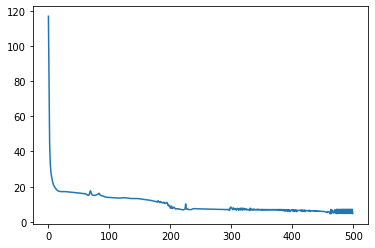

In [53]:
plt.plot(ls_500)
plt.show()

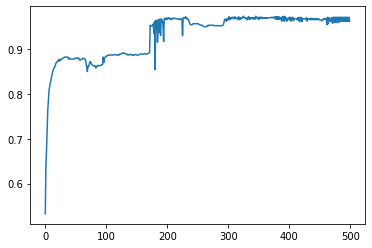

In [54]:
plt.plot(b_500)
plt.show()

In [47]:
print("Test accuracy:", acc_test_new,"Test loss",loss_test_new)

Test accuracy: 0.9527 Test loss 0.15159638


# K FOLD FOR 1000

In [43]:
train_data = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/test3_100data.csv', header = None)
train_label = pd.read_csv('/home/dwijay/NOTEBOOKS/Untitled Folder/EXAM3/test3_100label.csv', header = None)



x_in = np.transpose(train_data.to_numpy())
#x_in = norm(x_in)
y_true=np.transpose(train_label.to_numpy())

y_true_hot = hot_encode(y_true,3)

In [44]:
N = 1000
k = 10

cl_no = 3


for act in ['elu','sigmoid']:
    
    loss_per_hid_size = []
    accu_per_hid_size = []
    trial = 0
    
    m,n = 0,0
    print('----------------------------------------------------------------------------------------------------')
    print('ACTIVATION FUNCTION : ',act)
    
    print('----------------------------------------------------------------------------------------------------')
    
    for n_hidden in [1,2,3,4,5,6,7,8,9,10]:

        avg_loss_per_fold = []
        avg_accu_per_fold = []
        
        for fold in range(k):


            batch_size = 10
            X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
            y = tf.placeholder(tf.int32, shape=(None, 3), name="y")


            a2,logits = train_NN(X,y,n_hidden,act)
            '''Starting with finding loss'''
            with tf.name_scope("loss"):
                cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
                '''cost function'''
                loss=tf.reduce_mean(cross_entropy, name="loss")
                '''Minimizing cost function using gradient descent algorithm'''
            
            if act == 'elu':
                learning_rate=0.01
            else:
                learning_rate=0.04

            with tf.name_scope("grad"):
                optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5)
                training_output=optimizer.minimize(loss)
            '''Accuracy:- .in_top_k() function checks if highest logit corresponds to target class'''
            with tf.name_scope("eval"):
                correct_prediction = tf.equal(tf.argmax(a2, 1), tf.argmax(y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            init = tf.global_variables_initializer()

            with tf.Session() as sess:
                init.run()


                validate_data = x_in[fold*(N//k):(fold+1)*(N//k),:]
                train_data = np.concatenate((x_in[:fold*(N//k),:], x_in[(fold+1)*(N//k):,:]), axis = 0)

                validate_label = y_true_hot[fold*(N//k):(fold+1)*(N//k),:]
                train_label = np.concatenate((y_true_hot[:fold*(N//k),:], y_true_hot[(fold+1)*(N//k):,:]), axis = 0)


                n_epochs = 250
                
                for epoch in range(n_epochs):
                    current_batch_no=0
                    epoch_loss = 0
                    #print('--------------------------------------------------------------------------------------')
                    for iteration in range((N-k)//batch_size):
                        epoch_x,epoch_y,current_batch_no = take_next_batch(current_batch_no,train_data,train_label,batch_size)
                        _,L,a2_gat = sess.run([training_output,loss,a2], feed_dict={X: epoch_x, y: epoch_y})
                        epoch_loss += L


                        #acc_train = accuracy.eval(feed_dict={X: epoch_x, y: epoch_y})

                        #print('Loss',L,'Train Accuracy:',acc_train)

                    #acc_train = accuracy.eval(feed_dict={X: train_data, y: train_label})
                    #loss_train = loss.eval(feed_dict={X: train_data, y: train_label})
                    #acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
                    #loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})
                    
                    #print("Epoch", epoch+1, "Train accuracy:", acc_train, "Test accuracy:", acc_test,"Train loss",loss_train,"test loss",loss_test)
                acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
                loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})   
                avg_loss_per_fold.append(loss_test)
                avg_accu_per_fold.append(acc_test)
        
        loss_per_hid_size.append(np.mean(avg_loss_per_fold))
        accu_per_hid_size.append(np.mean(avg_accu_per_fold))
        
        
        print('When the size of hidden layer is ',n_hidden,', the calculated LOSS is ',loss_per_hid_size[m],' and the calculated accuracy is ',accu_per_hid_size[n])
        print('--------------------------------------------------------------------------------------------------')
        
        
        m += 1
        n += 1
        
        tf.compat.v1.reset_default_graph()
            

        

----------------------------------------------------------------------------------------------------
ACTIVATION FUNCTION :  elu
----------------------------------------------------------------------------------------------------
When the size of hidden layer is  1 , the calculated LOSS is  0.9011196  and the calculated accuracy is  0.564
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  2 , the calculated LOSS is  0.6019505  and the calculated accuracy is  0.782
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  3 , the calculated LOSS is  0.29148728  and the calculated accuracy is  0.925
--------------------------------------------------------------------------------------------------
When the size of hidden layer is  4 , the calculated LOSS is  0.097584434  and the calculated accuracy is  0.969
---------------------------

KeyboardInterrupt: 

In [69]:
batch_size = 10
X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None, 3), name="y")

n_hidden = 4

a2,logits = train_NN(X,y,n_hidden,'elu')
'''Starting with finding loss'''
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
    '''cost function'''
    loss=tf.reduce_mean(cross_entropy, name="loss")
    '''Minimizing cost function using gradient descent algorithm'''

learning_rate=0.01

with tf.name_scope("grad"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5)
    training_output=optimizer.minimize(loss)
'''Accuracy:- .in_top_k() function checks if highest logit corresponds to target class'''
with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(a2, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    N = 1000
    k = 10
    fold = 1

    #validate_data = x_in[fold*(N//k):(fold+1)*(N//k),:]
    #train_data = np.concatenate((x_in[:fold*(N//k),:], x_in[(fold+1)*(N//k):,:]), axis = 0)

    #validate_label = y_true_hot[fold*(N//k):(fold+1)*(N//k),:]
    #train_label = np.concatenate((y_true_hot[:fold*(N//k),:], y_true_hot[(fold+1)*(N//k):,:]), axis = 0)


    n_epochs = 500
    b_1000 = [0]*n_epochs
    c_1000 = [0]*n_epochs
    ls_1000 = [0]*n_epochs

    for epoch in range(n_epochs):
        current_batch_no=0
        epoch_loss = 0
        print('--------------------------------------------------------------------------------------')
        for iteration in range((N-k)//batch_size):
            epoch_x,epoch_y,current_batch_no = take_next_batch(current_batch_no,x_in,y_true_hot,batch_size)
            _,L,a2_gat = sess.run([training_output,loss,a2], feed_dict={X: epoch_x, y: epoch_y})
            epoch_loss += L


            acc_train = accuracy.eval(feed_dict={X: epoch_x, y: epoch_y})

            print('Loss',L,'Train Accuracy:',acc_train)

        acc_train = accuracy.eval(feed_dict={X: train_data, y: train_label})
        loss_train = loss.eval(feed_dict={X: train_data, y: train_label})
        #acc_test = accuracy.eval(feed_dict={X: validate_data, y: validate_label})
        #loss_test = loss.eval(feed_dict={X: validate_data, y: validate_label})
        b_1000[epoch] = acc_train
        c_1000[epoch] = acc_test
        ls_1000[epoch]= epoch_loss

        print("Epoch", epoch+1, "Train accuracy:", acc_train,"Train loss",loss_train)
    
    #acc_test_new = []
    #loss_test_new= []
    #[(ami*100):((ami+1)*100),:]
    #for ami in range(10):
    acc_test_new = (accuracy.eval(feed_dict={X: x_test_in, y: y_test_true_hot}))
    loss_test_new= (loss.eval(feed_dict={X: x_test_in, y: y_test_true_hot}))
    


--------------------------------------------------------------------------------------
Loss 1.8269949 Train Accuracy: 0.5
Loss 3.8932319 Train Accuracy: 0.2
Loss 3.9179547 Train Accuracy: 0.4
Loss 2.2947986 Train Accuracy: 0.4
Loss 1.9021881 Train Accuracy: 0.6
Loss 1.6475182 Train Accuracy: 0.6
Loss 3.9899266 Train Accuracy: 0.5
Loss 1.8401754 Train Accuracy: 0.3
Loss 2.95902 Train Accuracy: 0.5
Loss 2.8424084 Train Accuracy: 0.5
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 1.2355325 Train Accuracy: 0.6
Loss 0.8395503 Train Accuracy: 0.6
Loss 3.2197013 Train Accuracy: 0.6
Loss 1.3305461 Train Accuracy: 0.3
Loss 2.0948443 Train Accuracy: 0.5
Loss 2.5521102 Train Accuracy: 0.4
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.45789376 Train Accuracy: 0.9
Loss 0.41878462 Train Accuracy: 0.9
Loss 0.5748887 Train Accuracy: 0.8
Loss 0.7861627 Train Accuracy: 0.8
Loss 0.6660217 Train Accuracy: 0.8
Loss 0.6166781 Train Accuracy: 0.8
Loss 0.61495054 Train Accuracy: 0.7
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.5266458 Train Accuracy: 0.9
Loss 0.35587776 Train Accuracy: 0.9
Loss 0.38017818 Train Accuracy: 0.9
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.25306082 Train Accuracy: 0.9
Loss 0.398478 Train Accuracy: 1.0
Loss 0.48657656 Train Accuracy: 0.9
Loss 0.34757188 Train Accuracy: 1.0
Loss 0.4664363 Train Accuracy: 0.9
Loss 0.30422437 Train Accuracy: 0.9
Loss 0.3251508 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 33 Train accuracy: 0.9 Train loss 0.36117998
--------------------------------------------------------------------------------------
Loss 0.44244084 Train Accuracy: 0.9
Loss 0.2219863 Train Accuracy: 1.0
Loss 0.38963303 Train Accuracy: 0.9
Loss 0.23320206 Train Accuracy: 0.9
Loss 0.35833034 Train Accuracy: 0.9
Loss 0.47619477 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 36 Train accuracy: 0.9 Train loss 0.33702466
--------------------------------------------------------------------------------------
Loss 0.40858525 Train Accuracy: 0.9
Loss 0.20336318 Train Accuracy: 1.0
Loss 0.38509685 Train Accuracy: 0.9
Loss 0.21428725 Train Accuracy: 0.9
Loss 0.3177666 Train Accuracy: 0.9
Loss 0.46487084 Train Accuracy: 0.9
Loss 0.27804884 Train Accuracy: 1.0
Loss 0.4171033 Train Accuracy: 0.9
Loss 0.27679563 Train Accuracy: 0.9
Loss 0.26920754 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Tr

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Epoch 44 Train accuracy: 0.9111111 Train loss 0.30252483
--------------------------------------------------------------------------------------
Loss 0.35658643 Train Accuracy: 0.9
Loss 0.17300782 Train Accuracy: 1.0
Loss 0.36285192 Train Accuracy: 0.9
Loss 0.1816331 Train Accuracy: 1.0
Loss 0.26259518 Train Accuracy: 1.0
Loss 0.44354457 Train Accuracy: 0.9
Loss 0.231335 Train Accuracy: 1.0
Loss 0.40051374 Train Accuracy: 0.9
Loss 0.2399559 Train Accuracy: 1.0
Loss 0.22464974 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 47 Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 58 Train accuracy: 0.9222222 Train loss 0.27293655
--------------------------------------------------------------------------------------
Loss 0.32490087 Train Accuracy: 0.9
Loss 0.1341105 Train Accuracy: 1.0
Loss 0.30757222 Train Accuracy: 1.0
Loss 0.15226287 Train Accuracy: 1.0
Loss 0.23844345 Train Accuracy: 1.0
Loss 0.42503437 Train Accuracy: 0.9
Loss 0.18117261 Train Accuracy: 1.0
Loss 0.386664 Train Accuracy: 0.9
Loss 0.20991454 Train Accuracy: 1.0
Loss 0.19250464 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss n

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 61 Train accuracy: 0.9222222 Train loss 0.2678295
--------------------------------------------------------------------------------------
Loss 0.3215676 Train Accuracy: 0.9
Loss 0.12715496 Train Accuracy: 1.0
Loss 0.29627663 Train Accuracy: 1.0
Loss 0.14727087 Train Accuracy: 1.0
Loss 0.23449974 Train Accuracy: 1.0
Loss 0.42115992 Train Accuracy: 0.9
Loss 0.17305303 Train Accuracy: 1.0
Loss 0.38349238 Train Accu

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.31364837 Train Accuracy: 0.9
Loss 0.09896767 Train Accuracy: 1.0
Loss 0.24155243 Train Accuracy: 1.0
Loss 0.12547514 Train Accuracy: 1.0
Loss 0.22024795 Train Accuracy: 1.0
Loss 0.4099664 Train Accuracy: 0.9
Loss 0.1346512 Train Accuracy: 1.0
Loss 0.36943942 Train Accuracy: 0.9
Loss 0.19194958 Train Accuracy: 1.0
Loss 0.1615857 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 81 Train accuracy: 0.9111111 Train loss 0.24092108
--------------------------------------------------------------------------------------
Loss 0.312742 Train Accuracy: 0.9
Loss 0.095

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 110 Train accuracy: 0.9222222 Train loss 0.21443509
--------------------------------------------------------------------------------------
Loss 0.3075157 Train Accuracy: 0.9
Loss 0.07294444 Train Accuracy: 1.0
Loss 0.17686321 Train Accuracy: 1.0
Loss 0.09919931 Train Accuracy: 1.0
Loss 0.20775923 Train Accuracy: 1.0
Loss 0.41137886 Train Accuracy: 0.9
Loss 0.090743974 Train Accuracy: 1.0
Loss 0.3399934 Train Accuracy: 0.9
Loss 0.17754531 Train Accuracy: 1.0
Loss 0.13433373 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Los

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 139 Train accuracy: 0.9222222 Train loss 0.19436456
--------------------------------------------------------------------------------------
Loss 0.30819508 Train Accuracy: 0.9
Loss 0.060512554 Train Accuracy: 1.0
Loss 0.14031407 Train Accuracy: 1.0
Loss 0.0820796 Train Accuracy: 1.0
Loss 0.19692965 Train Accuracy: 1.0
Loss 0.4174308 Train Accuracy: 0.9
Loss 0.068249114 Train Accuracy: 1.0
Loss 0.3091747 Train Accuracy: 0.9
Loss 0.17278378 Train Accuracy: 1.0
Loss 0.12013002 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Los

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 142 Train accuracy: 0.93333334 Train loss 0.19255146
--------------------------------------------------------------------------------------
Loss 0.30820352 Train Accuracy: 0.9
Loss 0.059561945 Train Accuracy: 1.0
Loss 0.137382 Train Accuracy: 1.0
Loss 0.08057336 Train 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.17175323 Train Accuracy: 1.0
Loss 0.116028346 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 153 Train accuracy: 0.93333334 Train loss 0.18622157
--------------------------------------------------------------------------------------
Loss 0.308235 Train Accuracy: 0.9
Loss 0.056480926 Train Accuracy: 1.0
Loss 0.12774909 Train Accuracy: 1.0
Loss 0.07532029 Train Accuracy: 1.0
Loss 0.19151586 Train Accuracy: 1.0
Loss 0.42106757 Train Accuracy: 0.9
Loss 0.060615998 Train Accuracy: 1.0
Loss 0.29387957 Train Accuracy: 0.9
Loss 0.17154408 Train Accuracy: 1.0
Loss 0.11504785 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
L

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.42263198 Train Accuracy: 0.9
Loss 0.056887545 Train Accuracy: 1.0
Loss 0.28520525 Train Accuracy: 0.9
Loss 0.1710792 Train Accuracy: 1.0
Loss 0.11269585 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 164 Train accuracy: 0.93333334 Train loss 0.1803339
--------------------------------------------------------------------------------------
Loss 0.3085006 Train Accuracy: 0.9
Loss 0.053993493 Train Accuracy: 1.0
Loss 0.1196181 Train Accuracy: 1.0
Loss 0.07048371 Train Accuracy: 1.0
Loss 0.18692586 Train Accuracy: 1.0
Loss 0.4231082 Train Accuracy: 0.9
Loss 0.055589695 Train Accuracy: 1.0
Loss 0.2819888 Train Accuracy: 0.9
Loss 0.17092976 Train Accuracy: 1.0
Loss 0.11190579 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 167 Train accuracy: 0.93333334 Train loss 0.17880054
--------------------------------------------------------------------------------------
Loss 0.30863202 Train Accuracy: 0.9
Loss 0.053409792 Train Accuracy: 1.0
Loss 0.11762305 Train Accuracy: 1.0
Loss 0.06923533 Train Accuracy: 1.0
Loss 0.18563807 Train Accuracy: 1.0
Loss 0.42352143 Train Accuracy: 0.9
Loss 0.05434238 Train Accura

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.17038651 Train Accuracy: 1.0
Loss 0.109347925 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 178 Train accuracy: 0.93333334 Train loss 0.1734229
--------------------------------------------------------------------------------------
Loss 0.30925938 Train Accuracy: 0.9
Loss 0.05156542 Train Accuracy: 1.0
Loss 0.11095603 Train Accuracy: 1.0
Loss 0.06491141 Train Accuracy: 1.0
Loss 0.18074496 Train Accuracy: 1.0
Loss 0.4246458 Train Accuracy: 0.9
Loss 0.05015983 Train Accuracy: 1.0
Loss 0.26731747 Train Accuracy: 0.9
Loss 0.17018251 Train Accuracy: 1.0
Loss 0.10865779 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Los

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 181 Train accuracy: 0.93333334 Train loss 0.17204525
--------------------------------------------------------------------------------------
Loss 0.30938998 Train Accuracy: 0.9
Loss 0

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 189 Train accuracy: 0.93333334 Train loss 0.16855381
--------------------------------------------------------------------------------------
Loss 0.30968785 Train Accuracy: 0.9
Loss 0.04997151 Train Accuracy: 1.0
Loss 0.105113424 Train Accuracy: 1.0
Loss 0.06105244 Train Accuracy: 1.0
Loss 0.17590259 Train Accuracy: 1.0
Loss 0.42528048 Train Accuracy: 0.9
Loss 0.046552427 Train Accuracy: 1.0
Loss 0.25639945 Train Accuracy: 0.9
Loss 0.16950613 Train Accuracy: 1.0
Loss 0.106240176 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 192 Train accuracy: 0.93333334 Train loss 0.1672819
--------------------------------------------------------------------------------------
Loss 0.30990297 Train Accuracy: 0.9
Loss 0.049564056 Train Accuracy: 1.0
Loss 0.10360201 Train Accuracy: 1.0
Loss 0.0600591 Train Accuracy: 1.0
Loss 0.17455445 Train Accuracy: 1.0
Loss 0.42521828 Train Accuracy: 0.9
Loss 0.045661613 Train Accuracy: 1.0
Loss 0.25356737 Train Accuracy: 0.9
Loss 0.16935214 Train Accuracy: 1.0
Loss 0.10558677 Train Accuracy: 1.0
L

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 195 Train accuracy: 0.93333334 Train loss 0.16607444
-------------

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 206 Train accuracy: 0.9444444 Train loss 0.16182597
--------------------------------------------------------------------------------------
Loss 0.3100408 Train Accuracy: 0.9
Loss 0.047602307 Train Accuracy: 1.0
Loss 0.097371176 Train Accuracy: 1.0
Loss 0.055774737 Train Accuracy: 1.0
Loss 0.16832545 Train Accuracy: 1.0
Loss 0.4250163 Train Accuracy: 0.9
Loss 0.041752696 Train Accuracy: 1.0
Loss 0.24113867 Train Accuracy: 0.9
Loss 0.16856274 Train Accuracy: 1.0
Loss 0.102878734 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Epoch 217 Train accuracy: 0.95555556 Train loss 0.15790993
--------------------------------------------------------------------------------------
Loss 0.30998796 Train Accuracy: 0.9
Loss 0.046291187 Train Accuracy: 1.0
Loss 0.093225025 Train Accuracy: 1.0
Loss 0.052745797 Train Accuracy: 1.0
Loss 0.16360433 Train Accuracy: 1.0
Loss 0.42425376 Train Accuracy: 0.9
Loss 0.039021995 Train Accuracy: 1.0
Loss 0.2321128 Train Accuracy: 0.9
Loss 0.16792972 Train Accuracy: 1.0
Loss 0.101217985 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: n

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 220 Train accuracy: 0.95555556 Train loss 0.15689223
--------------------------------------------------------------------------------------
Loss 0.3099696 Train Accuracy: 0.9
Loss 0.045967713 Train Accuracy: 1.0
Loss 0.092190936 Train Accuracy: 1.0
Loss 0.051967323 Train Accuracy: 1.0
Loss 0.16235198 Train Accuracy: 1.0
Loss 0.42394423 Train Accuracy: 0.9
Loss 0.03832668 Train Accuracy: 1.0
Loss 0.22974794 Train Accuracy: 0.9
Loss 0.16775456 Train Accuracy: 1.0
Loss 0.1008204 Train Accuracy: 1.0
Loss nan Train Accuracy: nan


Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.22363386 Train Accuracy: 0.9
Loss 0.1672825 Train Accuracy: 1.0
Loss 0.09985257 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 231 Train accuracy: 0.95555556 Train loss 0.1533263
--------------------------------------------------------------------------------------
Loss 0.3098872 Train Accuracy: 0.9
Loss 0.044889897 Train Accuracy: 1.0
Loss 0.0887063 Train Accuracy: 1.0
Loss 0.04927392 Train Accuracy: 1.0
Loss 0.15789846 Train Accuracy: 1.0
Loss 0.42244783 Train Accuracy: 0.9
Loss 0.035940368 Train Accuracy: 1.0
Loss 0.22141159 Train Accuracy: 0.9
Loss 0.16710435 Train Accuracy: 1.0
Loss 0.09951877 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Lo

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 234 Train accuracy: 0.95555556 Train loss 0.15239614
-----------------------------------------------------------------------

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 242 Train accuracy: 0.95555556 Train loss 0.1499477
--------------------------------------------------------------------------------------
Loss 0.30947885 Train Accuracy: 0.9
Loss 0.04393832 Train Accuracy: 1.0
Loss 0.0856498 Train Accuracy: 1.0
Loss 0.046789683 Train Accuracy: 1.0
Loss 0.15353978 Train Accuracy: 1.0
Loss 0.4206322 Train Accuracy: 0.9
Loss 0.033756226 Train Accuracy: 1.0
Loss 0.21361041 Train Accuracy: 0.9
Loss 0.16635391 Train Accuracy: 1.0
Loss 0.098468184 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
L

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 245 Train accuracy: 0.95555556 Train loss 0.14901815
-------------

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.16513737 Train Accuracy: 1.0
Loss 0.098395236 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 256 Train accuracy: 0.95555556 Train loss 0.14560655
--------------------------------------------------------------------------------------
Loss 0.30776653 Train Accuracy: 0.9
Loss 0.043252505 Train Accuracy: 1.0
Loss 0.082201816 Train Accuracy: 1.0
Loss 0.043727808 Train Accuracy: 1.0
Loss 0.14725652 Train Accuracy: 1.0
Loss 0.4185296 Train Accuracy: 0.9
Loss 0.031075174 Train Accuracy: 1.0
Loss 0.2040128 Train Accuracy: 0.9
Loss 0.16469148 Train Accuracy: 1.0
Loss 0.098595016 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 259 Train accuracy: 0.95555556 Train 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.042919446 Train Accuracy: 1.0
Loss 0.079198726 Train Accuracy: 1.0
Loss 0.0414186 Train Accuracy: 1.0
Loss 0.14143057 Train Accuracy: 1.0
Loss 0.41834456 Train Accuracy: 0.9
Loss 0.029111007 Train Accuracy: 1.0
Loss 0.19604523 Train Accuracy: 1.0
Loss 0.16206701 Train Accuracy: 1.0
Loss 0.099020146 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss n

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 270 Train accuracy: 0.95555556 Train loss 0.14131944
--------------------------------------------------------------------------------------
Loss 0.30458567 Train Accuracy: 0.9
Loss 0.04283967 Train Accuracy: 1.0
Loss 0.078381196 Train Accuracy: 1.0
Loss 0.04080917 Train Accuracy: 1.0
Loss 0.13978752 Train Accuracy: 1.0
Loss 0.41843018 Train Accuracy: 0.9
Loss 0.028610164 Train Accuracy: 1.0
Loss 0.19386762 Train Accuracy: 1.0
Loss 0.16129074 Train Accuracy: 1.0
Loss 0

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 281 Train accuracy: 0.95555556 Train loss 0.13804613
--------------------------------------------------------------------------------------
Loss 0.3013641 Train Accuracy: 0.9
Loss 0.042732306 Train Accuracy: 1.0
Loss 0.07548016 Train Accuracy: 1.0
Loss 0.03857786 Train Accuracy: 1.0
Loss 0.13342026 Train Accuracy: 1.0
Loss 0.4189674 Train Accuracy: 0.9
Loss 0.026872078 Train Accuracy: 1.0
Loss 0.18591943 Train Accuracy: 1.0
Loss 0.15795681 Train Accuracy: 1.0
Loss 0.1006309 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Lo

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.41937232 Train Accuracy: 0.9
Loss 0.025734682 Train Accuracy: 1.0
Loss 0.18017872 Train Accuracy: 1.0
Loss 0.15512437 Train Accuracy: 1.0
Loss 0.1018585 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 292 Train accuracy: 0.95555556 Train loss 0.13485816
--------------------------------------------------------------------------------------
Loss 0.29820284 Train Accuracy: 0.9
Loss 0.042824257 Train Accuracy: 1.0
Loss 0.07271429 Train Accuracy: 1.0
Loss 0.03640296 Train Accuracy: 1.0
Loss 0.12684473 Train Accuracy: 1.0
Loss 0.41948643 Train Accuracy: 0.9
Loss 0.025340343 Train Accuracy: 1.0
Loss 0.17804313 Train Accuracy: 1.0
Loss 0.15401343 Train Accuracy: 1.0
Loss 0.102321506 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Epoch 303 Train accuracy: 0.95555556 Train loss 0.13178596
--------------------------------------------------------------------------------------
Loss 0.29550415 Train Accuracy: 0.9
Loss 0.042974044 Train Accuracy: 1.0
Loss 0.07005744 Train Accuracy: 1.0
Loss 0.034332663 Train Accuracy: 1.0
Loss 0.12034734 Train Accuracy: 1.0
Loss 0.4198177 Train Accuracy: 0.9
Loss 0.02403489 Train Accuracy: 1.0
Loss 0.169849 Train Accuracy: 1.0
Loss 0.14996381 Train Accuracy: 1.0
Loss 0.10387126 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Lo

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 306 Train accuracy: 0.95555556 Train loss 0.1309649
--------------------------------------------------------------------------------------
Loss 0.29499194 Train Accuracy: 0.9
Loss 0.043052357 Train Accuracy: 1.0
Loss 0.06935336 Train Accuracy: 1.0
Loss 0.033787947 Train Accuracy: 1.0
Loss 0.11863704 Train Accuracy: 1.0
Loss 0.41981167 Train Accuracy: 0.9
Loss 0.023722213 Train Accuracy: 1.0
Loss 0.16765675 Train Accuracy: 1.0
Loss 0.14885747 Train Accuracy: 1.0
Loss 0.10421753 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 309 Train accuracy: 0.95555556 Train loss 0.13019101
------------------------------------------

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.03205333 Train Accuracy: 1.0
Loss 0.11339986 Train Accuracy: 1.0
Loss 0.4196194 Train Accuracy: 0.9
Loss 0.02266925 Train Accuracy: 1.0
Loss 0.16072032 Train Accuracy: 1.0
Loss 0.14505395 Train Accuracy: 1.0
Loss 0.10526218 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy:

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 320 Train accuracy: 0.95555556 Train loss 0.12761705
--------------------------------------------------------------------------------------
Loss 0.2926894 Train Accuracy: 0.9
Loss 0.043147247 Train Accuracy: 1.0

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Epoch 328 Train accuracy: 0.95555556 Train loss 0.12592
--------------------------------------------------------------------------------------
Loss 0.2912734 Train Accuracy: 0.9
Loss 0.043019246 Train Accuracy: 1.0
Loss 0.06452711 Train Accuracy: 1.0
Loss 0.030580442 Train Accuracy: 1.0
Loss 0.10906621 Train Accuracy: 1.0
Loss 0.41920477 Train Accuracy: 0.9
Loss 0.021708455 Train Accuracy: 1.0
Loss 0.15474515 Train Accuracy: 1.0
Loss 0.14173548 Train Accuracy: 1.0
Loss 0.105973974 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
L

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 331 Train accuracy: 0.95555556 Train loss 0.12531398
--------------------------------------------------------------------------------------
Loss 0.2907042 Train Accuracy: 0.9
Loss 0.042942293 Train Accuracy: 1.0
Loss 0.06391782 Train Accuracy: 1.0
Loss 0.030209828 Train Accuracy: 1.0
Loss 0.10798849 Train Accuracy: 1.0
Loss 0.41905633 Train Accuracy: 0.9

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.020815868 Train Accuracy: 1.0
Loss 0.14937091 Train Accuracy: 1.0
Loss 0.1387736 Train Accuracy: 1.0
Loss 0.10643544 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 342 Train accuracy: 0.95555556 Train loss 0.12319141
--------------------------------------------------------------------------------------
Loss 0.28859043 Train Accuracy: 0.9
Loss 0.04258486 Train Accuracy: 1.0
Loss 0.061773885 Train Accuracy: 1.0
Loss 0.028927412 Train Accuracy: 1.0
Loss 0.10429533 Train Accuracy: 1.0
Loss 0.41836032 Train Accuracy: 0.9
Loss 0.020584445 Train Accuracy: 1.0
Loss 0.14797492 Train Accuracy: 1.0
Loss 0.13802007 Train Accuracy: 1.0
Loss 0.10652484 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 345 Train accuracy: 0.95555556 Train loss 0.1226369
--------------------------------------------------------------------------------------
Loss 0.28802007 Train Accuracy: 0.9
Loss 0.

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.13479233 Train Accuracy: 1.0
Loss 0.10674582 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan


Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 359 Train accuracy: 0.95555556 Train loss 0.12016627
--------------------------------------------------------------------------------------
Loss 0.28544104 Train Accuracy: 0.9
Loss 0.041866384 Train Accuracy: 1.0
Loss 0.05872076 Train Accuracy: 1.0
Loss 0.02713438 Train Accuracy: 1.0
Loss 0.099242866 Train Accuracy: 1.0
Loss 0.41678485 Train Accuracy: 0.9
Loss 0.019362627 Train Accuracy: 1.0
Loss 0.14050627 Train Accuracy: 1.0
Loss 0.13415763 Train Accuracy: 1.0
Loss 0.10675335 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 362 Train accuracy: 0.95555556 Train loss 0.11965972
--------------------------------------------------------------------------------------
Loss 0.28491032 Train Accuracy: 0.9
Loss 0.041726265 Train Accuracy: 1.0
Loss 0.058213484 Train Accuracy: 1.0
Loss 0.026838 Train Accuracy: 1.0
Loss 0.09841919 Train Accuracy: 1.0
Loss 0.41645008 Train Accuracy: 0.9
Loss 0.01916141 Train Accurac

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.01845634 Train Accuracy: 1.0
Loss 0.13484436 Train Accuracy: 1.0
Loss 0.13143006 Train Accuracy: 1.0
Loss 0.10661874 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 376 Train accuracy: 0.96666664 Train loss 0.11738938
--------------------------------------------------------------------------------------
Loss 0.28255048 Train Accuracy: 0.9
Loss 0.04104075 Train Accuracy: 1.0
Loss 0.05596549 Train Accuracy: 1.0
Loss 0.025525486 Train Accuracy: 1.0
Loss 0.09480259 Train Accuracy: 1.0
Loss 0.4146886 Train Accuracy: 0.9
Loss 0.018272374 Train Accuracy: 1.0
Loss 0.13368279 Train Accuracy: 1.0
Loss 0.13089164 Train Accuracy: 1.0
Loss 0.10655564 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan


Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 379 Train accuracy: 0.96666664 Train loss 0.11692158
--------------------------------------------------------------------------------------
Loss 0.28207022 Train Accuracy: 0.9
Loss 0.040888757 Train Accuracy: 1.0
Loss 0.055508535 Train Accuracy: 1.0
Loss 0.0252586 Train Accuracy: 1.0
Loss 0.094072595 Train Accuracy: 1.0
Loss 0.41427127 Train Accuracy: 0.9
Loss 0.01809178 Train Accuracy: 1.0
Loss 0.13253859 Train Accuracy: 1.0
Loss 0.13036825 Train Accuracy: 1.0
Loss 0

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 382 Train accuracy: 0.96666664 Train 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.10599096 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss na

Loss 0.279521 Train Accuracy: 0.9
Loss 0.040000074 Train Accuracy: 1.0
Loss 0.053072907 Train Accuracy: 1.0
Loss 0.02383671 Train Accuracy: 1.0
Loss 0.09020579 Train Accuracy: 1.0
Loss 0.4116405 Train Accuracy: 0.9
Loss 0.017129183 Train Accuracy: 1.0
Loss 0.12636325 Train Accuracy: 1.0
Loss 0.12768777 Train Accuracy: 1.0
Loss 0.105855286 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
L

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 399 Train accuracy: 0.96666664 Train loss 0.11395964
--------------------------------------------------------------------------------------
Loss 0.2790936 Train Accuracy: 0.9
Loss 0.039838396 Train Accuracy: 1.0
Loss 0.052670527 Train Accuracy: 1.0
Loss 0.023599898 Train Accuracy: 1.0
Loss 0.0895686 Train Accuracy: 1.0
Loss 0.4111353 Train Accuracy: 0.9
Loss 0.01696987 Train Accuracy: 1.0
Loss 0.12531333 Train Accuracy: 1.0
Loss 0.1272724 Train Accuracy: 1.0
Loss 0.10570921 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Lo

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 402 Train accuracy: 0.96666664 Train loss 0.113536224
--------------------------------------------------------------------------------------
Loss 0.27866077 Train Accuracy: 0.9
Loss 0.039675154 Train Accuracy: 1.0
Loss 0.052276384 Train Accuracy: 1.0
Loss 0.023365295 Train Accuracy: 1.0
Loss 0.088

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Epoch 416 Train accuracy: 0.96666664 Train loss 0.11162314
--------------------------------------------------------------------------------------
Loss 0.2766268 Train Accuracy: 0.9
Loss 0.03890376 Train Accuracy: 1.0
Loss 0.05052612 Train Accuracy: 1.0
Loss 0.022319358 Train Accuracy: 1.0
Loss 0.086089395 Train Accuracy: 1.0
Loss 0.40827876 Train Accuracy: 0.9
Loss 0.016118687 Train Accuracy: 1.0
Loss 0.119586274 Train Accuracy: 1.0
Loss 0.12514317 Train Accuracy: 1.0
Loss 0.10477678 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 419 Train accuracy: 0.96666664 Train loss 0.111225404
--------------------------------------------------------------------------------------
Loss 0.27620366 Train Accuracy: 0.9
Loss 0.038740125 Train Accuracy: 1.0
Loss 0.050168984 Train Accuracy: 1.0
Loss 0.022106351 Train Accuracy: 1.0
Loss 0.08551371 Train Accuracy: 1.0
Loss 0.40778035 Train Accuracy: 0.9
Loss 0.01597709 Train Accuracy: 1.0
Loss 0.11861541 Train Accuracy: 1.0
Loss 0.12479569 Train Accuracy: 1.0
Loss 0.10460069 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: n

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 422 Train accuracy: 0.96666664 Train loss 0.110831484
--------------------------------------------------------------------------------------
Loss 0.2757948 Train Accuracy: 0.9
Loss 0.038580753 Train Accuracy: 1.0
Loss 0.04981761 Train Accur

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.03766706 Train Accuracy: 1.0
Loss 0.04794048 Train Accuracy: 1.0
Loss 0.020789139 Train Accuracy: 1.0
Loss 0.08189553 Train Accuracy: 1.0
Loss 0.40415865 Train Accuracy: 0.9
Loss 0.015093954 Train Accuracy: 1.0
Loss 0.112564005 Train Accuracy: 1.0
Loss 0.12273302 Train Accuracy: 1.0
Loss 0.10325533 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss n

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 442 Train accuracy: 0.96666664 Train loss 0.1083489
--------------------------------------------------------------------------------------
Loss 0.27326846 Train Accuracy: 0.9
Loss 0.037506536 Train Accuracy: 1.0
Loss 0.047629572 Train Accuracy: 1.0
Loss 0.02060634 Train Accuracy: 1.0
Loss 0.08139291 Train Accuracy: 1.0
Loss 0.4035917 Train Accuracy: 0.9
Loss 0.014968549 Train Accuracy: 1.0
Loss 0.11171512 Train Accuracy: 1.0
Loss 0.12245113 Train Accuracy: 1.0
Loss 0.103031754 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 445 Train accuracy: 0.96666664 Train loss 0.107994474
--------------------------------------------------------------------------------------
Loss 0.27290738 Train Accuracy: 0.9
Loss 0.037346616 Train Accuracy: 1.0
Loss 0.047324307 Train Acc

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss 0.4003037 Train Accuracy: 0.9
Loss 0.014289418 Train Accuracy: 1.0
Loss 0.10716994 Train Accuracy: 1.0
Loss 0.120959856 Train Accuracy: 1.0
Loss 0.10169337 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 462 Train accuracy: 0.96666664 Train loss 0.10606986
--------------------------------------------------------------------------------------
Loss 0.27093846 Train Accuracy: 0.9
Loss 0.036447663 Train Accuracy: 1.0
Loss 0.045693588 Train Accuracy: 1.0
Loss 0.019474383 Train Accuracy: 1.0
Loss 0.07828375 Train Accuracy: 1.0
Loss 0.3997102 Train Accuracy: 0.9
Loss 0.014174965 Train Accuracy: 1.0
Loss 0.10640906 Train Accuracy: 1.0
Loss 0.12071262 Train Accuracy: 1.0
Loss 0.10144772 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 465 Train accuracy: 0.96666664 Train loss 0.1057434
--------------------------------------------------------------------------------------
Loss 0.27060458 Train Accuracy: 0.9
Loss 0.036291648 Train Accuracy: 1.0

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Epoch 479 Train accuracy: 0.96666664 Train loss 0.104266986
--------------------------------------------------------------------------------------
Loss 0.26910093 Train Accuracy: 0.9
Loss 0.035578065 Train Accuracy: 1.0
Loss 0.04421065 Train Accuracy: 1.0
Loss 0.018615598 Train Accuracy: 1.0
Loss 0.07591506 Train Accuracy: 1.0
Loss 0.3962863 Train Accuracy: 0.9
Loss 0.013555852 Train Accuracy: 1.0
Loss 0.10230174 Train Accuracy: 1.0
Loss 0.11938556 Train Accuracy: 1.0
Loss 0.100019015 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: n

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 482 Train accuracy: 0.96666664 Train loss 0.10396023
--------------------------------------------------------------------------------------
Loss 0.26879027 Train Accuracy: 0.9
Loss 0.035428487 Train Accuracy: 1.0
Loss 0.043962453 Train Accuracy: 1.0
Loss 0.01847274 Train Accuracy: 1.0
Loss 0.0755189 Train Accuracy: 1.0
Loss 0.39567322 Train Accuracy: 0.9
Loss 0.013451599 Train Accuracy: 1.0
Loss 0.1016106 Train Accuracy: 1.0
Loss 0.11916302 Train Accuracy: 1.0
Loss 0.099762 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Lo

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 485 Train accuracy: 0.96666664 Train 

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 496 Train accuracy: 0.96666664 Train loss 0.102560245
--------------------------------------------------------------------------------------
Loss 0.26739246 Train Accuracy: 0.9
Loss 0.034734674 Train Accuracy: 1.0
Loss 0.042850953 Train Accuracy: 1.0
Loss 0.017837841 Train Accuracy: 1.0
Loss 0.073745094 Train Accuracy: 1.0
Loss 0.3927208 Train Accuracy: 0.9
Loss 0.01298395 Train Accuracy: 1.0
Loss 0.09852366 Train Accuracy: 1.0
Loss 0.1181678 Train Accuracy: 1.0
Loss 0.09855034 Train Accuracy: 1.0
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: na

Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Loss nan Train Accuracy: nan
Epoch 499 Train accuracy: 0.96666664 Train loss 0.102269046
--------------------------------------------------------------------------------------
Loss 0.2670982 Train Accuracy: 0.9
Loss 0.03458296 Train Accuracy: 1.0
Loss 0.042622704 Train Accuracy: 1.0
Loss 0.017709117 Train Accuracy: 1.0
Loss 0.07339237 Train Accuracy: 1.0
Loss 0.3920703 Train Accuracy: 0.9

In [73]:
print('Model trained on dataset with 1000 samples')
print("Test accuracy:", 0.9765)
print("Test loss:",0.13721217)
print('-----------------------------------------------------')

Model trained on dataset with 1000 samples
Test accuracy: 0.9765
Test loss: 0.13721217
-----------------------------------------------------


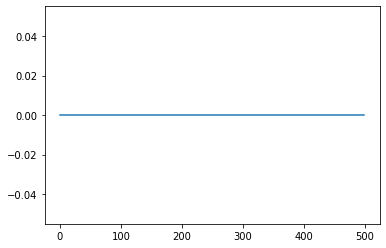

In [56]:
Test accuracy: 0.9527 Test loss 0.15159638
Test accuracy: 0.9565 Test loss 0.13721217

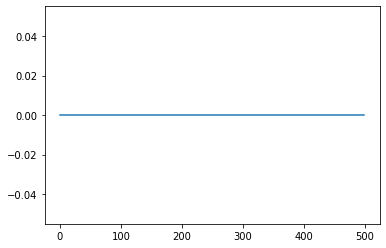

In [58]:
plt.plot(b)
plt.show()